## <center> Setup: Import Libraries & Define Data Paths

In this first section we get everything ready for our analysis. We begin by loading all of the Python packages we will need. Immediately after the imports, we define a series of variables—one for each CSV file we’ll load later. By assigning each dataset path to a clearly named variable (for example, tau_file = "ttau_ptau.csv" or cdr_file = "CDR.csv"), we make it easy to change those locations in one place if our data folder ever moves or is reorganized.

In [1]:
# General utilities
import os
import csv
import json
import logging
from pathlib import Path
from functools import reduce

# Scientific stack
import numpy as np
import pandas as pd
from scipy.stats import (
    ttest_rel,            # paired t-test
    t as student_t,       # alias kept intentionally
    pearsonr,
    wilcoxon
)
from scipy.spatial.distance import squareform

# Machine learning / preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# Clustering / dimensionality reduction
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from sklearn.cluster import DBSCAN
from umap.umap_ import UMAP
from openTSNE import TSNE as oTSNE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Parallelization
from joblib import Parallel, delayed
import joblib

# Deep learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout,
    Bidirectional, LSTM, Dense, TimeDistributed,
    Lambda, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, LambdaCallback

# Xarray (multidimensional data handling)
import xarray as xr


# File Paths
tau_file = r"ttau_ptau.csv"
cdr_file = r"CDR.csv"
faq_file = r"FunctionalActivitiesQuestionnaire.csv"
mmse_file = r"MMSE.csv"
neurobattery_file = r"NEUROBAT.csv"
demographics_file = r"DemographicInfo.csv"
vitals_file = r"VITALS.csv"
neuroexam_file = r"NEUROExam.csv"
diagnosis_file = r"diagnosis.csv"
plasma_biomarker_file = r"plasmaBiomarkers.csv"
genotype_file = r"genotype.csv"
family_history_parents_file = r"FamilyParents.csv"
family_history_siblings_file = r"FamilySiblings.csv"
family_history_whole_file = r"FamilyWhole.csv"
csf_file = r"CSF.csv"
npiq_file = r"NPIQ.csv"
PETamy_file = r"PET_amy_6mm.csv"
genetic_file = r"GeneticData.csv"
medical_history_file = r"MedicalHistory.csv"
adas1_file = r"ADAS_ADNI1.csv"
adasGO23_file = r"ADAS_ADNIGO23.csv"
av45PET_file = r"AV45.csv"
moca_file = r"MOCA.csv"
FoxLabMRI_file = r"FOXlabMRI.csv"
MRIcomprehensive_file = r"MRIcomprehensive.csv"
ucsfFreesurferMRI_file = r"UCSFfreesurferMRI.csv"
mriDatasetUSCF_file = r"MRIdatasetUSCF.csv"
adspCognitive_file = r"ADSPcognitive.csv"
embicCognitive_file = r"EMBICneuro.csv"
embicDigital_file = r"EMBICdigital.csv"
neuropathology_file = r"neuropathology.csv"
GeriatricDepressionScale_file = r"GeriatricDepressionScale.csv"
lipidomics_file = r"lipidomics.csv"
lipoproteins_file = r"LipoproteinsAndMetabolites.csv"
GutMetabolites_file = r"gutmetabolites.csv"
PlasmaNFL = r"PlasmaNFL.csv"
uu_PET_file = r"uu_PET.csv"
csfbiobank_file = r"CSF_ROCHEbiobank.csv"
proteinmatrix_file = r"proteinmatrix.csv"
bileacids_file = r"bileacids.csv"
csfinflammatoryproteins_file = r"csfinflammatoryproteins.csv"
ptau181_file = r"ptau181.csv"
ravlt_file = r"RAVLT.csv"
pet_amyloid_detailed_file = r"ADSP_PET_Amyloid_Detailed.csv"
pet_tau_detailed_file = r"ADSP_PHC_PET_Tau_Detailed.csv"


## <center> Step 1: Unified VISCODE Normalization and CSV Loader for Longitudinal Visit Data

Here we define two helper functions to standardize and load visit codes (VISCODE) across all our datasets.

map_viscode_to_month: Converts various visit code formats (e.g., “bl”, “v03”, “y1.5”) into a consistent monthly format (e.g., “bl”, “m06”, “m18”). Baseline visits are all mapped to “bl”, codes starting with “m” are left unchanged, “y”-prefixed year codes are converted to months, and legacy “vXX” codes are translated according to our predefined mapping.

load_with_viscode: Reads a CSV file, ensures a single VISCODE column (filling from VISCODE2 or defaulting to baseline), filters to only the columns you need, coerces RID to integer and drops invalid entries, and then applies map_viscode_to_month to harmonize all visit codes before returning the cleaned DataFrame.

Using these functions ensures that every dataset you load will have a consistent, month-based visit identifier ready for merging and analysis.

In [2]:
# Unified VISCODE Processing Functions
def map_viscode_to_month(vis):
    """
    Convert a visit code into a unified format matching the paper's methodology.
    Baseline codes are mapped to "bl". Other codes are converted if necessary.
    """
    vis = str(vis).lower().strip()
    baseline_codes = {"bl", "init", "sc", "v01", "4_init", "4_sc", "4_bl", "4-init"}
    if vis in baseline_codes:
        return "bl"
    if vis.startswith("m"):
        return vis
    if vis.startswith("y"):
        try:
            year_num = float(vis[1:])
            months = int(round(year_num * 12))
            return f"m{months}"
        except Exception as e:
            return vis
    if vis.startswith("v"):
        mapping = {
            "v03": "m06",
            "v06": "m12",
            "v11": "m18",
            "v21": "m24",
            "v41": "m48"
        }
        return mapping.get(vis, vis)
    return vis


def load_with_viscode(file_path, relevant_columns, require_viscode=True):
    """
    Loads a CSV file and returns a DataFrame with a unified VISCODE column.
    If both VISCODE and VISCODE2 are present, fills missing VISCODE values with VISCODE2.
    If neither is present, adds VISCODE="bl". Only the specified columns are kept.
    """
    df = pd.read_csv(file_path, low_memory=False)
    
    if "VISCODE" not in df.columns and "VISCODE2" not in df.columns:
        df["VISCODE"] = "bl"
    
    if require_viscode:
        if "VISCODE" not in df.columns and "VISCODE2" in df.columns:
            df.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)
        elif "VISCODE" in df.columns and "VISCODE2" in df.columns:
            df["VISCODE"] = df["VISCODE"].fillna(df["VISCODE2"])
            df.drop(columns=["VISCODE2"], inplace=True)
        if "VISCODE" not in df.columns:
            raise KeyError(f"'VISCODE' not found in {file_path} and no VISCODE2 available.")
    
    df = df[relevant_columns]
    
    if "RID" in df.columns:
        df["RID"] = pd.to_numeric(df["RID"], errors='coerce')
        df = df.dropna(subset=["RID"])
        df["RID"] = df["RID"].astype(int)
    
    if "VISCODE" in df.columns:
        df["VISCODE"] = df["VISCODE"].apply(map_viscode_to_month)
    
    return df

## <center> step 2: Function to Drop Features with Excessive Missing Values at Baseline

This function scans your DataFrame’s baseline visits (where VISCODE=="bl") and computes the percentage of missing values for each column. Any feature (except RID and VISCODE) with more than the specified threshold (default 30%) missing at baseline is removed. It prints out which columns are dropped and returns the cleaned DataFrame, helping you eliminate variables that lack sufficient data at the start of the study.

In [3]:
# Drop Columns with >30% Missing at Baseline

def drop_high_missing_baseline(df, threshold_pct=30):
    """
    For a DataFrame with a VISCODE column, drop columns (other than RID and VISCODE)
    where the percentage of missing values among baseline (VISCODE=="bl") rows
    exceeds threshold_pct.
    """
    if "VISCODE" not in df.columns:
        return df

    # select only the baseline visits
    baseline_df = df[df["VISCODE"] == "bl"]
    if baseline_df.empty:
        return df

    # compute missing percentage per column
    missing_pct = baseline_df.isna().mean() * 100

    # find which columns exceed the threshold
    cols_to_drop = missing_pct[missing_pct > threshold_pct].index.tolist()

    # never drop RID or VISCODE
    cols_to_drop = [c for c in cols_to_drop if c not in ("RID", "VISCODE")]

    if cols_to_drop:
        print(f"Dropping columns with >{threshold_pct}% missing at baseline:", cols_to_drop)

    return df.drop(columns=cols_to_drop)


## <center>Step 3: Comprehensive Data Loading Block for Multimodal Biomarkers and Clinical Datasets (Unified by VISCODE)

This code block loads multiple heterogeneous datasets (plasma, CSF, imaging, neurocognitive, genetic, clinical, metabolomics, MRI, etc.) using a standardized function load_with_viscode(). It ensures all datasets are aligned by RID and VISCODE, enabling longitudinal and cross-modal analyses for studies like Alzheimer's, dementia, or other aging-related research

In [4]:
# Load All Datasets
tau_data = load_with_viscode(tau_file, ["RID", "VISCODE", "PTAU"])
ptau181_data = load_with_viscode(ptau181_file, ["RID", "VISCODE", "PLASMAPTAU181"])
ravlt_data = load_with_viscode(ravlt_file, ["RID", "VISCODE", "RAVLT_immediate", "RAVLT_learning",
                                            "RAVLT_forgetting", "RAVLT_perc_forgetting"])
cdr_data = load_with_viscode(cdr_file, ["RID", "VISCODE", "CDRSB"])
csfinflammatoryproteins_data = load_with_viscode(csfinflammatoryproteins_file, [
    "RID", "VISCODE", "TNFR1", "TNFR2", "TGFBETA1", "TGFBETA2", "TGFBETA3", 
    "IL_21", "IL_6", "IL_7", "IL_9", "IL_10", "TNFALPHA", "IP_10", "IL_12_P40",
    "ICAM_1", "VCAM_1"
])
pet_tau_detailed_data = load_with_viscode(pet_tau_detailed_file, [
    "RID", "VISCODE", "NPDKA_INFERIORCEREBELLUM", "BRAINSTEM_SUVR",
    "VENTRICLE_3RD_SUVR", "VENTRICLE_4TH_SUVR", "VENTRICLE_5TH_SUVR", "CC_ANTERIOR_SUVR", "CC_CENTRAL_SUVR",
    "CC_MID_ANTERIOR_SUVR", "CC_MID_POSTERIOR_SUVR", "CC_POSTERIOR_SUVR", "CSF_SUVR", "OPTIC_CHIASM_SUVR",
    "NON_WM_HYPOINTENSITIES_SUVR", "WM_HYPOINTENSITIES_SUVR", "CTX_LH_BANKSSTS_SUVR",
    "CTX_LH_CAUDALANTERIORCINGULATE_SUVR", "CTX_LH_CAUDALMIDDLEFRONTAL_SUVR", "CTX_LH_CUNEUS_SUVR",
    "CTX_LH_ENTORHINAL_SUVR", "CTX_LH_FRONTALPOLE_SUVR", "CTX_LH_FUSIFORM_SUVR", "CTX_LH_INFERIORPARIETAL_SUVR",
    "CTX_LH_INFERIORTEMPORAL_SUVR", "CTX_LH_INSULA_SUVR", "CTX_LH_ISTHMUSCINGULATE_SUVR",
    "CTX_LH_LATERALOCCIPITAL_SUVR", "CTX_LH_LATERALORBITOFRONTAL_SUVR", "CTX_LH_LINGUAL_SUVR",
    "CTX_LH_MEDIALORBITOFRONTAL_SUVR", "CTX_LH_MIDDLETEMPORAL_SUVR", "CTX_LH_PARACENTRAL_SUVR",
    "CTX_LH_PARAHIPPOCAMPAL_SUVR", "CTX_LH_PARSOPERCULARIS_SUVR", "CTX_LH_PARSORBITALIS_SUVR",
    "CTX_LH_PARSTRIANGULARIS_SUVR", "CTX_LH_PERICALCARINE_SUVR", "CTX_LH_POSTCENTRAL_SUVR",
    "CTX_LH_POSTERIORCINGULATE_SUVR", "CTX_LH_PRECENTRAL_SUVR", "CTX_LH_PRECUNEUS_SUVR",
    "CTX_LH_ROSTRALANTERIORCINGULATE_SUVR", "CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR", "CTX_LH_SUPERIORFRONTAL_SUVR",
    "CTX_LH_SUPERIORPARIETAL_SUVR", "CTX_LH_SUPERIORTEMPORAL_SUVR", "CTX_LH_SUPRAMARGINAL_SUVR",
    "CTX_LH_TEMPORALPOLE_SUVR", "CTX_LH_TRANSVERSETEMPORAL_SUVR", "CTX_RH_BANKSSTS_SUVR",
    "CTX_RH_CAUDALANTERIORCINGULATE_SUVR", "CTX_RH_CAUDALMIDDLEFRONTAL_SUVR", "CTX_RH_CUNEUS_SUVR",
    "CTX_RH_ENTORHINAL_SUVR", "CTX_RH_FRONTALPOLE_SUVR", "CTX_RH_FUSIFORM_SUVR", "CTX_RH_INFERIORPARIETAL_SUVR",
    "CTX_RH_INFERIORTEMPORAL_SUVR", "CTX_RH_INSULA_SUVR", "CTX_RH_ISTHMUSCINGULATE_SUVR",
    "CTX_RH_LATERALOCCIPITAL_SUVR", "CTX_RH_LATERALORBITOFRONTAL_SUVR", "CTX_RH_LINGUAL_SUVR",
    "CTX_RH_MEDIALORBITOFRONTAL_SUVR", "CTX_RH_MIDDLETEMPORAL_SUVR", "CTX_RH_PARACENTRAL_SUVR",
    "CTX_RH_PARAHIPPOCAMPAL_SUVR", "CTX_RH_PARSOPERCULARIS_SUVR", "CTX_RH_PARSORBITALIS_SUVR",
    "CTX_RH_PARSTRIANGULARIS_SUVR", "CTX_RH_PERICALCARINE_SUVR", "CTX_RH_POSTCENTRAL_SUVR",
    "CTX_RH_POSTERIORCINGULATE_SUVR", "CTX_RH_PRECENTRAL_SUVR", "CTX_RH_PRECUNEUS_SUVR",
    "CTX_RH_ROSTRALANTERIORCINGULATE_SUVR", "CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR", "CTX_RH_SUPERIORFRONTAL_SUVR",
    "CTX_RH_SUPERIORPARIETAL_SUVR", "CTX_RH_SUPERIORTEMPORAL_SUVR", "CTX_RH_SUPRAMARGINAL_SUVR",
    "CTX_RH_TEMPORALPOLE_SUVR", "CTX_RH_TRANSVERSETEMPORAL_SUVR", "LEFT_ACCUMBENS_AREA_SUVR",
    "LEFT_AMYGDALA_SUVR", "LEFT_CAUDATE_SUVR", "LEFT_CEREBELLUM_CORTEX_SUVR", "LEFT_CEREBELLUM_WHITE_MATTER_SUVR",
    "LEFT_CEREBRAL_WHITE_MATTER_SUVR", "LEFT_CHOROID_PLEXUS_SUVR", "LEFT_HIPPOCAMPUS_SUVR",
    "LEFT_INF_LAT_VENT_SUVR", "LEFT_LATERAL_VENTRICLE_SUVR", "LEFT_PALLIDUM_SUVR", "LEFT_PUTAMEN_SUVR",
    "LEFT_THALAMUS_PROPER_SUVR", "LEFT_VENTRALDC_SUVR", "LEFT_VESSEL_SUVR", "RIGHT_ACCUMBENS_AREA_SUVR",
    "RIGHT_AMYGDALA_SUVR", "RIGHT_CAUDATE_SUVR", "RIGHT_CEREBELLUM_CORTEX_SUVR", "RIGHT_CEREBELLUM_WHITE_MATTER_SUVR",
    "RIGHT_CEREBRAL_WHITE_MATTER_SUVR", "RIGHT_CHOROID_PLEXUS_SUVR", "RIGHT_HIPPOCAMPUS_SUVR",
    "RIGHT_INF_LAT_VENT_SUVR", "RIGHT_LATERAL_VENTRICLE_SUVR", "RIGHT_PALLIDUM_SUVR", "RIGHT_PUTAMEN_SUVR",
    "RIGHT_THALAMUS_PROPER_SUVR", "RIGHT_VENTRALDC_SUVR", "RIGHT_VESSEL_SUVR", "BANKSSTS_SUVR",
    "CAUDALANTERIORCINGULATE_SUVR", "CAUDALMIDDLEFRONTAL_SUVR", "CUNEUS_SUVR", "ENTORHINAL_SUVR",
    "FRONTALPOLE_SUVR", "FUSIFORM_SUVR", "INFERIORPARIETAL_SUVR", "INFERIORTEMPORAL_SUVR", "INSULA_SUVR",
    "ISTHMUSCINGULATE_SUVR", "LATERALOCCIPITAL_SUVR", "LATERALORBITOFRONTAL_SUVR", "LINGUAL_SUVR",
    "MEDIALORBITOFRONTAL_SUVR", "MIDDLETEMPORAL_SUVR", "PARACENTRAL_SUVR", "PARAHIPPOCAMPAL_SUVR",
    "PARSOPERCULARIS_SUVR", "PARSORBITALIS_SUVR", "PARSTRIANGULARIS_SUVR", "PERICALCARINE_SUVR",
    "POSTCENTRAL_SUVR", "POSTERIORCINGULATE_SUVR", "PRECENTRAL_SUVR", "PRECUNEUS_SUVR",
    "ROSTRALANTERIORCINGULATE_SUVR", "ROSTRALMIDDLEFRONTAL_SUVR", "SUPERIORFRONTAL_SUVR",
    "SUPERIORPARIETAL_SUVR", "SUPERIORTEMPORAL_SUVR", "SUPRAMARGINAL_SUVR", "TEMPORALPOLE_SUVR",
    "TRANSVERSETEMPORAL_SUVR", "ACCUMBENS_AREA_SUVR", "AMYGDALA_SUVR", "CAUDATE_SUVR", "CEREBELLUM_CORTEX_SUVR",
    "CEREBELLUM_WHITE_MATTER_SUVR", "CEREBRAL_WHITE_MATTER_SUVR", "CHOROID_PLEXUS_SUVR", "HIPPOCAMPUS_SUVR",
    "INF_LAT_VENT_SUVR", "LATERAL_VENTRICLE_SUVR", "PALLIDUM_SUVR", "PUTAMEN_SUVR", "THALAMUS_PROPER_SUVR",
    "VENTRALDC_SUVR", "VESSEL_SUVR", "B12_SUVR", "B3_SUVR", "B4_SUVR", "B5_SUVR", "B6_SUVR",
    "B12pos", "B3pos", "B4pos", "B5pos", "B6pos", "HiBRAAKpos"])
pet_amyloid_detailed_data = load_with_viscode(pet_amyloid_detailed_file, ["RID", "VISCODE",
    "GAAIN_SUMMARY_SUVR","GAAIN_WHOLECEREBELLUM_SUVR","GAAIN_COMPOSITE_REF_SUVR",
    "NPDKA_SUMMARY_SUVR","NPDKA_WHOLECEREBELLUM_SUVR","NPDKA_COMPOSITE_REF_SUVR",
    "CTX_LH_ENTORHINAL_SUVR","CTX_RH_ENTORHINAL_SUVR",
    "CTX_LH_FUSIFORM_SUVR","CTX_RH_FUSIFORM_SUVR",
    "CTX_LH_MIDDLETEMPORAL_SUVR","CTX_RH_MIDDLETEMPORAL_SUVR",
    "CTX_LH_SUPERIORTEMPORAL_SUVR","CTX_RH_SUPERIORTEMPORAL_SUVR",
    "CTX_LH_INFERIORTEMPORAL_SUVR","CTX_RH_INFERIORTEMPORAL_SUVR",
    "CTX_LH_PRECUNEUS_SUVR","CTX_RH_PRECUNEUS_SUVR",
    "CTX_LH_POSTERIORCINGULATE_SUVR","CTX_RH_POSTERIORCINGULATE_SUVR",
    "CTX_LH_PARAHIPPOCAMPAL_SUVR","CTX_RH_PARAHIPPOCAMPAL_SUVR",
    "CTX_LH_SUPERIORPARIETAL_SUVR","CTX_RH_SUPERIORPARIETAL_SUVR",
    "CTX_LH_CAUDALMIDDLEFRONTAL_SUVR","CTX_RH_CAUDALMIDDLEFRONTAL_SUVR",
    "CTX_LH_LATERALOCCIPITAL_SUVR","CTX_RH_LATERALOCCIPITAL_SUVR",
    "CTX_LH_SUPERIORFRONTAL_SUVR","CTX_RH_SUPERIORFRONTAL_SUVR",
    "CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR","CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR",
    "CTX_LH_INFERIORPARIETAL_SUVR","CTX_RH_INFERIORPARIETAL_SUVR",
    "CTX_LH_INSULA_SUVR","CTX_RH_INSULA_SUVR",
    "CTX_LH_FRONTALPOLE_SUVR","CTX_RH_FRONTALPOLE_SUVR",
    "CTX_LH_TEMPORALPOLE_SUVR","CTX_RH_TEMPORALPOLE_SUVR",
    "CTX_LH_LINGUAL_SUVR","CTX_RH_LINGUAL_SUVR",
    "CTX_LH_CUNEUS_SUVR","CTX_RH_CUNEUS_SUVR",
    "CTX_LH_PRECENTRAL_SUVR","CTX_RH_PRECENTRAL_SUVR",
    "CTX_LH_POSTCENTRAL_SUVR","CTX_RH_POSTCENTRAL_SUVR",
    "CTX_LH_PARACENTRAL_SUVR","CTX_RH_PARACENTRAL_SUVR",
    "CTX_LH_BANKSSTS_SUVR","CTX_RH_BANKSSTS_SUVR",
    "CTX_LH_ISTHMUSCINGULATE_SUVR","CTX_RH_ISTHMUSCINGULATE_SUVR",
    "CTX_LH_LATERALORBITOFRONTAL_SUVR","CTX_RH_LATERALORBITOFRONTAL_SUVR",
    "CTX_LH_MEDIALORBITOFRONTAL_SUVR","CTX_RH_MEDIALORBITOFRONTAL_SUVR",
    "CTX_LH_PARSOPERCULARIS_SUVR","CTX_RH_PARSOPERCULARIS_SUVR",
    "CTX_LH_PARSORBITALIS_SUVR","CTX_RH_PARSORBITALIS_SUVR",
    "CTX_LH_PARSTRIANGULARIS_SUVR","CTX_RH_PARSTRIANGULARIS_SUVR",
    "CTX_LH_ROSTRALANTERIORCINGULATE_SUVR","CTX_RH_ROSTRALANTERIORCINGULATE_SUVR",
    "CTX_LH_SUPRAMARGINAL_SUVR","CTX_RH_SUPRAMARGINAL_SUVR",
    "CTX_LH_TRANSVERSETEMPORAL_SUVR","CTX_RH_TRANSVERSETEMPORAL_SUVR",
    "LEFT_HIPPOCAMPUS_SUVR","RIGHT_HIPPOCAMPUS_SUVR",
    "LEFT_AMYGDALA_SUVR","RIGHT_AMYGDALA_SUVR",
    "LEFT_CAUDATE_SUVR","RIGHT_CAUDATE_SUVR",
    "LEFT_PUTAMEN_SUVR","RIGHT_PUTAMEN_SUVR",
    "LEFT_THALAMUS_PROPER_SUVR","RIGHT_THALAMUS_PROPER_SUVR",
    "LEFT_ACCUMBENS_AREA_SUVR","RIGHT_ACCUMBENS_AREA_SUVR"
])
faq_data = load_with_viscode(faq_file, ["RID", "VISCODE", "FAQTOTAL"])
mmse_data = load_with_viscode(mmse_file, ["RID", "VISCODE", "MMSCORE"])
csfbiobank_data = load_with_viscode(csfbiobank_file, ["RID", "VISCODE", "ABETA42", "TAU", "PTAU"])
neurobattery_data = load_with_viscode(neurobattery_file, ["RID", "VISCODE", "LDELTOTAL", "AVTOT1", "DSPANFOR"])
demographics_data = pd.read_csv(demographics_file)[["RID", "PTGENDER", "PTDOBYY", "VISDATE", "PTEDUCAT"]]
vitals_data = load_with_viscode(vitals_file, ["RID", "VISCODE", "VSWEIGHT", "VSHEIGHT", "VSBPSYS", "VSBPDIA"])
neuroexam_data = load_with_viscode(neuroexam_file, ["RID", "VISCODE", "NXTREMOR", "NXGAIT", "NXPLANTA"])
plasma_biomarker_data = load_with_viscode(plasma_biomarker_file, ["RID", "VISCODE", "pT217_F", "AB42_F", "AB42_AB40_F", "pT217_AB42_F"])
bileacids_data = load_with_viscode(bileacids_file, [
    "RID", "VISCODE", "CA", "CDCA", "DCA", "GCA", "GCDCA", "GDCA", "GLCA", "GUDCA", "TCA", 
    "TCDCA", "TDCA", "TLCA", "TMCA_A_B", "TUDCA", "UDCA", "CA_CDCA", "DCA_CA", "GLCA_CDCA", 
    "GDCA_CA", "GDCA_DCA", "TDCA_CA", "TLCA_CDCA", "TDCA_DCA"
])
genotype_data = load_with_viscode(genotype_file, ["RID", "VISCODE", "GENOTYPE"])
def extract_apoe_e4(genotype):
    return 0 if pd.isnull(genotype) else genotype.count('4')
genotype_data['APOE_e4_count'] = genotype_data['GENOTYPE'].apply(extract_apoe_e4)
genotype_data['APOE_e4_status'] = genotype_data['APOE_e4_count'].apply(lambda x: 1 if x > 0 else 0)
genotype_data.drop(columns=['APOE_e4_count'], inplace=True)
family_history_parents_data = load_with_viscode(family_history_parents_file, ["RID", "VISCODE", "MOTHDEM", "MOTHAD", "FATHDEM", "FATHAD"])
family_history_siblings_data = load_with_viscode(family_history_siblings_file, ["RID", "VISCODE", "SIBDEMENT"])
csf_data = load_with_viscode(csf_file, ["RID", "VISCODE", "LABLOOD", "CTWHITE", "CTRED", "PROTEIN", "GLUCOSE"])
npiq_data = load_with_viscode(npiq_file, ["RID", "VISCODE", "NPIASEV", "NPIBSEV", "NPICSEV", "NPIDSEV", "NPIESEV", "NPIFSEV", "NPIGSEV", "NPIHSEV", "NPIISEV", "NPIJSEV", "NPIKSEV"])
PETamy_data = load_with_viscode(PETamy_file, ["RID", "VISCODE", "AMYLOID_STATUS", "CENTILOIDS", "SUMMARY_SUVR", "SUMMARY_VOLUME",
                                              "COMPOSITE_REF_SUVR", "COMPOSITE_REF_VOLUME", "HIPPOCAMPUS_SUVR", "HIPPOCAMPUS_VOLUME",
                                              "AMYGDALA_SUVR", "AMYGDALA_VOLUME", "CTX_PRECUNEUS_SUVR", "CTX_PRECUNEUS_VOLUME",
                                              "CTX_POSTERIORCINGULATE_SUVR", "CTX_POSTERIORCINGULATE_VOLUME", "LATERAL_VENTRICLE_VOLUME",
                                              "INF_LAT_VENT_VOLUME", "CEREBRAL_WHITE_MATTER_SUVR", "CEREBRAL_WHITE_MATTER_VOLUME",
                                              "CAUDATE_SUVR", "CAUDATE_VOLUME", "PUTAMEN_SUVR", "PUTAMEN_VOLUME",
                                              "THALAMUS_PROPER_SUVR", "THALAMUS_PROPER_VOLUME"])
genetic_data = load_with_viscode(genetic_file, ["RID", "PHS"], require_viscode=False)
genetic_data["VISCODE"] = "bl"
medical_history_data = load_with_viscode(medical_history_file, ["RID", "VISCODE", "MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH9ENDO"])
adas1_data = load_with_viscode(adas1_file, [
    "RID", "VISCODE",
    "COT1SCOR", "COT2SCOR", "COT3SCOR",
    "CONAME", "COCOMND", "COCONSTR",
    "COIDEA", "COORIEN", "COWRDFND",
    "COINSTRC", "COLANG", "COCOMPRE",
    "COT4TOTL", "COP14CMP"
])
adasGO23_data = load_with_viscode(adasGO23_file, ["RID", "VISCODE",
    "Q1SCORE", "Q2SCORE", "Q3SCORE", "Q4SCORE", "Q5SCORE_CUE", "Q6SCORE", "Q7SCORE", "Q8SCORE",
    "Q9SCORE", "Q10SCORE", "Q11SCORE", "Q12SCORE", "Q13SCORE"
])
av45PET_data = load_with_viscode(av45PET_file, ["RID", "VISCODE", "MCSUVRWM", "MCSUVRCERE"])
moca_data = load_with_viscode(moca_file, [
    "RID", "VISCODE",
    "TRAILS", "CUBE", "CLOCKCON", "CLOCKNO", "CLOCKHAN",
    "LION", "RHINO", "CAMEL",
    "DELW1", "DELW2", "DELW3", "DELW4", "DELW5",
    "DIGFOR", "DIGBACK", "LETTERS",
    "SERIAL1", "SERIAL2", "SERIAL3", "SERIAL4", "SERIAL5",
    "REPEAT1", "REPEAT2", "FFLUENCY",
    "ABSTRAN", "ABSMEAS",
    "DATE", "MONTH", "YEAR", "DAY", "PLACE", "CITY"
])
FoxLabMRI_data = load_with_viscode(FoxLabMRI_file, ["RID", "VISCODE", "BRAINVOL", "VENTVOL"])
MRIcomprehensive_data = load_with_viscode(MRIcomprehensive_file, ["RID", "VISCODE", "CEREBRUM_TCV", "CEREBRUM_TCB",
                                                               "CEREBRUM_TCC", "CEREBRUM_GRAY", "CEREBRUM_WHITE",
                                                               "LEFT_HIPPO", "RIGHT_HIPPO", "TOTAL_HIPPO",
                                                               "TOTAL_CSF", "TOTAL_GRAY", "TOTAL_WHITE",
                                                               "TOTAL_WMH", "TOTAL_BRAIN"])
mriDatasetUSCF_data = load_with_viscode(mriDatasetUSCF_file, [
    "RID", "VISCODE","ST1SV", "ST2SV", "ST3SV", "ST4SV", "ST5SV", "ST6SV", "ST7SV", "ST8SV", "ST9SV",
    "ST10CV", "ST11SV", "ST12SV", "ST13SA", "ST13TA", "ST13TS", "ST13CV", "ST14SA", "ST14TA",
    "ST14TS", "ST14CV", "ST15SA", "ST15TA", "ST15TS", "ST15CV", "ST16SV", "ST17SV", "ST18SV",
    "ST21SV", "ST23SA", "ST23TA", "ST23TS", "ST23CV", "ST24SA", "ST24TA", "ST24TS", "ST24CV",
    "ST25SA", "ST25TA", "ST25TS", "ST25CV", "ST26SA", "ST26TA", "ST26TS", "ST26CV", "ST29SV",
    "ST30SV", "ST31SA", "ST31TA", "ST31TS", "ST31CV", "ST32SA", "ST32TA", "ST32TS", "ST32CV",
    "ST34SA", "ST34TA", "ST34TS", "ST34CV", "ST35SA", "ST35TA", "ST35TS", "ST35CV", "ST36SA",
    "ST36TA", "ST36TS", "ST36CV", "ST37SV", "ST38SA", "ST38TA", "ST38TS", "ST38CV", "ST39SA",
    "ST39TA", "ST39TS", "ST39CV", "ST40SA", "ST40TA", "ST40TS", "ST40CV", "ST42SV", "ST43SA",
    "ST43TA", "ST43TS", "ST43CV", "ST44SA", "ST44TA", "ST44TS", "ST44CV", "ST45SA", "ST45TA",
    "ST45TS", "ST45CV", "ST46SA", "ST46TA", "ST46TS", "ST46CV", "ST47SA", "ST47TA", "ST47TS",
    "ST47CV", "ST48SA", "ST48TA", "ST48TS", "ST48CV", "ST49SA", "ST49TA", "ST49TS", "ST49CV",
    "ST50SA", "ST50TA", "ST50TS", "ST50CV", "ST51SA", "ST51TA", "ST51TS", "ST51CV", "ST52SA",
    "ST52TA", "ST52TS", "ST52CV", "ST53SV", "ST54SA", "ST54TA", "ST54TS", "ST54CV", "ST55SA",
    "ST55TA", "ST55TS", "ST55CV", "ST56SA", "ST56TA", "ST56TS", "ST56CV", "ST57SA", "ST57TA",
    "ST57TS", "ST57CV", "ST58SA", "ST58TA", "ST58TS", "ST58CV", "ST59SA", "ST59TA", "ST59TS",
    "ST59CV", "ST60SA", "ST60TA", "ST60TS", "ST60CV", "ST61SV", "ST62SA", "ST62TA", "ST62TS",
    "ST62CV", "ST65SV", "ST66SV", "ST68SV", "ST69SV", "ST70SV", "ST71SV", "ST72SA", "ST72TA",
    "ST72TS", "ST72CV", "ST73SA", "ST73TA", "ST73TS", "ST73CV", "ST74SA", "ST74TA", "ST74TS",
    "ST74CV", "ST75SV", "ST76SV", "ST77SV", "ST80SV", "ST82SA", "ST82TA", "ST82TS", "ST82CV",
    "ST83SA", "ST83TA", "ST83TS", "ST83CV", "ST84SA", "ST84TA", "ST84TS", "ST84CV", "ST85SA",
    "ST85TA", "ST85TS", "ST85CV", "ST88SV", "ST89SV", "ST90SA", "ST90TA", "ST90TS", "ST90CV",
    "ST91SA", "ST91TA", "ST91TS", "ST91CV", "ST93SA", "ST93TA", "ST93TS", "ST93CV", "ST94SA",
    "ST94TA", "ST94TS", "ST94CV", "ST95SA", "ST95TA", "ST95TS", "ST95CV", "ST96SV", "ST97SA",
    "ST97TA", "ST97TS", "ST97CV", "ST98SA", "ST98TA", "ST98TS", "ST98CV", "ST99SA", "ST99TA",
    "ST99TS", "ST99CV"
])
ucsfFreesurferMRI_data = load_with_viscode(ucsfFreesurferMRI_file, [
    "RID", "VISCODE", "ST100SV", "ST101SV", "ST102CV", "ST102SA", "ST102TA", "ST102TS",
    "ST103CV", "ST103SA", "ST103TA", "ST103TS", "ST104CV", "ST104SA",
    "ST104TA", "ST104TS", "ST105CV", "ST105SA", "ST105TA", "ST105TS",
    "ST106CV", "ST106SA", "ST106TA", "ST106TS", "ST107CV", "ST107SA",
    "ST107TA", "ST107TS", "ST108CV", "ST108SA", "ST108TA", "ST108TS",
    "ST109CV", "ST109SA", "ST109TA", "ST109TS", "ST110CV", "ST110SA",
    "ST110TA", "ST110TS", "ST111CV", "ST111SA", "ST111TA", "ST111TS",
    "ST112SV", "ST113CV", "ST113SA", "ST113TA", "ST113TS", "ST114CV",
    "ST114SA", "ST114TA", "ST114TS", "ST115CV", "ST115SA", "ST115TA",
    "ST115TS", "ST116CV", "ST116SA", "ST116TA", "ST116TS", "ST117CV",
    "ST117SA", "ST117TA", "ST117TS", "ST118CV", "ST118SA", "ST118TA",
    "ST118TS", "ST119CV", "ST119SA", "ST119TA", "ST119TS", "ST120SV",
    "ST121CV", "ST121SA", "ST121TA", "ST121TS", "ST122SV", "ST123CV",
    "ST123SA", "ST123TA", "ST123TS", "ST124SV", "ST125SV", "ST126SV",
    "ST127SV", "ST128SV", "ST129CV", "ST129SA", "ST129TA", "ST129TS",
    "ST130CV", "ST130SA", "ST130TA", "ST130TS", "ST13CV", "ST13SA",
    "ST13TA", "ST13TS", "ST14CV", "ST14SA", "ST14TA", "ST14TS",
    "ST15CV", "ST15SA", "ST15TA", "ST15TS", "ST16SV", "ST17SV",
    "ST18SV", "ST19SV", "ST20SV", "ST21SV", "ST22CV", "ST22SA",
    "ST22TA", "ST22TS", "ST23CV", "ST23SA", "ST23TA", "ST23TS",
    "ST24CV", "ST24SA", "ST24TA", "ST24TS", "ST25CV", "ST25SA",
    "ST25TA", "ST25TS", "ST26CV", "ST26SA", "ST26TA", "ST26TS",
    "ST27SA", "ST28CV", "ST29SV", "ST30SV", "ST31CV", "ST31SA",
    "ST31TA", "ST31TS", "ST32CV", "ST32SA", "ST32TA", "ST32TS",
    "ST33SV", "ST34CV", "ST34SA", "ST34TA", "ST34TS", "ST35CV",
    "ST35SA", "ST35TA", "ST35TS", "ST36CV", "ST36SA", "ST36TA",
    "ST36TS", "ST37SV", "ST38CV", "ST38SA", "ST38TA", "ST38TS",
    "ST39CV", "ST39SA", "ST39TA", "ST39TS", "ST40CV", "ST40SA",
    "ST40TA", "ST40TS", "ST41SV", "ST42SV", "ST43CV", "ST43SA",
    "ST43TA", "ST43TS", "ST44CV", "ST44SA", "ST44TA", "ST44TS",
    "ST45CV", "ST45SA", "ST45TA", "ST45TS", "ST46CV", "ST46SA",
    "ST46TA", "ST46TS", "ST47CV", "ST47SA", "ST47TA", "ST47TS",
    "ST48CV", "ST48SA", "ST48TA", "ST48TS", "ST49CV", "ST49SA",
    "ST49TA", "ST49TS", "ST50CV", "ST50SA", "ST50TA", "ST50TS",
    "ST51CV", "ST51SA", "ST51TA", "ST51TS", "ST52CV", "ST52SA",
    "ST52TA", "ST52TS", "ST53SV", "ST54CV", "ST54SA", "ST54TA",
    "ST54TS", "ST55CV", "ST55SA", "ST55TA", "ST55TS", "ST56CV",
    "ST56SA", "ST56TA", "ST56TS", "ST57CV", "ST57SA", "ST57TA",
    "ST57TS", "ST58CV", "ST58SA", "ST58TA", "ST58TS", "ST59CV",
    "ST59SA", "ST59TA", "ST59TS", "ST60CV", "ST60SA", "ST60TA",
    "ST60TS", "ST61SV", "ST62CV", "ST62SA", "ST62TA", "ST62TS",
    "ST63SV", "ST64CV", "ST64SA", "ST64TA", "ST64TS", "ST65SV",
    "ST66SV", "ST67SV", "ST68SV", "ST69SV", "ST70SV", "ST71SV",
    "ST72CV", "ST72SA", "ST72TA", "ST72TS", "ST73CV", "ST73SA",
    "ST73TA", "ST73TS", "ST74CV", "ST74SA", "ST74TA", "ST74TS",
    "ST75SV", "ST76SV", "ST77SV", "ST78SV", "ST79SV", "ST80SV",
    "ST81CV", "ST81SA", "ST81TA", "ST81TS", "ST82CV", "ST82SA",
    "ST82TA", "ST82TS", "ST83CV", "ST83SA", "ST83TA", "ST83TS",
    "ST84CV", "ST84SA", "ST84TA", "ST84TS", "ST85CV", "ST85SA",
    "ST85TA", "ST85TS", "ST86SA", "ST87CV", "ST88SV", "ST89SV",
    "ST90CV", "ST90SA", "ST90TA", "ST90TS", "ST91CV", "ST91SA",
    "ST91TA", "ST91TS", "ST92SV", "ST93CV", "ST93SA", "ST93TA",
    "ST93TS", "ST94CV", "ST94SA", "ST94TA", "ST94TS", "ST95CV",
    "ST95SA", "ST95TA", "ST95TS", "ST96SV", "ST97CV", "ST97SA",
    "ST97TA", "ST97TS", "ST98CV", "ST98SA", "ST98TA", "ST98TS",
    "ST99CV", "ST99SA", "ST99TA", "ST99TS", "BASETP1", "BASETP2",
    "BASETP3", "BASETP4", "BASETP5", "BASETP6", "BASETP7", "BASETP8"
])
adspCognitive_data = load_with_viscode(adspCognitive_file, ["RID", "VISCODE", "PHC_MEM", "PHC_EXF", "PHC_LAN"])
embicCognitive_data = load_with_viscode(embicCognitive_file, [
    "RID", "VISCODE",
    "MIFR1M", "MIFR2M", "MIFR3M",
    "MDFR1M", "MTranM", "MDuraM",
    "R1M", "R2M", "R3M",
    "N1SD", "N2SD", "N3SD", "N4SD",
    "MIFR1SD", "MIFR2SD", "MIFR3SD", "MDuraSD", "MTranSD"
])
embicDigital_data = load_with_viscode(embicDigital_file, [
    "RID", "VISCODE",
    "N1", "N2", "N3", "N4",
    "R1", "R2", "R3",
    "M1", "M2", "M3"
])
GeriatricDepressionScale_data = load_with_viscode(GeriatricDepressionScale_file, ["RID", "VISCODE", "GDTOTAL"])
lipidomics_data = load_with_viscode(lipidomics_file, ["RID", "VISCODE",
    "S1P.D18.1.", "DHCER.D18.0.20.0.",
    "HEXCER.D18.1.24.0.", "HEXCER.D18.1.24.1.",
    "GM3.D18.1.16.0.", "GM1.D18.1.16.0.",
    "SULFATIDE..D18.1..24.0.",
    "PC.18.0_22.6.", "LPC.18.1...SN1.",
    "PE.18.0_22.6.", "LPE.18.1...SN1.",
    "UBIQUINONE",
    "CER.D16.1.18.0.", "CER.D18.1.24.0.",
    "PC.P.16.0.20.4.", "PE.P.18.1.20.4...A."
])
lipoproteins_data = load_with_viscode(lipoproteins_file, ["RID", "VISCODE",
    "TOTAL_C", "NON_HDL_C", "REMNANT_C", "VLDL_C", "CLINICAL_LDL_C", "LDL_C", "HDL_C",
    "TOTAL_TG", "VLDL_TG", "LDL_TG", "HDL_TG",
    "TOTAL_PL", "VLDL_PL", "LDL_PL", "HDL_PL", "PHOSPHATIDYLC", "SPHINGOMYELINS",
    "APOB", "APOA1", "APOB_BY_APOA1",
    "TOTAL_FA", "SFA", "MUFA", "PUFA", "OMEGA_3", "OMEGA_6", "LA", "DHA",
    "OMEGA_6_BY_OMEGA_3", "PUFA_BY_MUFA",
    "GLN", "GLY", "HIS", "TOTAL_BCAA", "ILE", "LEU", "VAL", "PHE", "TYR",
    "GLUCOSE", "LACTATE", "PYRUVATE", "CITRATE", "GLYCEROL",
    "BOHBUTYRATE", "ACETOACETATE", "ACETONE",
    "CREATININE", "ALBUMIN", "GLYCA"
])
GutMetabolites_data = load_with_viscode(GutMetabolites_file, [
    "RID", "VISCODE",
    "L_HISTIDINE", "L_LYSINE", "L_SERINE", "L_ALANINE", "L_TYROSINE",
    "L_ASPARTIC_ACID", "GLYCINE", "L_PROLINE", "L_VALINE", "L_METHIONINE",
    "L_LEUCINE", "L_TRYPTOPHAN",
    "CITRIC_ACID", "ISOCITRIC_ACID", "SUCCINIC_ACID", "CIS_ACONITIC_ACID", "OXOGLUTARIC_ACID",
    "C16_0", "C18_0", "C18_1_CIS_9", "C18_2_CIS_9_12", "C18_3_CIS_9_12_15",
    "C20_5_CIS_5_8_11_14_17", "C22_6_CIS_4_7_10_13_16_19", "C20_4_CIS_5_8_11_14",
    "C22_5_CIS_4_7_10_13_16",
    "CA", "CDCA", "DCA", "LCA", "UDCA", "GCA", "TCA"
])
PlasmaNFL_data = load_with_viscode(PlasmaNFL, ["RID", "VISCODE", "PLASMA_NFL"])
uuPET_data = load_with_viscode(uu_PET_file, ["RID", "VISCODE", "AVEASSOC", "AVEFRONT", "X2SDSIGPXL", "X3SDSIGPXL",
                                             "SUMZ2", "SUMZ3"])

## <center> Step 4: Baseline Data Preprocessing: Dropping Features with High Missingness (>30%) Across Datasets

In this section, we bundle all of our raw DataFrames into a single Python dictionary so we can apply the same cleaning logic to each one in turn. We then iterate over every dataset name and its corresponding DataFrame, print a log message to track progress, invoke our drop_high_missing_baseline helper to remove any columns with more than 30% missing data at baseline, and store the result in a new cleaned_data dictionary for downstream analysis. This ensures every dataset has been pruned of sparsely populated features before merging or modeling.

In [5]:
########################################
# Apply to All Datasets
########################################
# 1) Collect your raw DataFrames into a dict
raw_data = {
    "demographics":               demographics_data,
    "vitals":                     vitals_data,
    "neuroexam":                  neuroexam_data,
    "plasma_biomarker":           plasma_biomarker_data,
    "tau":                        tau_data,
    "ptau181":                    ptau181_data,
    "ravlt":                      ravlt_data,
    "cdr":                        cdr_data,
    "csf_inflammatory_proteins":  csfinflammatoryproteins_data,
    "pet_tau_detailed":           pet_tau_detailed_data,
    "pet_amyloid_detailed":       pet_amyloid_detailed_data,
    "faq":                        faq_data,
    "mmse":                       mmse_data,
    "csfbiobank":                 csfbiobank_data,
    "neurobattery":               neurobattery_data,
    "genotype":                   genotype_data,
    "family_history_parents":     family_history_parents_data,
    "family_history_siblings":    family_history_siblings_data,
    "csf":                        csf_data,
    "npiq":                       npiq_data,
    "PETamy":                     PETamy_data,
    "genetic":                    genetic_data,
    "medical_history":            medical_history_data,
    "adas1":                      adas1_data,
    "adasGO23":                   adasGO23_data,
    "av45PET":                    av45PET_data,
    "moca":                       moca_data,
    "FoxLabMRI":                  FoxLabMRI_data,
    "MRIcomprehensive":           MRIcomprehensive_data,
    "mriDatasetUSCF":             mriDatasetUSCF_data,
    "ucsfFreesurferMRI":          ucsfFreesurferMRI_data,
    "adspCognitive":              adspCognitive_data,
    "embicCognitive":             embicCognitive_data,
    "embicDigital":               embicDigital_data,
    "GeriatricDepressionScale":   GeriatricDepressionScale_data,
    "lipidomics":                 lipidomics_data,
    "lipoproteins":               lipoproteins_data,
    "GutMetabolites":             GutMetabolites_data,
    "PlasmaNFL":                  PlasmaNFL_data,
    "uuPET":                      uuPET_data,
}

# 2) Loop and clean
cleaned_data = {}

for name, df in raw_data.items():
    print(f"\nProcessing '{name}' dataset:")
    cleaned_df = drop_high_missing_baseline(df, threshold_pct=30)
    cleaned_data[name] = cleaned_df


Processing 'demographics' dataset:

Processing 'vitals' dataset:

Processing 'neuroexam' dataset:

Processing 'plasma_biomarker' dataset:

Processing 'tau' dataset:

Processing 'ptau181' dataset:

Processing 'ravlt' dataset:

Processing 'cdr' dataset:

Processing 'csf_inflammatory_proteins' dataset:

Processing 'pet_tau_detailed' dataset:

Processing 'pet_amyloid_detailed' dataset:

Processing 'faq' dataset:

Processing 'mmse' dataset:

Processing 'csfbiobank' dataset:

Processing 'neurobattery' dataset:
Dropping columns with >30% missing at baseline: ['AVTOT1', 'DSPANFOR']

Processing 'genotype' dataset:

Processing 'family_history_parents' dataset:
Dropping columns with >30% missing at baseline: ['MOTHAD', 'FATHAD']

Processing 'family_history_siblings' dataset:

Processing 'csf' dataset:
Dropping columns with >30% missing at baseline: ['LABLOOD', 'CTWHITE', 'CTRED', 'PROTEIN', 'GLUCOSE']

Processing 'npiq' dataset:

Processing 'PETamy' dataset:

Processing 'genetic' dataset:

Proce

## <center> Step 5: Merging Cleaned Background Datasets and Analyzing Missingness Correlation at Baseline 

In this section, we bring together your cleaned demographics table with a curated set of background datasets (vitals, neuroexam, plasma_biomarkers, etc.) and then analyze patterns of missing data at baseline. First, we extract the cleaned demographics and assemble the other tables into a dictionary so we can loop over them uniformly. We enable logging to report progress and any issues (like duplicate columns) as we perform a left‐join of each dataset onto the demographics DataFrame by RID.

Next, we isolate only the baseline visits (VISCODE == "bl") and build a binary “missingness indicator” matrix where 1 means the value is missing and 0 means it’s present. We compute the pairwise correlation of those indicators to see which features tend to be missing together and rank them by their average correlation.

To prepare for visualization, we drop any feature that has zero variance in its missingness pattern (i.e., always present or always missing), then run hierarchical clustering on the remaining columns using average linkage with correlation distance. Finally, we reorder the features according to the dendrogram leaves and plot a heatmap of the clustered missingness patterns across subjects, giving you a clear overview of which variables share similar gaps at baseline.

2025-08-25 09:57:02,152 INFO: Merged 'vitals': missing +11139
2025-08-25 09:57:02,167 WARNING: ‘neuroexam’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,170 INFO: Merged 'neuroexam': missing +10655
2025-08-25 09:57:02,187 WARNING: ‘plasma_biomarkers’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,190 INFO: Merged 'plasma_biomarkers': missing +122583
2025-08-25 09:57:02,221 WARNING: ‘tau’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,227 INFO: Merged 'tau': missing +157930
2025-08-25 09:57:02,312 WARNING: ‘ptau181’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,331 INFO: Merged 'ptau181': missing +618830
2025-08-25 09:57:02,434 WARNING: ‘genotype’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,454 INFO: Merged 'genotype': missing +7275
2025-08-25 09:57:02,587 WARNING: ‘fam_hist_parents’ merge left duplicate cols: ['VISCODE_dup']
2025-08-25 09:57:02,610 INFO: Merged 'fam_hist_parents': missing +785721
2025-

Features by avg. missingness correlation:
MH9ENDO           0.170532
MH4CARD           0.170532
MH3HEAD           0.170532
MH2NEURL          0.170532
MHPSYCH           0.170532
PLASMAPTAU181     0.169130
PHS               0.156524
PTAU              0.124578
TAU               0.124131
ABETA42           0.118142
VSBPSYS           0.106590
VSBPDIA           0.106590
VSWEIGHT          0.105755
AB42_AB40_F       0.098921
pT217_AB42_F      0.098921
AB42_F            0.098921
pT217_F           0.098921
VSHEIGHT          0.095539
GENOTYPE          0.076584
APOE_e4_status    0.076584
NXTREMOR          0.073773
PTDOBYY           0.070904
PTEDUCAT          0.068121
PTGENDER          0.068077
NXGAIT            0.065619
VISDATE           0.002040
NXPLANTA         -0.009140
FATHDEM          -0.029538
MOTHDEM          -0.031067
RID              -0.032258
VISCODE          -0.032258
SIBDEMENT        -0.045353
dtype: float64


2025-08-25 09:58:30,715 INFO: Dropping 2 constant features (no variability) before clustering: ['RID', 'VISCODE']


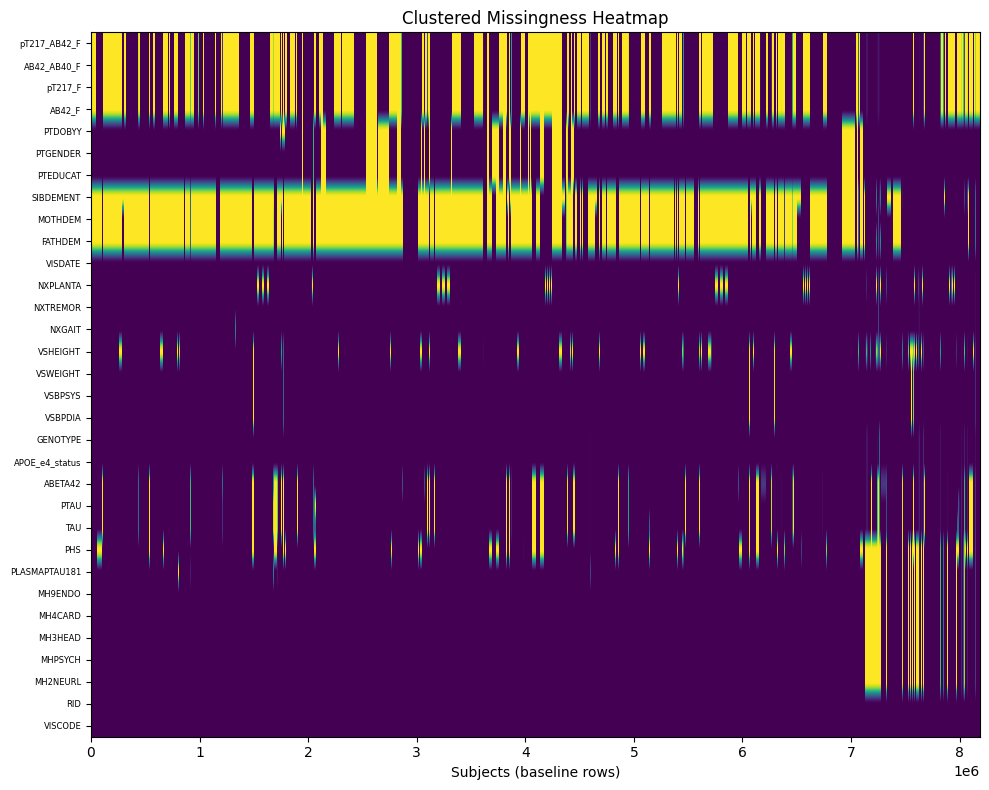

In [6]:
# 1) Extract the cleaned demographics and other datasets
demographics_clean = cleaned_data["demographics"]

# pick exactly the background tables we care about,
# naming them so logs stay informative
datasets = {
    "vitals":                    cleaned_data["vitals"],
    "neuroexam":                 cleaned_data["neuroexam"],
    "plasma_biomarkers":         cleaned_data["plasma_biomarker"],
    "tau":                       cleaned_data["tau"],
    "ptau181":                   cleaned_data["ptau181"],
    "genotype":                  cleaned_data["genotype"],
    "fam_hist_parents":          cleaned_data["family_history_parents"],
    "fam_hist_siblings":         cleaned_data["family_history_siblings"],
    "csf":                       cleaned_data["csf"],
    "genetic":                   cleaned_data["genetic"],
    "medical_history":           cleaned_data["medical_history"],
    "csf_biobank":               cleaned_data["csfbiobank"],
}

# 2) Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# 3) Merge them all onto demographics_clean
background_knowledge = demographics_clean.copy()
for name, df in datasets.items():
    before = background_knowledge.isna().sum().sum()
    background_knowledge = background_knowledge.merge(
        df, on="RID", how="left", suffixes=("", "_dup")
    )
    after = background_knowledge.isna().sum().sum()
    delta = after - before

    # warn if any duplicate‐suffix columns appeared
    dup_cols = [c for c in background_knowledge if c.endswith("_dup")]
    if dup_cols:
        logging.warning(f"‘{name}’ merge left duplicate cols: {dup_cols}")
        background_knowledge.drop(columns=dup_cols, inplace=True)

    logging.info(f"Merged '{name}': missing +{delta}")

# 4) Restrict to baseline and build missingness matrix
baseline = background_knowledge[background_knowledge["VISCODE"] == "bl"]
miss_ind = baseline.isna().astype(int)
miss_corr = miss_ind.corr()

# 5) Rank features by average missingness correlation
avg_miss_corr = (
    (miss_corr.sum() - 1)  # drop self‐corr
    / (miss_corr.shape[0] - 1)
).sort_values(ascending=False)

print("Features by avg. missingness correlation:")
print(avg_miss_corr)

# 6a) Drop zero‐variance features before clustering
# Identify columns whose missing‐indicator is constant
const_cols = [c for c in miss_ind.columns if miss_ind[c].nunique() <= 1]
if const_cols:
    logging.info(f"Dropping {len(const_cols)} constant features (no variability) before clustering: {const_cols}")
# Keep only features with at least two unique values (0 & 1)
to_cluster = miss_ind.drop(columns=const_cols)

# 6b) Perform linkage on the filtered matrix
link = linkage(to_cluster.T, method="average", metric="correlation")
order = leaves_list(link)

# If you want, you can append the constant cols at the bottom of the heatmap:
final_order = list(to_cluster.columns[order]) + const_cols

# 6c) Plot heatmap using this new order
plt.figure(figsize=(10, 8))
plt.imshow(miss_ind[final_order].T, aspect='auto')
plt.yticks(range(len(final_order)), final_order, fontsize=6)
plt.xlabel("Subjects (baseline rows)")
plt.title("Clustered Missingness Heatmap")
plt.tight_layout()
plt.show()



## <center> Step 6: Ensure Required Background Columns & Initialize Missing Data

In this step, we first list out the key family‐history (MOTHDEM, MOTHAD, etc.) and background categorical features (PTGENDER, APOE_e4_status, etc.) that our analysis expects. We then loop over this combined list and, for any feature not already present in the background_knowledge DataFrame, we add it as a new column filled with NaN. This ensures that all downstream code can safely reference these columns without needing to check for their existence.

In [7]:
# Ensure Required Columns Exist and Fill Missing Values for Background Knowledge
family_columns = ["MOTHDEM", "MOTHAD", "FATHDEM", "FATHAD", "SIBDEMENT", "SIBAD"]
background_categorical_columns = ["PTGENDER", "PTNOTRT", "MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH9ENDO", "APOE_e4_status"]
required_cols = family_columns + background_categorical_columns
for col in required_cols:
    if col not in background_knowledge.columns:
        background_knowledge[col] = np.nan

## <center> Setup: Configure Logging & Initialize Feature Metadata Tracking
Here we configure our logging format to include timestamps and log levels for consistent debug output. We also create a global feature_metadata dictionary that will record each feature’s processing history - whether it’s been dropped or imputed, which PCA component it ended up in, its missingness rates before and after imputation, and its cluster assignments from both hierarchical and DBSCAN methods. The helper function init_metadata(features) takes a list of feature names and populates this dictionary with default values so you can update each entry as your pipeline transforms the data.

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# feature_metadata will track each feature’s journey
feature_metadata = {}

def init_metadata(features):
    for f in features:
        feature_metadata[f] = {
            'dropped': False,
            'imputed': False,
            'pca_component': None,
            'missing_before': None,
            'missing_after': None,
            'cluster_hier': None,
            'cluster_dbscan': None
        }

## <center> Step 7: Baseline Filtering, Missingness Analysis & Feature Pruning

This step prepares a clean baseline feature set by restricting the cohort to visits where VISCODE == "bl". We first extract baseline rows into a separate DataFrame and initialize a feature_metadata structure with init_metadata(...) to track missingness and transformations. Pre-drop missingness rates are computed and logged for each feature, then visualized in a bar chart to reveal sparsely populated variables. Features with more than 30% missing data (excluding RID and VISCODE) are flagged, removed, and documented. The dataset is then deduplicated to ensure one unique row per subject, with RID set as the index. Post-drop missingness rates are recomputed and stored, followed by a second visualization showing the improved completeness. This pipeline yields a transparent, well-documented set of baseline features optimized for downstream modeling.

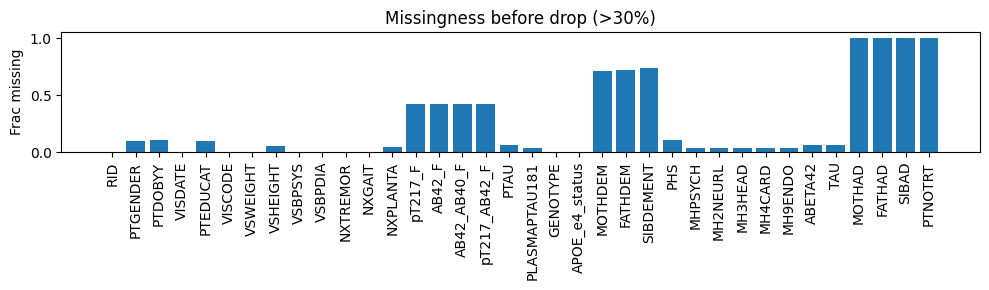

2025-08-25 09:58:51,633 INFO: Dropping 11 features >30% missing at BL: ['pT217_F', 'AB42_F', 'AB42_AB40_F', 'pT217_AB42_F', 'MOTHDEM', 'FATHDEM', 'SIBDEMENT', 'MOTHAD', 'FATHAD', 'SIBAD', 'PTNOTRT']
2025-08-25 09:58:53,605 INFO: Collapsed to unique subjects: 3607 rows


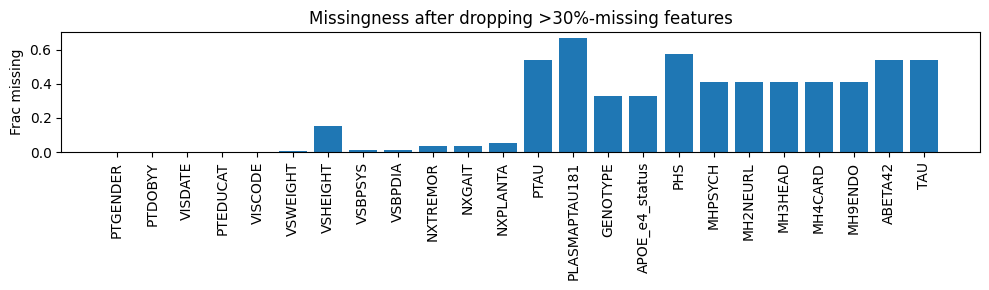

In [9]:
# Filter to baseline
baseline = background_knowledge[background_knowledge["VISCODE"] == "bl"].copy()

# Initialize metadata
init_metadata(baseline.columns)

# Compute & record missing‐rate before
miss_before = baseline.isna().mean()
for f, r in miss_before.items():
    feature_metadata[f]['missing_before'] = float(r)

# Plot missingness before
plt.figure(figsize=(10,3))
plt.bar(baseline.columns, miss_before.values)
plt.xticks(rotation=90); plt.ylabel("Frac missing")
plt.title("Missingness before drop (>30%)"); plt.tight_layout()
plt.show()

# Identify & drop high-missing features
threshold_pct = 30  # percent missing threshold

# compute missing percentage per column at BL
missing_pct = baseline.isna().mean() * 100

# find which columns exceed the threshold (and aren’t RID/VISCODE)
cols_to_drop = [
    c for c, pct in missing_pct.items()
    if pct > threshold_pct and c not in ("RID", "VISCODE")
]

logging.info(
    f"Dropping {len(cols_to_drop)} features >{threshold_pct}% missing at BL: {cols_to_drop}"
)

# use cols_to_drop
baseline_clean = baseline.drop(columns=cols_to_drop)

# Deduplicate so each RID appears exactly once
baseline_clean["RID"] = baseline_clean["RID"].astype(str)
baseline_clean = (
    baseline_clean
      .drop_duplicates(subset=["RID"], keep="first")
      .set_index("RID")
)
logging.info(f"Collapsed to unique subjects: {baseline_clean.shape[0]} rows")

# Compute & record missing-rate after drop
missing_after = baseline_clean.isna().mean()
for f, r in missing_after.items():
    feature_metadata[f]['missing_after'] = float(r)


# Plot missingness after drop
plt.figure(figsize=(10,3))
plt.bar(baseline_clean.columns, missing_after.values)
plt.xticks(rotation=90)
plt.ylabel("Frac missing")
plt.title("Missingness after dropping >30%-missing features")
plt.tight_layout()
plt.show()



## <center> Step 8: Cluster Missingness-Pattern Correlations
In this section, we translate each retained feature into a binary “missingness” indicator (1 for missing, 0 for present), then remove any constant columns (which carry no information for correlation). We compute the Pearson correlation matrix of these indicators to quantify how often features tend to be missing together.

Next, we perform hierarchical clustering on that correlation matrix, using average linkage and correlation distance to order features by similarity of their missing-data patterns. We record each feature’s position in the dendrogram in our feature_metadata dictionary under cluster_hier, and mark dropped constants with a sentinel value.

We then apply DBSCAN on the distance matrix defined as 1 minus the absolute correlation, which groups features into clusters without forcing every one into a hierarchy. Those cluster labels are stored under cluster_dbscan in the metadata (again using –1 for constants or noise).

Finally, we generate a Seaborn clustermap of the missingness correlations, using the same linkage for both rows and columns, to visually inspect how features group together by their patterns of missing values.

2025-08-25 09:58:53,814 INFO: Dropping 3 constant features before clustering: ['PTGENDER', 'VISDATE', 'VISCODE']


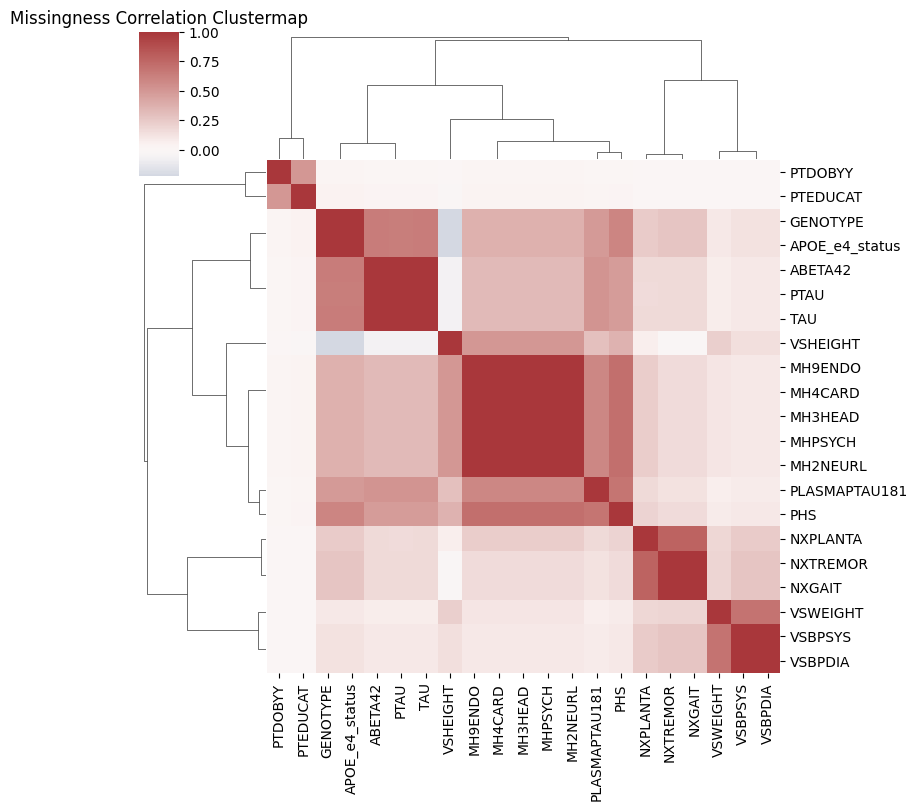

In [10]:
# CLUSTER MISSINGNESS-PATTERN CORRELATIONS

# 1) Build the binary missing-indicator matrix
miss_ind = baseline_clean.isna().astype(int)

# 2) Identify constant columns (no variance - correlation undefined)
const_cols = [c for c in miss_ind.columns if miss_ind[c].nunique() <= 1]
if const_cols:
    logging.info(f"Dropping {len(const_cols)} constant features before clustering: {const_cols}")
# Work on the subset with >1 unique value
miss_ind_clust = miss_ind.drop(columns=const_cols)

# 3) Compute the correlation on the reduced set
miss_corr = miss_ind_clust.corr()

# 4) Hierarchical clustering
link = linkage(miss_corr, method='average', metric='correlation')
order = leaves_list(link)

# Assign hierarchical cluster order
for i, f in enumerate(miss_corr.index[order]):
    feature_metadata[f]['cluster_hier'] = int(i)
# Mark the dropped constants
for f in const_cols:
    feature_metadata[f]['cluster_hier'] = -1

# 5) DBSCAN on distance = 1 – |corr|
dist_mat = 1 - miss_corr.abs()
db = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
labels = db.fit_predict(dist_mat)

for f, lbl in zip(miss_corr.index, labels):
    feature_metadata[f]['cluster_dbscan'] = int(lbl)
# Constants get their own label
for f in const_cols:
    feature_metadata[f]['cluster_dbscan'] = -1

# 6) Visual check with clustermap (only on the clustered subset)
sns.clustermap(
    miss_corr, 
    row_linkage=link, 
    col_linkage=link,
    figsize=(8,8),
    cmap="vlag", 
    center=0
)
plt.title("Missingness Correlation Clustermap")
plt.show()

## <center> Step 9: Merge Diagnosis, Standardize Features, Add Missingness Indicators & Perform MNAR KNN Imputation
In this step, we prepare the static baseline feature set for modeling by first ensuring RID is present for correct merging. We merge diagnosis labels by loading the diagnosis CSV, filtering out missing values, encoding them with a LabelEncoder, and adding the DIAGNOSIS_ENC column. Next, we separate numeric from categorical features (excluding RID and DIAGNOSIS_ENC), standardize numeric columns with a StandardScaler to remove scale effects, and create binary missingness indicators (<feature>_miss) for all features with at least one missing entry. We then perform diagnosis‐stratified KNN imputation: within each diagnostic group, numeric features are imputed via KNN (with fallbacks for all‐NaN columns) and categorical features via mode imputation. Finally, we drop helper columns (diagnosis encoding and missingness flags) to yield final_static, a fully imputed, MNAR‐aware dataset ready for modeling, with logs tracking each stage.

In [11]:
# 0) Make sure RID is a column, not the index
df = baseline_clean.copy()
if df.index.name == "RID" or 'RID' not in df.columns:
    df = df.reset_index()

# now df has a “RID” column we can work with:
df['RID'] = df['RID'].astype(str)

# 1) Merge in diagnosis
diag = (
    pd.read_csv(diagnosis_file, usecols=['RID','DIAGNOSIS'], dtype={'RID':str})
      .dropna(subset=['DIAGNOSIS'])
      .drop_duplicates(subset=['RID'])
)
le = LabelEncoder()
diag['DIAGNOSIS_ENC'] = le.fit_transform(diag['DIAGNOSIS'].astype(str))

df = df.merge(
    diag[['RID','DIAGNOSIS_ENC']],
    on='RID',
    how='left'
)
logging.info(f"Merged diagnosis: now df.shape = {df.shape}")

# 2) Identify numeric vs categorical
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns
                if c != 'DIAGNOSIS_ENC']
categorical_cols = [c for c in df.columns
                    if c not in numeric_cols + ['RID','DIAGNOSIS_ENC']]

# 3) Standardize numeric BEFORE imputation
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
logging.info("Numeric features standardized.")

# 4) Add MNAR indicators
for col in numeric_cols + categorical_cols:
    miss_col = f"{col}_miss"
    df[miss_col] = df[col].isna().astype(int)
    if df[miss_col].sum() > 0:
        logging.info(f"Added missingness indicator '{miss_col}' (n_missing={df[miss_col].sum()})")

extended_num = numeric_cols + [f"{c}_miss" for c in numeric_cols]
extended_cat = categorical_cols + [f"{c}_miss" for c in categorical_cols]

# 5) Diagnosis‐specific MNAR KNN‐imputation
def impute_mnar(df, num_feats, cat_feats, diag_col='DIAGNOSIS_ENC', k=10):
    out = df.copy()
    for val in out[diag_col].dropna().unique():
        ids   = out[out[diag_col]==val].index
        block = out.loc[ids, num_feats].copy()
        # avoid all‐NaNs
        for c in block.columns:
            if block[c].isna().all():
                block[c] = 0
        imp = KNNImputer(n_neighbors=k)
        filled = pd.DataFrame(imp.fit_transform(block), index=ids, columns=block.columns)
        out.loc[ids, num_feats] = filled
        # mode‐impute categoricals
        for c in cat_feats:
            m = out.loc[ids, c].mode()
            if not m.empty:
                out.loc[ids, c] = out.loc[ids, c].fillna(m.iloc[0])
    return out

df_imputed = impute_mnar(df, extended_num, extended_cat, k=10)

# 6) Drop helpers - final_static
final_static = (
    df_imputed
      .drop(columns=['DIAGNOSIS_ENC'] 
            + [f"{c}_miss" for c in numeric_cols + categorical_cols],
            errors='ignore')
      .reset_index(drop=True)
)

logging.info("Baseline‐static MNAR imputation complete. final_static.shape = %s", final_static.shape)

2025-08-25 09:58:54,314 INFO: Merged diagnosis: now df.shape = (3607, 26)
2025-08-25 09:58:54,328 INFO: Numeric features standardized.
2025-08-25 09:58:54,332 INFO: Added missingness indicator 'PTDOBYY_miss' (n_missing=1)
2025-08-25 09:58:54,332 INFO: Added missingness indicator 'PTEDUCAT_miss' (n_missing=4)
2025-08-25 09:58:54,333 INFO: Added missingness indicator 'VSWEIGHT_miss' (n_missing=32)
2025-08-25 09:58:54,333 INFO: Added missingness indicator 'VSHEIGHT_miss' (n_missing=548)
2025-08-25 09:58:54,336 INFO: Added missingness indicator 'VSBPSYS_miss' (n_missing=48)
2025-08-25 09:58:54,336 INFO: Added missingness indicator 'VSBPDIA_miss' (n_missing=48)
2025-08-25 09:58:54,338 INFO: Added missingness indicator 'NXTREMOR_miss' (n_missing=121)
2025-08-25 09:58:54,339 INFO: Added missingness indicator 'NXGAIT_miss' (n_missing=122)
2025-08-25 09:58:54,340 INFO: Added missingness indicator 'NXPLANTA_miss' (n_missing=197)
2025-08-25 09:58:54,342 INFO: Added missingness indicator 'PTAU_mis

## <center> Step 10: Export Feature Preprocessing Metadata

In this final step, we consolidate all of the per-feature tracking information kept in the feature_metadata dictionary into a single pandas DataFrame (meta_df), with one row per feature. We then write this table out to both CSV and JSON formats (feature_preprocessing_metadata.csv and feature_preprocessing_metadata.json), providing a complete record of which features were dropped or imputed, their missingness rates before and after pruning, and any cluster assignments. A final log message confirms that the static preprocessing phase is fully complete and that your metadata files have been written to disk.

In [12]:
# EXPORT METADATA LOG
meta_df = pd.DataFrame.from_dict(feature_metadata, orient='index')
meta_df.index.name = 'feature'
meta_df.to_csv("feature_preprocessing_metadata.csv")
with open("feature_preprocessing_metadata.json", "w") as f:
    json.dump(feature_metadata, f, indent=2)

logging.info("Static preprocessing complete. Metadata written to CSV/JSON.")

2025-08-25 09:58:54,806 INFO: Static preprocessing complete. Metadata written to CSV/JSON.


## <center> Step 11: Process Longitudinal Modalities: VISCODE Mapping, Imputation, PCA & Embeddings
This block implements a complete preprocessing pipeline for longitudinal clinical modalities such as MRI and PET. It standardizes visit codes by mapping VISCODE values to numeric months, adding a sortable VISCODE_numeric column, and normalizing PET-specific codes. Missing data is addressed with conditional forward fill, which carries values forward only if diagnosis is unchanged, followed by group-mean (numeric) and mode (categorical) imputation within diagnosis groups. The workflow then concatenates modality DataFrames, merges diagnosis labels, separates numeric and categorical features, and applies imputation. Numeric features are standardized, reduced with PCA (retaining 91% variance), and labeled with custom component names. For visualization, 2D embeddings are generated using UMAP and openTSNE, with results saved to CSV along with PCA loadings, explained variance tables, and serialized scaler/PCA objects. Example usage shows MRI and PET processed independently, producing per-visit PCA features and embeddings. This unified pipeline ensures consistent handling, imputation, dimensionality reduction, and visualization across longitudinal modalities.

In [ ]:
# Mapping for VISCODE ordering.
order_mapping = {
    "bl": 0, "m06": 6, "m12": 12, "m18": 18, "m24": 24, "m30": 30,
    "m36": 36, "m42": 42, "m48": 48, "m54": 54, "m60": 60, "m66": 66,
    "m72": 72, "m78": 78, "m84": 84
}

def add_numeric_viscode(df):
    """
    Add a numeric representation of visit codes for sorting and computation.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame must contain a 'VISCODE' column with string visit codes
        (e.g., 'bl', 'm06', 'y1', etc.).

    Returns
    -------
    pandas.DataFrame
        A copy of the input DataFrame with:
        - 'VISCODE' normalized to lowercase and stripped of whitespace.
        - A new 'VISCODE_numeric' column mapping each code to its month integer
          equivalent (using the global `order_mapping` dict).
    """
    df = df.copy()
    df["VISCODE"] = df["VISCODE"].str.lower().str.strip()
    df["VISCODE_numeric"] = df["VISCODE"].map(order_mapping)
    return df

def conditional_forward_fill_modality(df, diagnosis_col):
    """
    Forward-fill missing values within each subject and diagnosis group.

    For each subject (grouped by 'RID'), sort by ascending 'VISCODE_numeric'.
    Then, for each pair of consecutive visits, if the diagnosis is unchanged,
    fill any missing entries in the later visit with values from the earlier one.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame must contain columns 'RID', 'VISCODE_numeric',
        and the specified diagnosis column.
    diagnosis_col : str
        Name of the column indicating diagnosis. Forward-fill only occurs
        when diagnosis for the current visit matches the previous visit.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame where missing values have been conditionally
        forward-filled within each subject’s time series.
    """
    def fill_group(g):
        g = g.sort_values("VISCODE_numeric")
        out = g.copy()
        for i in range(1, len(out)):
            if out.iloc[i][diagnosis_col] == out.iloc[i-1][diagnosis_col]:
                out.iloc[i] = out.iloc[i].fillna(out.iloc[i-1])
        return out
    return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)

def group_mean_impute(df, diagnosis_col, feature_cols):
    """
    Impute missing feature values using the group mean per diagnosis.

    For each feature in `feature_cols`, replace missing entries by the mean
    of that feature computed over subjects sharing the same diagnosis.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame which must contain the `diagnosis_col` and the
        specified feature columns.
    diagnosis_col : str
        Column name indicating group membership (e.g., diagnosis label).
    feature_cols : list of str
        List of feature column names to be mean-imputed.

    Returns
    -------
    pandas.DataFrame
        A copy of the DataFrame with missing values in `feature_cols` filled
        by their group-specific means.
    """
    df = df.copy()
    for feat in feature_cols:
        df[feat] = df.groupby(diagnosis_col)[feat] \
                     .transform(lambda x: x.fillna(x.mean()))
    return df

def translate_pet_viscode(vis):
    """
    Normalize PET-specific visit codes to the standard monthly format.

    Parameters
    ----------
    vis : str or any
        The original visit code, which may be in various legacy formats
        (e.g., 'init', 'sc', 'y1', 'v03', etc.).

    Returns
    -------
    str
        The mapped visit code:
        - 'init' and 'sc' - 'bl'
        - 'yN' - 'm{N*12}' (e.g., 'y1' - 'm12', 'y2' - 'm24', etc.)
        - legacy 'vXX' codes translated to their corresponding monthly values
          (per the defined mapping)
        - any unrecognized code is returned unchanged
    """
    vis = str(vis).lower().strip()
    mapping = {
        "init": "bl", "sc": "bl", "y1": "m12", "y2": "m24", "y3": "m36",
        "y4": "m48", "y5": "m60", "v03": "m12", "v06": "m24",
        "v21": "m24", "v41": "m48"
    }
    return mapping.get(vis, vis)

def process_modalities_clinical(
    datasets,
    diagnosis_info,
    name,
    pca_prefix=None,
    categorical_features=None,
    umap_neighbors=10,
    umap_min_dist=0.2,
    tsne_perplexity=30,
    tsne_n_jobs=4
):
    """
    1) Merge datasets + add numeric VISCODE
    2) Forward-fill + group-mean/mode impute
    3) Scale - PCA (91% var) - UMAP - openTSNE
    4) Persist artifacts & return DataFrames
    """
    print(f"\nProcessing {name}…")

    # Merge + diagnosis + VISCODE
    df = pd.concat(datasets, ignore_index=True)
    df["RID"] = df["RID"].astype(str)
    df = df.merge(diagnosis_info[["RID","DIAGNOSIS"]], on="RID", how="left")
    df = add_numeric_viscode(df)

    # Identify numeric features
    num_feats = [c for c in df.select_dtypes(include=[np.number]).columns
                 if c not in ("RID","DIAGNOSIS")]
    if categorical_features:
        num_feats = [c for c in num_feats if c not in categorical_features]

    feats = num_feats + (categorical_features or [])
    proc = df[["RID","VISCODE","DIAGNOSIS"] + feats].copy()

    # Imputation
    proc = conditional_forward_fill_modality(proc, "DIAGNOSIS")
    proc = group_mean_impute(proc, "DIAGNOSIS", num_feats)
    if categorical_features:
        for diag in proc["DIAGNOSIS"].unique():
            mask = proc["DIAGNOSIS"] == diag
            for col in categorical_features:
                m = proc.loc[mask, col].mode()
                if not m.empty:
                    proc.loc[mask, col] = proc.loc[mask, col].fillna(m.iloc[0])

    # Drop helpers
    proc.drop(columns=["VISCODE_numeric","DIAGNOSIS"], inplace=True)

    # Numeric matrix
    num_df = proc.drop(columns=["RID","VISCODE"] + (categorical_features or []))
    num_df.fillna(num_df.mean(), inplace=True)
    const_cols = num_df.columns[num_df.nunique() <= 1]
    if len(const_cols):
        print(f"Dropping constant cols in {name}: {list(const_cols)}")
        num_df.drop(columns=const_cols, inplace=True)
    original_feats = num_df.columns.tolist()

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(num_df)

    # PCA
    pca = PCA(n_components=0.91, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    comps = [f"{pca_prefix or name + '_PCA_'}{i+1}" for i in range(X_pca.shape[1])]
    pca_df = pd.DataFrame(X_pca, index=num_df.index, columns=comps)
    print(f"{name} PCA → shape {pca_df.shape}")

    # re-attach RID + VISCODE
    vis_info = df.loc[num_df.index, ["RID","VISCODE"]].reset_index(drop=True)
    pca_visits_df = pd.concat([vis_info,
                           pca_df.reset_index(drop=True)], axis=1)

    # UMAP
    umapper = UMAP(n_components=2,
                   n_neighbors=umap_neighbors,
                   min_dist=umap_min_dist,
                   random_state=42)
    umap_emb = umapper.fit_transform(X_pca)
    umap_df = pd.DataFrame(umap_emb, index=num_df.index,
                           columns=["UMAP1","UMAP2"])
    umap_df["diagnosis"] = df.loc[num_df.index, "DIAGNOSIS"].values
    umap_df.to_csv(f"{name.lower()}_UMAP_embedding.csv", index=False)

    # openTSNE
    tsne = oTSNE(n_components=2,
                 perplexity=tsne_perplexity,
                 n_jobs=tsne_n_jobs,
                 random_state=42)
    tsne_emb = tsne.fit(X_pca)
    tsne_df = pd.DataFrame(tsne_emb, index=num_df.index,
                           columns=["TSNE1","TSNE2"])
    tsne_df["diagnosis"] = df.loc[num_df.index, "DIAGNOSIS"].values
    tsne_df.to_csv(f"{name.lower()}_TSNE_embedding.csv", index=False)

    # Persist artifacts
    joblib.dump(scaler, f"{name.lower()}_scaler.joblib")
    joblib.dump(pca,    f"{name.lower()}_pca.joblib")

        # Save loadings and explained variance
    loadings_df = pd.DataFrame(
        pca.components_.T,
        index=num_df.columns,
        columns=comps
    )
    loadings_df.to_csv(f"{name.lower()}_pca_loadings.csv")

    var_ratio = pd.Series(
        pca.explained_variance_ratio_,
        index=comps,
        name="explained_variance_ratio"
    )
    cum_var = var_ratio.cumsum().rename("cumulative_variance")
    pd.concat([var_ratio, cum_var], axis=1).to_csv(f"{name.lower()}_pca_variance.csv")

    return pca_visits_df, pca, scaler, original_feats, umap_df, tsne_df


# Load & clean diagnosis
subject_diagnosis = (
    pd.read_csv(diagnosis_file, usecols=["RID","DIAGNOSIS"], dtype={"RID":str})
      .dropna(subset=["DIAGNOSIS"])
      .drop_duplicates(subset=["RID"], keep="first")
)
gen_diagnosis_df = subject_diagnosis[["RID","DIAGNOSIS"]].copy()

# Translate PET visit codes
for pet_df in (PETamy_data, av45PET_data,
               pet_amyloid_detailed_data):
    pet_df["VISCODE"] = pet_df["VISCODE"].apply(translate_pet_viscode)

# Run MRI pipeline
mri_pca_df, pca_mri, scaler_mri, mri_feats, mri_umap, mri_tsne = \
    process_modalities_clinical(
        datasets=[ucsfFreesurferMRI_data, FoxLabMRI_data, MRIcomprehensive_data],
        diagnosis_info=gen_diagnosis_df,
        name="MRI",
        pca_prefix="MRI_PCA_",
        categorical_features=[
            "BASETP1","BASETP2","BASETP3","BASETP4",
            "BASETP5","BASETP6","BASETP7","BASETP8"
        ],
        umap_neighbors=10,
        umap_min_dist=0.2,
        tsne_perplexity=30,
        tsne_n_jobs=4
    )

# Run PET pipeline
pet_pca_df, pca_pet, scaler_pet, pet_feats, pet_umap, pet_tsne = \
    process_modalities_clinical(
        datasets=[PETamy_data, av45PET_data,
                  pet_amyloid_detailed_data],
        diagnosis_info=gen_diagnosis_df,
        name="PET",
        pca_prefix="PET_PCA_",
        umap_neighbors=10,
        umap_min_dist=0.2,
        tsne_perplexity=30,
        tsne_n_jobs=4
    )

print("MRI PCA shape:", mri_pca_df.shape)
print("PET PCA shape:", pet_pca_df.shape)


Processing MRI…


C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\2976259367.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)


Dropping constant cols in MRI: ['ST100SV', 'ST122SV', 'ST126SV', 'ST22CV', 'ST22SA', 'ST22TA', 'ST22TS', 'ST28CV', 'ST33SV', 'ST41SV', 'ST63SV', 'ST67SV', 'ST81CV', 'ST81SA', 'ST81TA', 'ST81TS', 'ST87CV', 'ST92SV']
MRI PCA → shape (24132, 111)


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
2025-08-25 10:10:04,014 INFO: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-08-25 10:10:04,035 INFO: Automatically d


Processing PET…


C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\2976259367.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("RID", group_keys=False).apply(fill_group).reset_index(drop=True)


Dropping constant cols in PET: ['GAAIN_WHOLECEREBELLUM_SUVR', 'NPDKA_WHOLECEREBELLUM_SUVR']
PET PCA → shape (10754, 20)


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2025-08-25 10:12:44,706 INFO: Precomputed initialization provided. Ignoring initalization-related parameters.
2025-08-25 10:12:44,710 INFO: Automatically determined negative gradient method `fft`
2025-08-25 10:12:47,985 INFO: Automatically determined negative gradient method `fft`


MRI PCA shape: (24132, 113)
PET PCA shape: (10754, 22)


## <center> Utility: Standardize IDs & VISCODE Across All Tables
This block enforces consistent subject and visit identifiers across all DataFrames before merging or analysis. The standardize_ids function converts RID values to strings and strips whitespace to avoid hidden mismatches, while standardize_viscode lowercases and trims VISCODE entries so they align with the expected set (e.g., "bl", "m06"). A helper mapping viscode_to_order translates visit codes into numeric months for sorting and plotting. All modality and assessment DataFrames are collected into a list, standardized in a loop, and then reassigned back to their original variables (including PCA-processed MRI and PET). This ensures every dataset downstream uses the same ID and visit-code conventions, eliminating alignment errors.

In [14]:
# Utility: Standardize ID and VISCODE Formats
def standardize_ids(df, id_col="RID"):
    """Normalize subject IDs: convert to string and strip whitespace."""
    df[id_col] = df[id_col].astype(str).str.strip()
    return df

def standardize_viscode(df, vis_col="VISCODE"):
    """Normalize VISCODE: lowercase and strip whitespace."""
    df[vis_col] = df[vis_col].astype(str).str.lower().str.strip()
    return df

def viscode_to_order(vis):
    """Map VISCODE to its numeric month equivalent; unknown codes become NaN."""
    mapping = {
        "bl": 0, "m06": 6, "m12": 12, "m18": 18, "m24": 24, "m30": 30,
        "m36": 36, "m42": 42, "m48": 48, "m54": 54, "m60": 60, "m66": 66,
        "m72": 72, "m78": 78, "m84": 84
    }
    return mapping.get(vis, np.nan)

datasets = [adas1_data, adasGO23_data, moca_data, adspCognitive_data, embicCognitive_data,
            embicDigital_data, faq_data, mmse_data, neurobattery_data, neuroexam_data,
            npiq_data, GutMetabolites_data, mri_pca_df, pet_pca_df,
            GeriatricDepressionScale_data, lipidomics_data, lipoproteins_data, ravlt_data]

for i, df in enumerate(datasets):
    df = standardize_ids(df, "RID")
    if "VISCODE" in df.columns:
        df = standardize_viscode(df, "VISCODE")
    datasets[i] = df

(adas1_data, adasGO23_data, moca_data, adspCognitive_data, embicCognitive_data,
 embicDigital_data, faq_data, mmse_data, neurobattery_data, neuroexam_data,
 npiq_data, GutMetabolites_data, mri_pca_visits_df, pet_pca_visits_df,
 lipidomics_data, lipoproteins_data, GeriatricDepressionScale_data, ravlt_data) = datasets


## <center> Step 12: Aggregate ADAS Time-Series Targets

This step unifies ADAS-Cog summary scores across visits by standardizing subtest processing and visit codes. First, all subtest columns are cast to numeric, with non-numeric or missing entries replaced by 0. For ADAS-Cog 11, we sum the 11 core items; for ADAS-Cog 13, we add the two extended items. The same procedure is applied to ADAS-GO/ADNIGO-2/3, summing Q1–Q11 for ADAS_11 and adding Q12–Q13 for ADAS_13. We then concatenate the resulting datasets, retaining only RID, VISCODE, ADAS_11, and ADAS_13, and normalize VISCODE formatting by lowercasing and trimming. Finally, we print unique VISCODE values to confirm correct timepoint mapping, ensuring a clean, consistent table of longitudinal ADAS-Cog summary scores.

In [ ]:
adas1_numeric_cols = [
    'COT1SCOR', 'COT2SCOR', 'COT3SCOR', 'CONAME', 'COCOMND',
    'COCONSTR', 'COIDEA', 'COORIEN', 'COWRDFND', 'COINSTRC', 'COLANG', 'COCOMPRE'
]
for col in adas1_numeric_cols:
    adas1_data[col] = pd.to_numeric(adas1_data[col], errors='coerce').fillna(0)
adas1_data['ADAS_11'] = adas1_data[adas1_numeric_cols].sum(axis=1)
adas1_extra_cols = ['COT4TOTL', 'COP14CMP']
for col in adas1_extra_cols:
    adas1_data[col] = pd.to_numeric(adas1_data[col], errors='coerce').fillna(0)
adas1_data['ADAS_13'] = adas1_data['ADAS_11'] + adas1_data[adas1_extra_cols].sum(axis=1)

adasGO23_numeric_cols = [
    'Q1SCORE', 'Q2SCORE', 'Q3SCORE', 'Q4SCORE', 'Q5SCORE_CUE',
    'Q6SCORE', 'Q7SCORE', 'Q8SCORE', 'Q9SCORE', 'Q10SCORE', 'Q11SCORE'
]
for col in adasGO23_numeric_cols:
    adasGO23_data[col] = pd.to_numeric(adasGO23_data[col], errors='coerce').fillna(0)
adasGO23_data['ADAS_11'] = adasGO23_data[adasGO23_numeric_cols].sum(axis=1)
adasGO23_extra_cols = ['Q12SCORE', 'Q13SCORE']
for col in adasGO23_extra_cols:
    adasGO23_data[col] = pd.to_numeric(adasGO23_data[col], errors='coerce').fillna(0)
adasGO23_data['ADAS_13'] = adasGO23_data['ADAS_11'] + adasGO23_data[adasGO23_extra_cols].sum(axis=1)

adas_combined = pd.concat([
    adas1_data[['RID', 'VISCODE', 'ADAS_11', 'ADAS_13']],
    adasGO23_data[['RID', 'VISCODE', 'ADAS_11', 'ADAS_13']]
], ignore_index=True)
adas_combined = standardize_viscode(adas_combined, "VISCODE")
print("Unique VISCODE in ADAS data (progression):", adas_combined["VISCODE"].unique())

Unique VISCODE in ADAS data (progression): ['bl' 'm06' 'm24' 'm12' 'm48' 'm18' 'uns1' 'm36' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau']


## <center> Step 13: Merge Longitudinal Assessments into a Unified Table
We construct the longitudinal dataset by using the CDR table as the backbone. First, we clean participant IDs (RID) by converting them to strings and stripping whitespace, then check the initial shape and unique visit codes. We then gather a set of additional time-series sources, including FAQ, MMSE, neuropsychological batteries, ADAS scores, PCA embeddings for PET and MRI, metabolomics, and other clinical or cognitive measures. Each dataset is processed by standardizing RID and VISCODE formats, removing duplicates on RID and VISCODE to prevent inflated rows, and logging its shape and visit codes after deduplication. The dataset is then merged into the evolving merged_data table through an outer join, with updated shapes and visit codes checked at each step. Once all sources have been merged, the combined table is filtered to include only participants with at least one baseline record (VISCODE == "bl"), ensuring every subject in the final longitudinal dataset has a consistent starting point at baseline.

In [16]:
# Merge Time-Series Datasets
cdr_data["VISCODE"] = cdr_data["VISCODE"]
merged_data = cdr_data.copy()
merged_data["RID"] = merged_data["RID"].astype(str).str.strip()
print("=== BEFORE MERGES ===")
print("merged_data shape:", merged_data.shape)
print("merged_data VISCODE unique:", merged_data["VISCODE"].unique())

datasets_to_merge = [
    ("faq_data", faq_data, ["RID", "VISCODE"]),
    ("mmse_data", mmse_data, ["RID", "VISCODE"]),
    ("neurobattery_data", neurobattery_data, ["RID", "VISCODE"]),
    ("neuroexam_data", neuroexam_data, ["RID", "VISCODE"]),
    ("npiq_data", npiq_data, ["RID", "VISCODE"]),
    ("adas_data", adas_combined, ["RID", "VISCODE"]),
    ("moca_data", moca_data, ["RID", "VISCODE"]),
    ("pet_pca", pet_pca_visits_df, ["RID", "VISCODE"]),
    ("mri_pca", mri_pca_visits_df, ["RID", "VISCODE"]),
    ("adspCognitive_data", adspCognitive_data, ["RID", "VISCODE"]),
    ("embicCognitive_data", embicCognitive_data, ["RID", "VISCODE"]),
    ("embicDigital_data", embicDigital_data, ["RID", "VISCODE"]),
    ("GutMetabolites_data", GutMetabolites_data, ["RID", "VISCODE"]),
    ("lipidomics_data", lipidomics_data, ["RID", "VISCODE"]),
    ("lipoproteins_data", lipoproteins_data, ["RID", "VISCODE"]),
    ("GeriatricDepressionScale_data", GeriatricDepressionScale_data, ["RID", "VISCODE"]),
    ("ravlt_data", ravlt_data, ["RID", "VISCODE"])
]

for name, df, keys in datasets_to_merge:
    df["RID"] = df["RID"].astype(str).str.strip()
    if "VISCODE" in df.columns:
        df["VISCODE"] = df["VISCODE"].astype(str).str.lower().str.strip()
    df = df.drop_duplicates(subset=keys)
    print(f"--- Merging: {name} ---")
    print(f"{name} shape (after deduplication):", df.shape)
    print(f"{name} VISCODE unique:", df["VISCODE"].unique())
    merged_data = merged_data.merge(df, on=keys, how="outer")
    print(f"After merging with {name}, merged_data shape:", merged_data.shape)
    print("merged_data VISCODE unique:", merged_data["VISCODE"].unique())

rids_with_baseline = merged_data.loc[merged_data["VISCODE"] == "bl", "RID"].unique()
merged_data = merged_data[merged_data["RID"].isin(rids_with_baseline)]
print("After baseline filter (participants), shape =", merged_data.shape)

=== BEFORE MERGES ===
merged_data shape: (13866, 3)
merged_data VISCODE unique: ['bl' 'f' 'm06' 'm12' 'm36' 'm18' 'uns1' 'm24' 'm48' 'm60' 'm72' 'v05'
 'v31' 'v51' '4_m12']
--- Merging: faq_data ---
faq_data shape (after deduplication): (10967, 3)
faq_data VISCODE unique: ['bl' 'm06' 'm12' 'm18' 'uns1' 'm24' 'm36' 'm48' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau' '4_m12']
After merging with faq_data, merged_data shape: (14694, 4)
merged_data VISCODE unique: ['bl' 'm06' 'm12' 'm24' 'f' '4_m12' 'm36' 'm18' 'm60' 'm48' 'v31' 'v51'
 'm72' 'uns1' 'v05' 'tau']
--- Merging: mmse_data ---
mmse_data shape (after deduplication): (12103, 3)
mmse_data VISCODE unique: ['bl' 'f' 'm06' 'm12' 'm18' 'm36' 'm24' 'm48' 'm60' 'm72' 'v05' 'v31'
 'v51' 'tau' '4_m12']
After merging with mmse_data, merged_data shape: (15065, 5)
merged_data VISCODE unique: ['f' 'bl' 'm06' 'm12' 'm24' '4_m12' 'm36' 'm18' 'm60' 'm48' 'v31' 'v51'
 'm72' 'uns1' 'v05' 'tau']
--- Merging: neurobattery_data ---
neurobattery_data shape (afte

## <center> Step 14: Filter Subjects by Clinical Trajectory and Minimum Visits
In this step, we narrow our cohort to participants whose clinical progression follows a valid, non‐regressive trajectory and who have at least a minimum number of visits. We define filter_subjects_by_trajectory, which first ensures every RID and diagnosis label are present, merging in diagnosis info if needed. For each subject, we restrict to visits in our expected time‐order map (baseline, 6 m, 12 m, …), sort them chronologically, and extract their diagnosis sequence. We then apply three filters: the subject must have at least the specified number of visits; their diagnosis labels must never “go backwards” (e.g., from dementia back to mild cognitive impairment); and they must not represent the uninformative pattern of jumping directly from normal (0) to dementia (2) without any intermediate visit in category 1. Any subject passing all tests is retained. Finally, we overwrite merged_data with only those valid subjects and report the new table shape.

In [17]:
# Subject Selection Based on Clinical Trajectory and Minimum Number of Visits
def filter_subjects_by_trajectory(df, min_visits=2, diagnosis_col="DIAGNOSIS"):
    """
    Retain subjects whose diagnosis progresses monotonically over time
    and who have at least a minimum number of visits.

    Parameters
    ----------
    df : pandas.DataFrame
        Longitudinal dataset containing 'RID', 'VISCODE', and diagnosis columns.
    min_visits : int, default=2
        Minimum number of visits a subject must have to be included.
    diagnosis_col : str, default="DIAGNOSIS"
        Name of the column indicating diagnosis level (e.g., 0, 1, 2).

    Returns
    -------
    pandas.DataFrame
        Subset of `df` with only those `RID`s that:
        - Have at least `min_visits` visits.
        - Never exhibit a backward change in diagnosis.
        - Do not jump directly from normal (0) to dementia (2) without intermediate visits.
    """
    df['RID'] = df['RID'].astype(str)
    subject_diag = subject_diagnosis.copy()
    subject_diag['RID'] = subject_diag['RID'].astype(str)
    if diagnosis_col not in df.columns:
        print(f"Diagnosis column '{diagnosis_col}' not found in df; attempting to merge from subject_diagnosis.")
        df = df.merge(subject_diag[['RID', diagnosis_col]], on='RID', how='left')
    diagnosis_cols = [col for col in df.columns if "DIAGNOSIS" in col]
    if len(diagnosis_cols) > 1:
        diagnosis_col = diagnosis_cols[0]
        print("Multiple diagnosis columns found. Using:", diagnosis_col)
    expected_order = {"bl": 0, "m06": 1, "m12": 2, "m18": 3, "m24": 4, "m30": 5,
                      "m36": 6, "m42": 7, "m48": 8, "m54": 9, "m60": 10, "m66": 11,
                      "m72": 12, "m78": 13, "m84": 14}
    valid_rids = []
    for rid, group in df.groupby("RID"):
        group = group[group["VISCODE"].isin(expected_order.keys())].dropna(subset=[diagnosis_col])
        if group.empty:
            continue
        group = group.copy()
        group["visit_order"] = group["VISCODE"].map(expected_order)
        group.sort_values("visit_order", inplace=True)
        trajectory = group[diagnosis_col].tolist()
        if len(trajectory) < min_visits:
            continue
        if any(prev > curr for prev, curr in zip(trajectory, trajectory[1:])):
            continue
        if trajectory[0] == 0 and trajectory[-1] == 2 and (1 not in trajectory):
            continue
        valid_rids.append(rid)
    filtered_df = df[df["RID"].isin(valid_rids)].copy()
    return filtered_df

merged_data = filter_subjects_by_trajectory(merged_data, min_visits=2, diagnosis_col="DIAGNOSIS")
print("After clinical trajectory filtering, merged_data shape =", merged_data.shape)

Diagnosis column 'DIAGNOSIS' not found in df; attempting to merge from subject_diagnosis.
After clinical trajectory filtering, merged_data shape = (24459, 323)


## <center> Step 15: Drop High-Missing Features & Impute Time-Series Data
We standardize common missing‐value placeholders to np.nan, exclude all MRI/PET PCA features, then apply a diagnosis‐conditional forward‐fill (using DIAGNOSIS_ENC when present or a simple group forward‐fill otherwise) before computing detailed missingness diagnostics, a heatmap of missing vs. present values, a bar chart of percent missing per feature, and a dendrogram of feature missingness correlations, while initializing a metadata log with the initial shape, standardized indicators, excluded features, and missing percentages; next we calculate and record pre‐drop missingness, plot it, and drop any non‐target feature exceeding 30 % missing; we then add an inter‐visit interval column based on actual dates, split features into numeric and categorical sets, perform diagnosis‐group mean imputation for numeric features and mode imputation for categoricals, remove the DIAGNOSIS_ENC helper, standard‐scale all remaining numeric columns (except RID), and finally export the complete preprocessing log as JSON.

Standardized common missing value indicators to np.nan.
Completed diagnosis-conditional forward-fill.


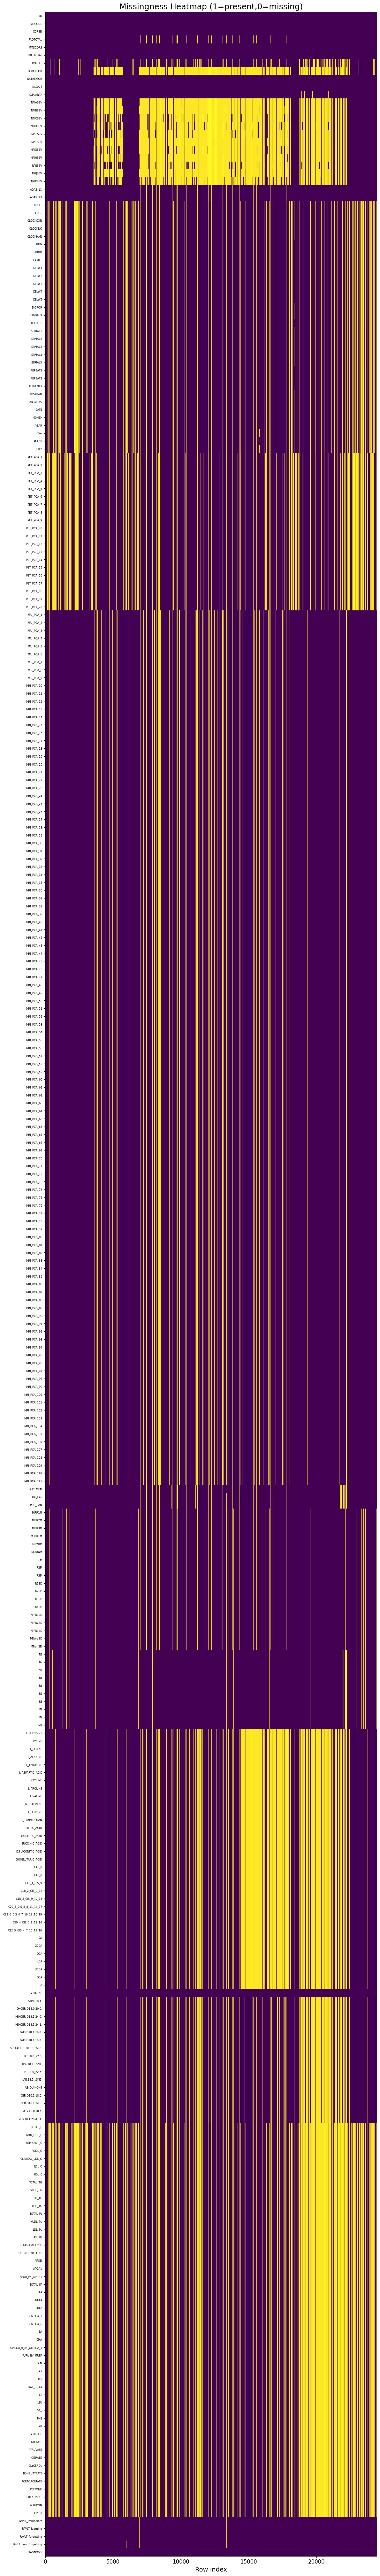

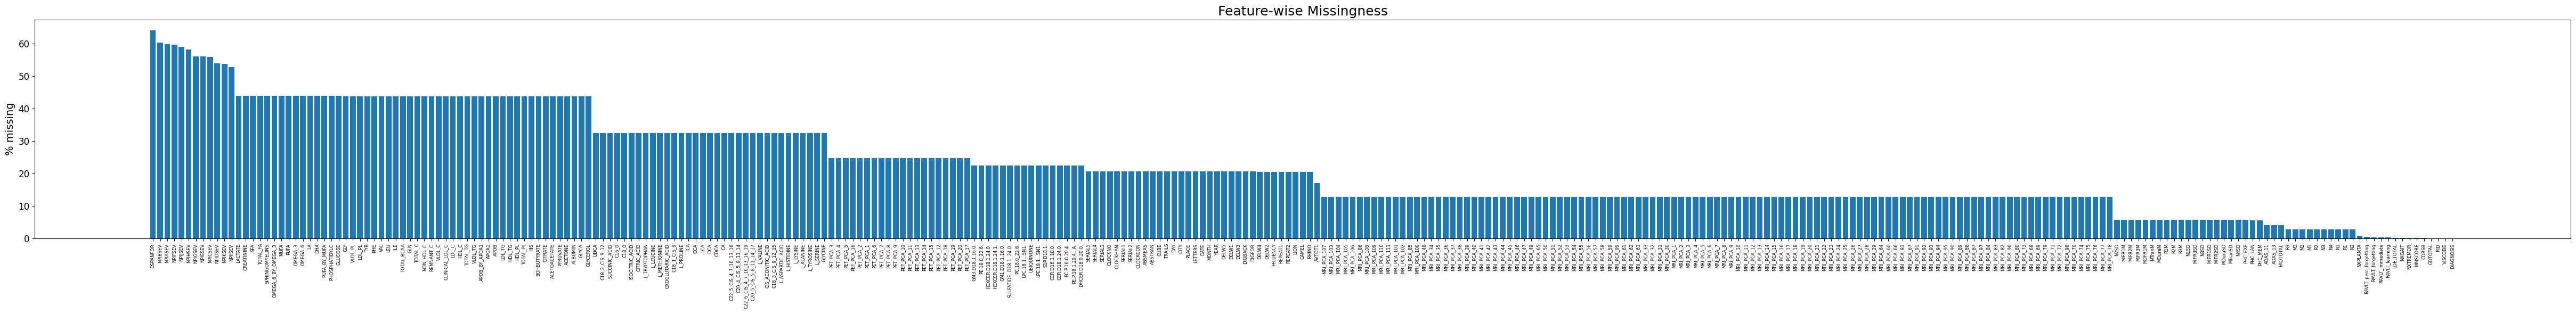

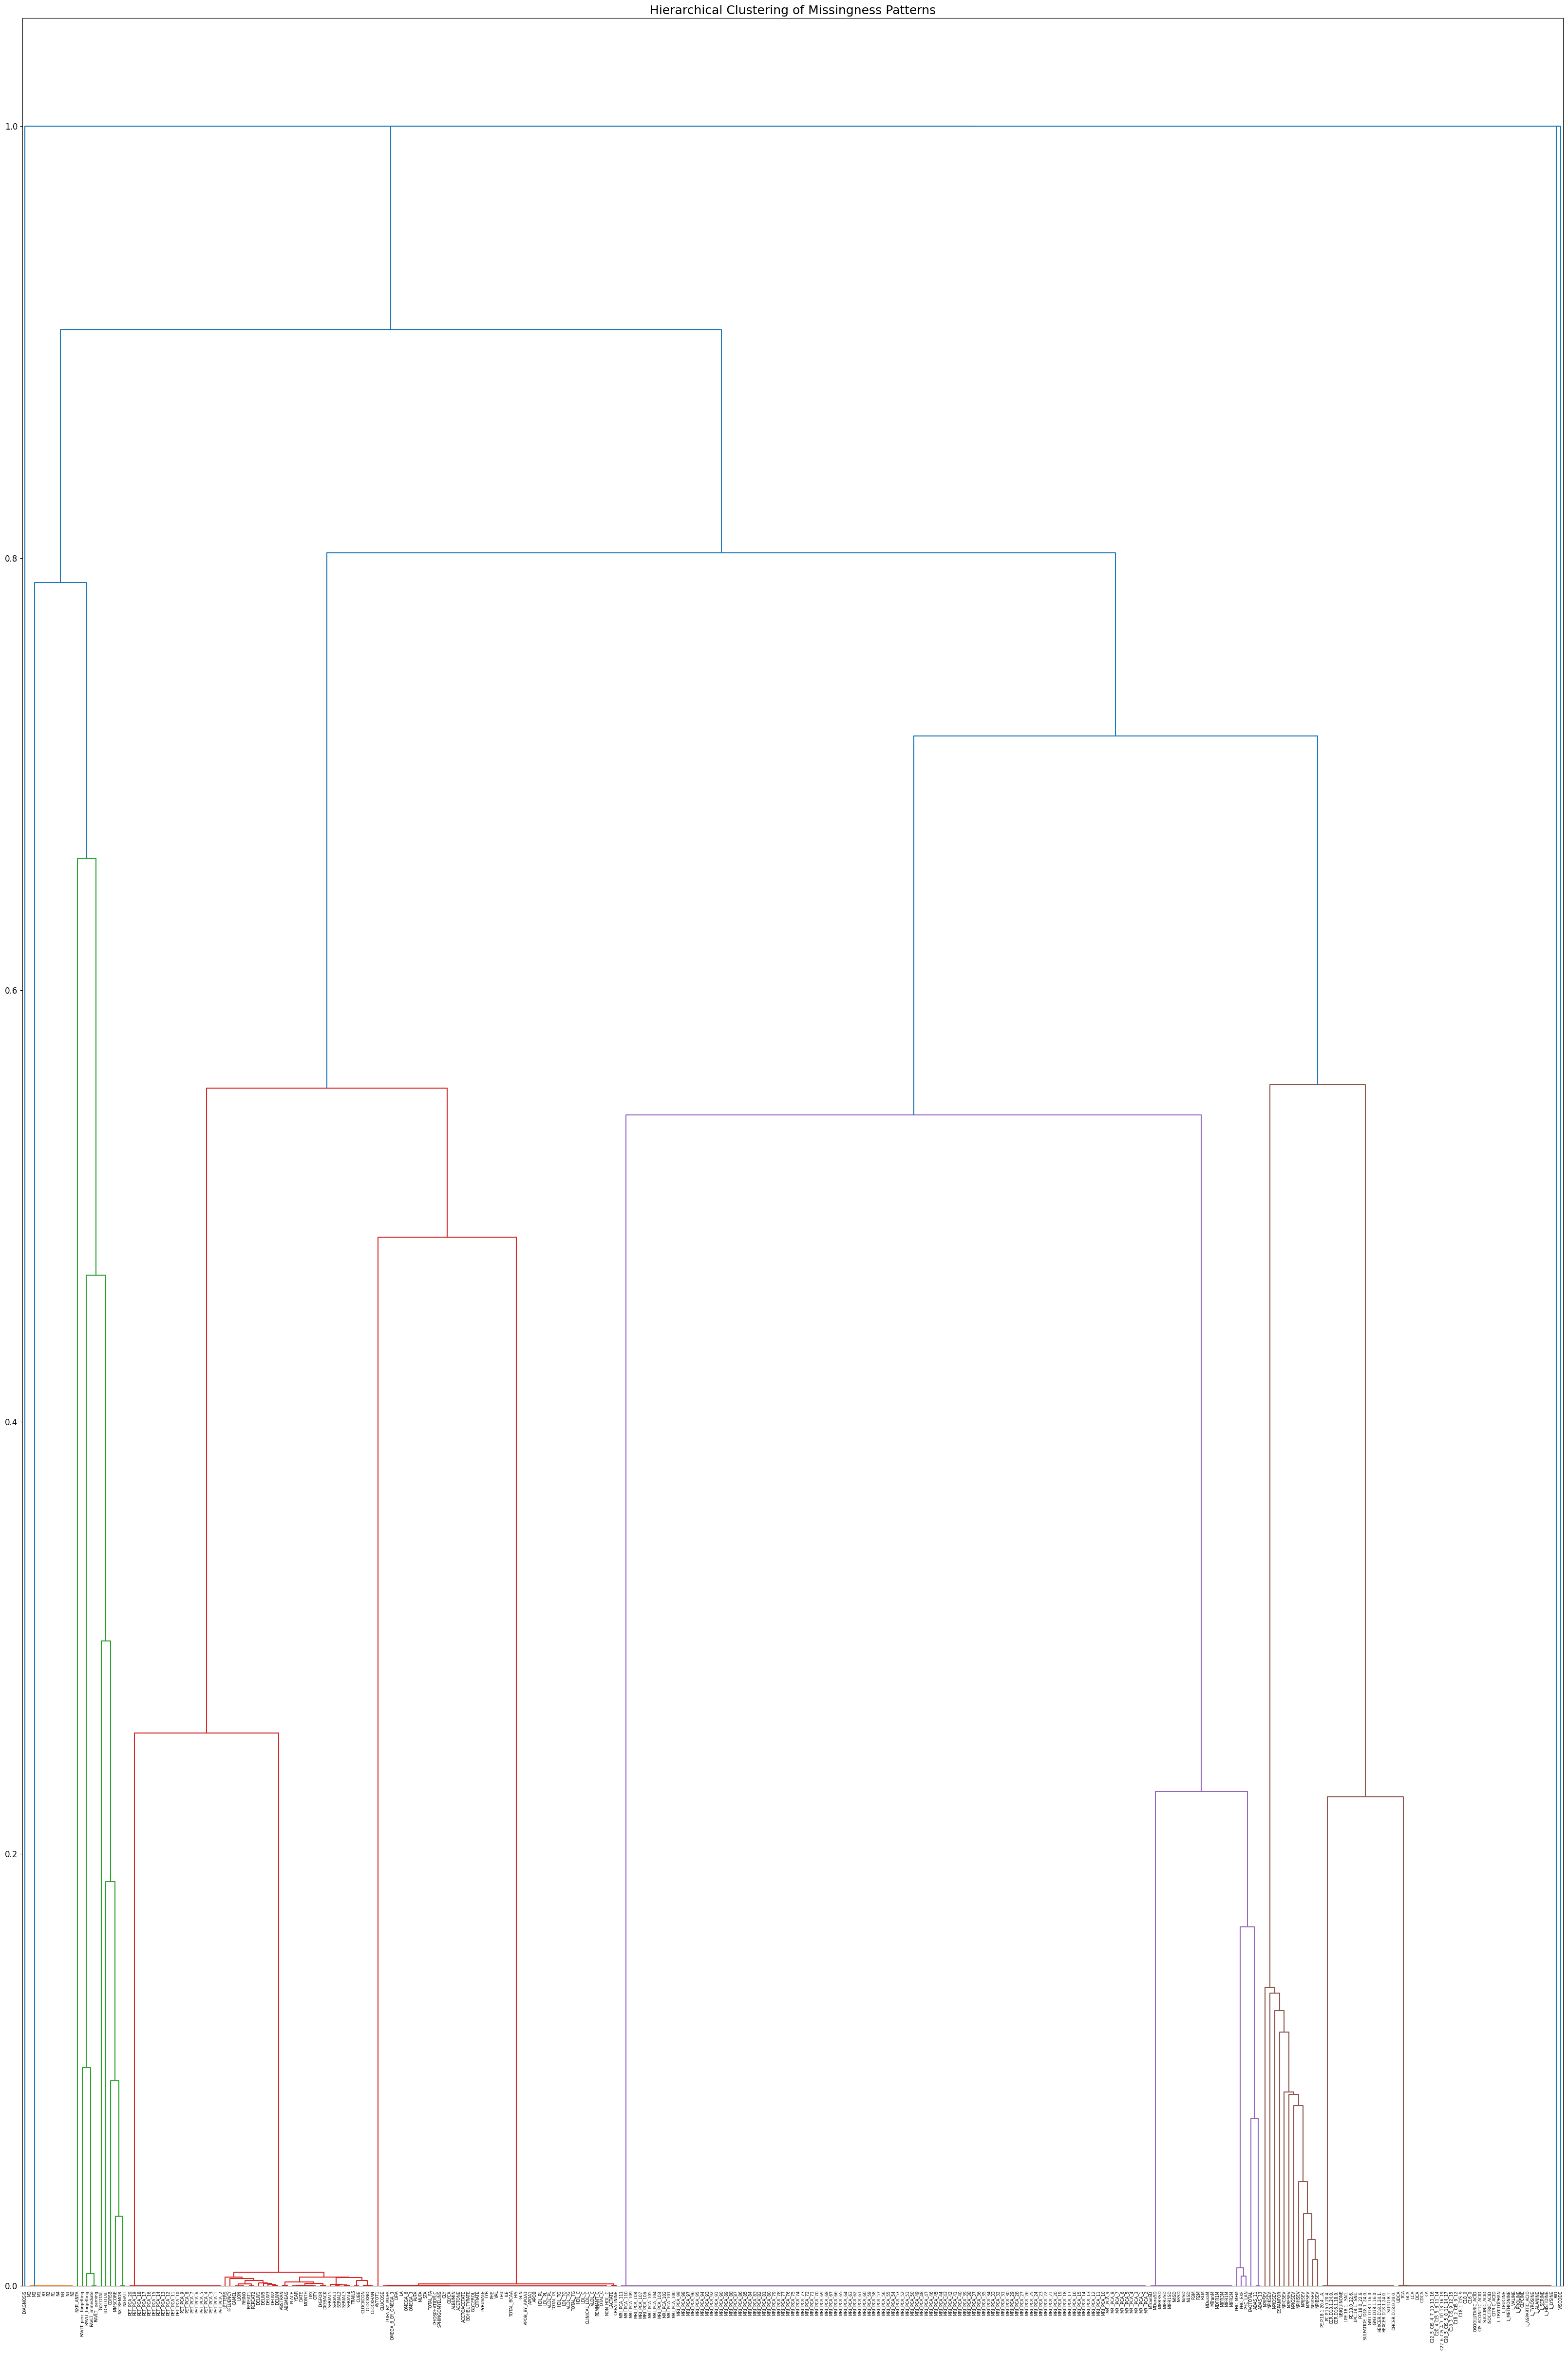

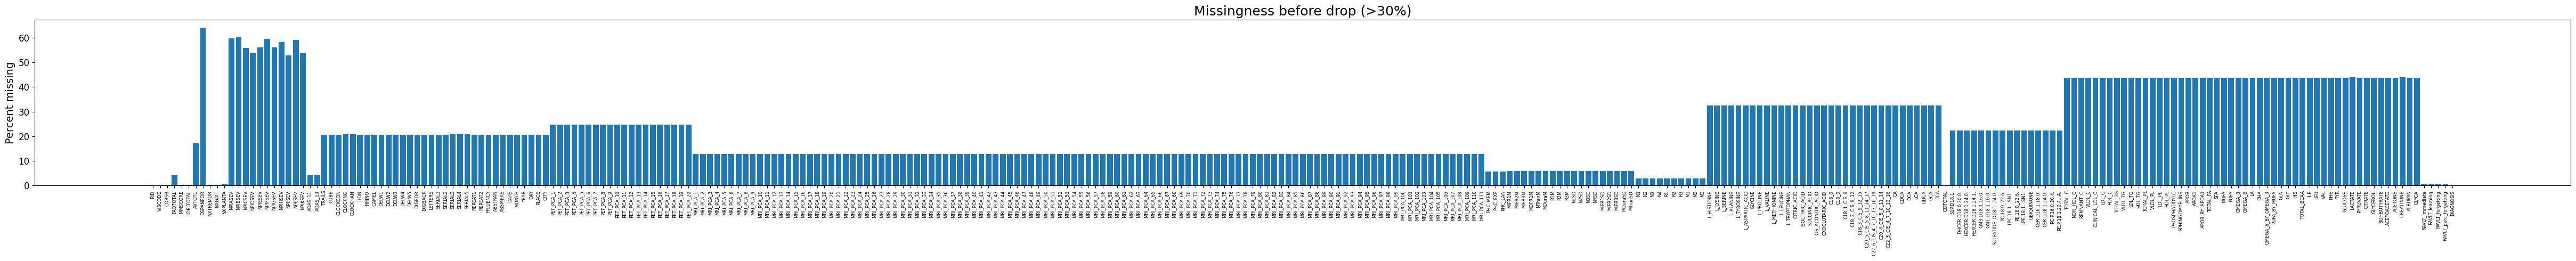

2025-08-25 10:14:07,609 INFO: Dropping 95 features >30% missing: ['DSPANFOR', 'NPIASEV', 'NPIBSEV', 'NPICSEV', 'NPIDSEV', 'NPIESEV', 'NPIFSEV', 'NPIGSEV', 'NPIHSEV', 'NPIISEV', 'NPIJSEV', 'NPIKSEV', 'L_HISTIDINE', 'L_LYSINE', 'L_SERINE', 'L_ALANINE', 'L_TYROSINE', 'L_ASPARTIC_ACID', 'GLYCINE', 'L_PROLINE', 'L_VALINE', 'L_METHIONINE', 'L_LEUCINE', 'L_TRYPTOPHAN', 'CITRIC_ACID', 'ISOCITRIC_ACID', 'SUCCINIC_ACID', 'CIS_ACONITIC_ACID', 'OXOGLUTARIC_ACID', 'C16_0', 'C18_0', 'C18_1_CIS_9', 'C18_2_CIS_9_12', 'C18_3_CIS_9_12_15', 'C20_5_CIS_5_8_11_14_17', 'C22_6_CIS_4_7_10_13_16_19', 'C20_4_CIS_5_8_11_14', 'C22_5_CIS_4_7_10_13_16', 'CA', 'CDCA', 'DCA', 'LCA', 'UDCA', 'GCA', 'TCA', 'TOTAL_C', 'NON_HDL_C', 'REMNANT_C', 'VLDL_C', 'CLINICAL_LDL_C', 'LDL_C', 'HDL_C', 'TOTAL_TG', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'TOTAL_PL', 'VLDL_PL', 'LDL_PL', 'HDL_PL', 'PHOSPHATIDYLC', 'SPHINGOMYELINS', 'APOB', 'APOA1', 'APOB_BY_APOA1', 'TOTAL_FA', 'SFA', 'MUFA', 'PUFA', 'OMEGA_3', 'OMEGA_6', 'LA', 'DHA', 'OMEGA_6_B

Dropped columns >30% missing: ['DSPANFOR', 'NPIASEV', 'NPIBSEV', 'NPICSEV', 'NPIDSEV', 'NPIESEV', 'NPIFSEV', 'NPIGSEV', 'NPIHSEV', 'NPIISEV', 'NPIJSEV', 'NPIKSEV', 'L_HISTIDINE', 'L_LYSINE', 'L_SERINE', 'L_ALANINE', 'L_TYROSINE', 'L_ASPARTIC_ACID', 'GLYCINE', 'L_PROLINE', 'L_VALINE', 'L_METHIONINE', 'L_LEUCINE', 'L_TRYPTOPHAN', 'CITRIC_ACID', 'ISOCITRIC_ACID', 'SUCCINIC_ACID', 'CIS_ACONITIC_ACID', 'OXOGLUTARIC_ACID', 'C16_0', 'C18_0', 'C18_1_CIS_9', 'C18_2_CIS_9_12', 'C18_3_CIS_9_12_15', 'C20_5_CIS_5_8_11_14_17', 'C22_6_CIS_4_7_10_13_16_19', 'C20_4_CIS_5_8_11_14', 'C22_5_CIS_4_7_10_13_16', 'CA', 'CDCA', 'DCA', 'LCA', 'UDCA', 'GCA', 'TCA', 'TOTAL_C', 'NON_HDL_C', 'REMNANT_C', 'VLDL_C', 'CLINICAL_LDL_C', 'LDL_C', 'HDL_C', 'TOTAL_TG', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'TOTAL_PL', 'VLDL_PL', 'LDL_PL', 'HDL_PL', 'PHOSPHATIDYLC', 'SPHINGOMYELINS', 'APOB', 'APOA1', 'APOB_BY_APOA1', 'TOTAL_FA', 'SFA', 'MUFA', 'PUFA', 'OMEGA_3', 'OMEGA_6', 'LA', 'DHA', 'OMEGA_6_BY_OMEGA_3', 'PUFA_BY_MUFA', 'GLN', 

In [18]:
# === Global style ===
plt.rcParams.update({
    'figure.dpi': 100,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

# Drop Features >30% Missing & Impute Time-Series Data

# (A) Standardize Missing Indicators
merged_data.replace(['NA','n/a','N/A','null','',' '], np.nan, inplace=True)
print("Standardized common missing value indicators to np.nan.")

# Exclude MRI and PET features 
mri_pet_features = set(mri_feats) | set(pet_feats)
to_drop = [c for c in merged_data.columns if c in mri_pet_features]
if to_drop:
    merged_data.drop(columns=to_drop, inplace=True)
    print("Excluded MRI/PET features:", to_drop)

# (B) Diagnosis-conditional forward-fill
def viscode_to_order(vis):
    return {"bl":0,"m06":6,"m12":12,"m18":18,"m24":24,"m30":30,
            "m36":36,"m42":42,"m48":48,"m54":54,"m60":60,"m66":66,
            "m72":72,"m78":78,"m84":84}.get(vis, np.nan)

def conditional_forward_fill(group, diag_col, fill_cols):
    """
    Forward-fill missing `fill_cols` when diagnosis stays the same.
    """
    g = group.copy()
    g['visit_order'] = g['VISCODE'].apply(viscode_to_order)
    g.sort_values('visit_order', inplace=True)
    out = g.copy()
    prev = None
    for idx, row in g.iterrows():
        if prev is not None and row[diag_col] == prev[diag_col]:
            for col in fill_cols:
                if pd.isna(row[col]):
                    out.at[idx, col] = prev[col]
        prev = out.loc[idx]
    return out.drop(columns='visit_order')

if 'DIAGNOSIS_ENC' in merged_data.columns:
    fill_cols = merged_data.columns.difference(['RID','VISCODE','DIAGNOSIS_ENC'])
    merged_data = (merged_data
        .groupby('RID')
        .apply(lambda g: conditional_forward_fill(g, 'DIAGNOSIS_ENC', fill_cols))
        .reset_index(drop=True)
    )
else:
    merged_data = merged_data.sort_values(['RID','VISCODE'])
    fill_cols = merged_data.columns.difference(['RID','VISCODE'])
    merged_data[fill_cols] = merged_data.groupby('RID')[fill_cols].ffill()

print("Completed diagnosis-conditional forward-fill.")

# (C) Missingness diagnostics
missing_pct = merged_data.isna().mean() * 100

# Heatmap of missingness
mask = merged_data.isna().astype(int).to_numpy().T
n_feats = mask.shape[0]
fig, ax = plt.subplots(figsize=(12, max(6, n_feats * 0.25)))
ax.imshow(mask, aspect='auto', interpolation='none')
ax.set_yticks(np.arange(n_feats))
ax.set_yticklabels(merged_data.columns, fontsize=max(6, min(12, 300 // n_feats)))
ax.set_xlabel("Row index", fontsize=14)
ax.set_title("Missingness Heatmap (1=present,0=missing)", fontsize=18)
plt.tight_layout()
plt.show()

# Bar chart of % missing
pct = missing_pct.sort_values(ascending=False)
n = len(pct)
fig, ax = plt.subplots(figsize=(max(10, n * 0.15), 6))
ax.bar(np.arange(n), pct.values)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(pct.index, rotation=90, fontsize=max(6, min(12, 300 // n)))
ax.set_ylabel("% missing", fontsize=14)
ax.set_title("Feature-wise Missingness", fontsize=18)
plt.tight_layout()
plt.show()

# Dendrogram of missingness patterns
corr = merged_data.isna().astype(int).corr().abs().fillna(0)
dist = 1 - corr
np.fill_diagonal(dist.values, 0)
Z = linkage(squareform(dist), method='average')

n_feats = corr.shape[0]
fig, ax = plt.subplots(figsize=(max(8, n_feats * 0.1), max(6, n_feats * 0.15)))
dendrogram(
    Z,
    labels=corr.index,
    leaf_rotation=90,
    leaf_font_size=max(6, min(12, 300 // n_feats)),
    ax=ax
)
ax.set_title("Hierarchical Clustering of Missingness Patterns", fontsize=18)
plt.tight_layout()
plt.show()

# (D) Metadata log
preproc_log = {
    "initial_shape": tuple(merged_data.shape),
    "standardized_missing_indicators": ['NA','n/a','N/A','null','',' '],
    "excluded_MRI_PET": to_drop,
    "missing_pct": missing_pct.to_dict()
}

# (E) Compute & record missing-rate before drop (>30%), plot, then drop high-missing features

# 1. Compute percent missing before drop
missing_before = merged_data.isna().mean() * 100
preproc_log["missing_before_pct"] = missing_before.to_dict()

# 2. Plot missingness before drop
n = len(missing_before)
fig, ax = plt.subplots(figsize=(max(10, n * 0.15), 5))
ax.bar(range(n), missing_before.values)
ax.set_xticks(range(n))
ax.set_xticklabels(missing_before.index, rotation=90,
                   fontsize=max(6, min(12, 300 // n)))
ax.set_ylabel("Percent missing", fontsize=14)
ax.set_title("Missingness before drop (>30%)", fontsize=18)
plt.tight_layout()
plt.show()

# 3. Identify & drop features with >30% missing (excluding targets and IDs)
targets = {"ADAS_11","ADAS_13","MMSCORE","FAQTOTAL","CDRSB"}
threshold_pct = 30
cols_to_drop = [
    c for c, pct in missing_before.items()
    if pct > threshold_pct and c not in (*targets, "RID", "VISCODE")
]
logging.info(f"Dropping {len(cols_to_drop)} features >{threshold_pct}% missing: {cols_to_drop}")
merged_data.drop(columns=cols_to_drop, inplace=True)
preproc_log["dropped_>30pct_missing"] = cols_to_drop

print("Dropped columns >30% missing:", cols_to_drop)
print("After drop, shape =", merged_data.shape)

# (F) Add inter-visit interval feature using the actual 'DATE' column
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
merged_data.sort_values(['RID','DATE'], inplace=True)
merged_data['days_since_prev'] = (
    merged_data
      .groupby('RID')['DATE']
      .diff()
      .dt.days
      .fillna(0)
)

# (G) Separate numeric vs categorical
num_cols = merged_data.select_dtypes(include=[np.number]).columns.drop(['RID','DIAGNOSIS_ENC'], errors='ignore')
cat_cols = [c for c in merged_data.columns if c not in num_cols and c not in ['RID','VISCODE','DIAGNOSIS_ENC','EXAMDATE']]

# (H) Group-mean impute numeric by diagnosis
if 'DIAGNOSIS_ENC' in merged_data:
    for diag in merged_data['DIAGNOSIS_ENC'].unique():
        mask = merged_data['DIAGNOSIS_ENC'] == diag
        for col in num_cols:
            merged_data.loc[mask, col] = merged_data.loc[mask, col].fillna(
                merged_data.loc[mask, col].mean()
            )

# (I) Group-mode impute categorical by diagnosis
if 'DIAGNOSIS_ENC' in merged_data:
    for diag in merged_data['DIAGNOSIS_ENC'].unique():
        mask = merged_data['DIAGNOSIS_ENC'] == diag
        for col in cat_cols:
            mode = merged_data.loc[mask, col].mode()
            if not mode.empty:
                merged_data.loc[mask, col] = merged_data.loc[mask, col].fillna(mode.iloc[0])

# (J) Drop diagnosis encoding column
merged_data.drop(columns=['DIAGNOSIS_ENC'], inplace=True, errors='ignore')

# (K) Final standard scaling
scaler_ts = StandardScaler()
scale_cols = [c for c in merged_data.select_dtypes(include=[np.number]).columns if c!='RID']
merged_data[scale_cols] = scaler_ts.fit_transform(merged_data[scale_cols])
print("After standard scaling, final shape =", merged_data.shape)

# (L) Dump metadata log
with open("preprocessing_log.json", "w") as f:
    json.dump(preproc_log, f, indent=2)

## <center> Step 16: Extract Statistical Features from Time-Series
Use the extract_statistical_features helper to generate per-subject summary metrics: mean, standard deviation, minimum, maximum, median, and count—for every numeric variable (excluding VISCODE). Group the data by RID, prefix each new feature with stats_, reset the index for a tidy output, and verify the resulting shape of stats_features to ensure you have one row per subject.

In [19]:
# Extract Statistical Features from the FINAL preprocessed time‐series
def extract_statistical_features(df, prefix, group_col="RID", exclude_cols=["VISCODE"]):
    """
    Groups the input DataFrame by group_col and computes summary statistics
    (mean, std, min, max, median, count) for each numeric column (excluding those in exclude_cols).
    Each new column is named using the provided prefix.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if group_col in numeric_cols:
        numeric_cols.remove(group_col)
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    if not numeric_cols:
        return None
    agg_df = df.groupby(group_col)[numeric_cols].agg(["mean", "std", "min", "max", "median", "count"])
    agg_df.columns = [f"{prefix}_{col}_{stat}" for col, stat in agg_df.columns]
    agg_df.reset_index(inplace=True)
    return agg_df
# make sure RID is a string
merged_data["RID"] = merged_data["RID"].astype(str)

# reuse your helper to get one row per subject:
stats_features = extract_statistical_features(
    merged_data,
    prefix="stats",        # you'll get stats_<col>_{mean,std,min,max,median,count}
    group_col="RID",
    exclude_cols=["VISCODE"]
)

print("Aggregated stats from merged_data shape:", stats_features.shape)

Aggregated stats from merged_data shape: (2271, 1357)


C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\2800298136.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df.reset_index(inplace=True)


## <center> Step 16: Filter Subjects, Build Modality Tensors & Align
We first identify all subjects with a true baseline visit (“bl”) and a recorded diagnosis, then filter every source table to retain only those “good” RIDs. From the filtered merged dataset we rebuild our static feature matrix, selecting all remaining numeric columns (excluding IDs, time codes, and outcome targets), dropping duplicates so there’s exactly one row per subject, and converting it into a NumPy array alongside its ordered RID list. We then define a helper, create_modality_tensor, which takes any longitudinal DataFrame, limits it to our expected visit codes, selects numeric features, and for each subject constructs a fixed-length sequence matrix (visits × features) by forward-filling missing timepoints from baseline or the previous visit. Using this function, we build separate 3D tensors for cognitive tests, clinical assessments, metabolomics, MRI and PET embeddings, and regression targets (ADAS-13, MMSE, FAQ total, CDR-SB), each with its own RID index. Finally, we compute the union of all RID sets, pad each tensor and the static feature array so they align to this common subject order (filling absent entries with NaNs), and print out the number of subjects and the shape of each tensor as a final sanity check.

In [20]:
# 0) Find RIDs with a true baseline in merged_data
bl_rids = set(
    merged_data.loc[
        merged_data['VISCODE'].str.lower().eq('bl'),
        'RID'
    ].astype(str)
)

# 1) Find RIDs in your diagnosis table
sd = subject_diagnosis.copy()
sd['RID'] = sd['RID'].astype(str)
diag_rids = set(sd['RID'])

# 2) Keep only those with both baseline & a diagnosis
good_rids = bl_rids & diag_rids

# 3) A helper to filter any df to those RIDs
def keep_good(df):
    df = df.copy()
    df['RID'] = df['RID'].astype(str)
    return df[df['RID'].isin(good_rids)]

# 4) Apply that filter to *all* your source tables
for name in [
    'moca_data','adspCognitive_data','embicCognitive_data','embicDigital_data',
    'neurobattery_data','neuroexam_data','npiq_data','GeriatricDepressionScale_data',
    'GutMetabolites_data','lipidomics_data','lipoproteins_data',
    'mri_pca_visits_df','pet_pca_visits_df','merged_data'
]:
    globals()[name] = keep_good(globals()[name])

# 5) Rebuild static_df *after* filtering merged_data
static_vars = [
    c for c in merged_data.columns
    if c not in ['RID','VISCODE','ADAS_13','MMSCORE','FAQTOTAL','CDRSB']
       and pd.api.types.is_numeric_dtype(merged_data[c])
]
static_df = (
    merged_data[['RID'] + static_vars]
      .drop_duplicates('RID')
      .assign(RID=lambda df: df['RID'].astype(str))
      .reset_index(drop=True)
)
static_features = static_df[static_vars].to_numpy(dtype=float)
static_rids     = static_df['RID'].to_numpy(dtype=str)

# 6) Now create your modality‐building helper
expected_visits = ["bl","m06","m12","m18","m24","m30","m36","m42","m48","m54","m60","m66","m72","m78","m84"]
def create_modality_tensor(df, modality_vars=None):
    df = df.copy()
    df['VISCODE'] = df['VISCODE'].str.lower().str.strip()
    df = df[df['VISCODE'].isin(expected_visits)]
    # pick numeric features
    if modality_vars is None:
        feat_cols = [c for c in df.columns if c not in ('RID','VISCODE') and pd.api.types.is_numeric_dtype(df[c])]
    else:
        feat_cols = [c for c in modality_vars if c in df.columns]
    visit_idx = {v:i for i,v in enumerate(expected_visits)}
    out = {}
    for rid, grp in df.groupby('RID'):
        seq = np.full((len(expected_visits), len(feat_cols)), np.nan)
        for _, row in grp.iterrows():
            i = visit_idx[row['VISCODE']]
            seq[i] = row[feat_cols].to_numpy(dtype=float)
        # baseline fill + forward‐fill
        if np.isnan(seq[0,0]):
            v = np.where(~np.isnan(seq[:,0]))[0]
            if v.size: seq[0] = seq[v[0]]
        for i in range(1,len(expected_visits)):
            if np.isnan(seq[i,0]):
                seq[i] = seq[i-1]
        out[str(rid)] = seq
    rids = sorted(out)
    if not rids:
        return np.empty((0,len(expected_visits),0)), np.array([],dtype=str)
    tensor = np.stack([out[r] for r in rids])
    return tensor, np.array(rids,dtype=str)

# 7) Build each tensor
cog_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                [moca_data,adspCognitive_data,embicCognitive_data,embicDigital_data])
cognitive_tensor, cog_rids = create_modality_tensor(cog_df)

assess_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                   [neurobattery_data, neuroexam_data, npiq_data, GeriatricDepressionScale_data])
assess_tensor, assess_rids = create_modality_tensor(assess_df)

neuro_df = reduce(lambda L,R: pd.merge(L,R,on=['RID','VISCODE'],how='outer'),
                  [GutMetabolites_data, lipidomics_data, lipoproteins_data])
neuropath_tensor, neuro_rids = create_modality_tensor(neuro_df)

mri_tensor, mri_rids = create_modality_tensor(mri_pca_visits_df)
pet_tensor, pet_rids = create_modality_tensor(pet_pca_visits_df)

# 8) Regression tensor
targets = ["ADAS_13","MMSCORE","FAQTOTAL","CDRSB"]
regression_vars = [c for c in targets if c in merged_data.columns]
reg_tensor, reg_rids = create_modality_tensor(merged_data, modality_vars=regression_vars)

# 9) Align all to the same union of RIDs
union_rids = sorted({*cog_rids,*mri_rids,*pet_rids,*assess_rids,*neuro_rids,*reg_rids,*static_rids})
def add_missing(tensor, rids, union):
    feat = tensor.shape[2] if tensor.size else 0
    m = {rid:tensor[i] for i,rid in enumerate(rids)}
    return np.stack([m.get(r,np.full((len(expected_visits),feat),np.nan)) for r in union])
def add_static(arr, rids, union):
    feat = arr.shape[1] if arr.size else 0
    m = {rid:arr[i] for i,rid in enumerate(rids)}
    return np.stack([m.get(r,np.full((feat,),np.nan)) for r in union])

cognitive_tensor = add_missing(cognitive_tensor, cog_rids, union_rids)
mri_tensor       = add_missing(mri_tensor,       mri_rids, union_rids)
pet_tensor       = add_missing(pet_tensor,       pet_rids, union_rids)
assess_tensor    = add_missing(assess_tensor,    assess_rids, union_rids)
neuropath_tensor = add_missing(neuropath_tensor, neuro_rids, union_rids)
reg_tensor       = add_missing(reg_tensor,       reg_rids, union_rids)
static_features  = add_static(static_features,   static_rids, union_rids)

# 10) Final sanity-check
print("Subjects:", len(union_rids))
print("cognitive:", cognitive_tensor.shape)
print("mri:      ", mri_tensor.shape)
print("pet:      ", pet_tensor.shape)
print("assess:   ", assess_tensor.shape)
print("neuro:    ", neuropath_tensor.shape)
print("regress:  ", reg_tensor.shape)
print("static:   ", static_features.shape)

Subjects: 2271
cognitive: (2271, 15, 63)
mri:       (2271, 15, 111)
pet:       (2271, 15, 20)
assess:    (2271, 15, 62)
neuro:     (2271, 15, 50)
regress:   (2271, 15, 4)
static:    (2271, 222)


## <center> Step 16: Baseline Cohort Characterization (Diagnosis, Gender, Age & Education)
In this step, we first inspect the diagnosis table’s columns and ensure every RID is a string, then create a diag_series aligned to our master list of subjects (union_rids) that records each subject’s baseline diagnosis; we compute and print the counts and percentages of each diagnosis category. Next, we pull gender from the demographics table, grouping by RID, taking the first recorded PTGENDER value, mapping numeric codes to “Male”/“Female,” and reporting its distribution over the same subject set. Finally, we load the full demographics CSV to extract each subject’s earliest (baseline) visit, calculate age at baseline as the difference between visit year and birth year, and compute and print the mean and standard deviation of both age and years of education.

In [21]:
print(sd.columns.tolist())

# 1) Ensure RID is string
sd = subject_diagnosis.copy()
sd['RID'] = sd['RID'].astype(str)

# 2) Build a Series aligned to union
diag_map = sd.set_index('RID')['DIAGNOSIS']
diag_series = pd.Series(
    [diag_map.get(rid, np.nan) for rid in union_rids],
    index=union_rids,
    name='baseline_diag'
)

# 3) Compute counts & percentages
counts  = diag_series.value_counts(dropna=False).sort_index()
percent = diag_series.value_counts(normalize=True, dropna=False).mul(100).round(2).sort_index()

diag_df = pd.DataFrame({'count': counts, 'percent': percent})

print(f"Baseline diagnostic distribution over {len(union_rids)} subjects:\n")
print(diag_df)

# 1) Load and align
sd = demographics_data.copy()
sd['RID'] = sd['RID'].astype(str)

# 2) Build a RID to gender map by taking the first entry for each RID
gender_map = sd.groupby('RID')['PTGENDER'].first()

# 3) Align to union_rids
gender_series = pd.Series(
    [gender_map.get(rid, np.nan) for rid in union_rids],
    index=union_rids,
    name='baseline_gender'
)

# 4) Map numeric codes to labels
gender_series = gender_series.map({1: 'Male', 2: 'Female'})

# 5) Compute counts & percentages
counts  = gender_series.value_counts(dropna=False).sort_index()
percent = gender_series.value_counts(normalize=True, dropna=False).mul(100).round(2).sort_index()

gender_df = pd.DataFrame({'count': counts, 'percent': percent})

print(f"Baseline gender distribution over {len(union_rids)} subjects:\n")
print(gender_df)

# 1) Load baseline demographics
dem = pd.read_csv(demographics_file, usecols=["RID", "PTGENDER", "PTDOBYY", "VISDATE", "PTEDUCAT"])
dem["RID"] = dem["RID"].astype(str)
dem["VISDATE"] = pd.to_datetime(dem["VISDATE"], errors="coerce")

# 2) Keep only each subject’s earliest (baseline) visit
baseline = (
    dem.sort_values("VISDATE")
       .groupby("RID", as_index=False)
       .first()
       .set_index("RID")
)

# 4) Age at baseline (visit year minus birth year)
baseline["age"] = baseline["VISDATE"].dt.year - baseline["PTDOBYY"]
age_mean, age_sd = baseline["age"].mean(), baseline["age"].std()
print(f"\nAge at baseline: mean = {age_mean:.1f} years, SD = {age_sd:.1f} years")

# 5) Years of education
edu_mean, edu_sd = baseline["PTEDUCAT"].mean(), baseline["PTEDUCAT"].std()
print(f"Years of education: mean = {edu_mean:.1f}, SD = {edu_sd:.1f}")

['RID', 'DIAGNOSIS']
Baseline diagnostic distribution over 2271 subjects:

               count  percent
baseline_diag                
1.0              852    37.52
2.0             1032    45.44
3.0              387    17.04
Baseline gender distribution over 2271 subjects:

                 count  percent
baseline_gender                
Female            1065     46.9
Male              1206     53.1

Age at baseline: mean = 72.2 years, SD = 7.8 years
Years of education: mean = 15.9, SD = 2.9


## <center> Step 17: Generate Group-Level Summary Table for Baseline vs Month 84
In this step, we first map the numeric diagnosis codes to human-readable labels (“CN”, “MCI”, “AD”) and build a baseline demographics table that includes each subject’s gender, age, and years of education. We then split our longitudinal dataset into two snapshots, baseline (“bl”) and Month 84 (“m84”), and join each with the baseline demographic and diagnostic information. Gender codes are translated into “M”/“F,” and a small helper function formats continuous measures as “mean ± SD” or gender counts as “M/F.” Specifying the key variables of interest (gender, age, education, ADAS-11, ADAS-13, MMSE, CDR-SB, FAQ), we loop over each diagnostic group (CN, MCI, AD) and both timepoints to calculate the summaries, collect them into rows, and pivot into a wide table. The final output is a neatly formatted markdown table that compares, for each group, their baseline and Month 84 values across all selected demographics and clinical scores.

In [ ]:
# 0) Map diagnosis codes to labels 
diag_map = {1.0: "CN", 2.0: "MCI", 3.0: "AD"}

# 1) Baseline demographics 
dem = demographics_data.copy()
dem["RID"]     = dem["RID"].astype(str).str.strip()
dem["VISDATE"] = pd.to_datetime(dem["VISDATE"], errors="coerce")

baseline_demo = (
    dem.sort_values("VISDATE")
       .groupby("RID", as_index=False)
       .first()
       .set_index("RID")
)
baseline_demo["age"]       = baseline_demo["VISDATE"].dt.year - baseline_demo["PTDOBYY"]
baseline_demo["education"] = baseline_demo["PTEDUCAT"]
baseline_demo = baseline_demo.rename(columns={"PTGENDER":"PTGENDER_bl"})

# Bring in baseline diagnosis
sd = subject_diagnosis.copy()
sd["RID"] = sd["RID"].astype(str).str.strip()
diag = sd.set_index("RID")["DIAGNOSIS"].astype(float)

baseline_demo = baseline_demo.join(diag.rename("baseline_diag"), how="inner")
baseline_demo["baseline_diag_lbl"] = baseline_demo["baseline_diag"].map(diag_map)

# 2) Split merged_data into BL / M84 and join demo+diag
df = merged_data.copy()
df["RID"]     = df["RID"].astype(str).str.strip()
df["VISCODE"] = df["VISCODE"].str.lower().str.strip()

bl  = df[df["VISCODE"]=="bl"].set_index("RID")
m84 = df[df["VISCODE"]=="m84"].set_index("RID")

keep_cols = ["PTGENDER_bl","age","education","baseline_diag_lbl"]
bl  = bl.join(baseline_demo[keep_cols], how="inner")
m84 = m84.join(baseline_demo[keep_cols], how="inner")

# Map gender codes to “M”/“F”
for d in (bl, m84):
    d["Gender"] = d["PTGENDER_bl"].map({1:"M",2:"F"})

# 3) Summary helper (with dashes instead of NaN)
def summarize(s, is_gender=False):
    """
    Format a pandas Series for summary reporting.

    For gender (is_gender=True), returns "M/F" counts or "-" if empty.
    Otherwise, returns "mean ± std" (or "mean ± -" if only one value),
    or "-" if the series is empty.
    """
    if is_gender:
        cnt = s.value_counts().reindex(["M","F"]).fillna(0).astype(int)
        total = cnt.sum()
        return "-" if total == 0 else f"{cnt['M']}/{cnt['F']}"
    n = len(s)
    if n == 0:
        return "-"
    m = s.mean()
    if n == 1:
        return f"{m:.2f} ± -"
    return f"{m:.2f} ± {s.std():.2f}"

# 4) Variables to show 
vars_to_show = [
    ("Gender (M/F)", "Gender",    True),
    ("Age (y)",       "age",       False),
    ("Education (y)", "education", False),
    ("ADAS-11",       "ADAS_11",   False),
    ("ADAS-13",       "ADAS_13",   False),
    ("MMSE",          "MMSCORE",   False),
    ("CDRSB",         "CDRSB",     False),
    ("FAQ",           "FAQTOTAL",  False),
]

# 5) Build rows for each group & time
rows = []
groups = ["CN","MCI","AD"]
for grp in groups:
    for time, df_time in [("Baseline", bl), ("Month 84", m84)]:
        sub = df_time[df_time["baseline_diag_lbl"] == grp]
        for label, col, is_g in vars_to_show:
            val = summarize(sub[col].dropna(), is_gender=is_g)
            rows.append({
                "Group": grp,
                "Variable": label,
                "Baseline" if time=="Baseline" else "Month 84": val
            })

# 6) Pivot into a wide table
table = (
    pd.DataFrame(rows)
      .pivot_table(index=["Group","Variable"],
                   values=["Baseline","Month 84"],
                   aggfunc="first")
      .reset_index()
)

print(table.to_markdown(index=False))

| Group   | Variable      | Baseline     | Month 84     |
|:--------|:--------------|:-------------|:-------------|
| AD      | ADAS-11       | 0.43 ± 0.70  | 1.74 ± -     |
| AD      | ADAS-13       | 0.20 ± 0.83  | 1.86 ± -     |
| AD      | Age (y)       | 74.66 ± 7.88 | 71.00 ± -    |
| AD      | CDRSB         | 0.79 ± 0.71  | 0.91 ± -     |
| AD      | Education (y) | 15.31 ± 2.88 | 16.00 ± -    |
| AD      | FAQ           | 1.18 ± 0.97  | 1.11 ± -     |
| AD      | Gender (M/F)  | 228/176      | 1/0          |
| AD      | MMSE          | -0.96 ± 0.55 | -1.01 ± -    |
| CN      | ADAS-11       | -0.36 ± 0.91 | -0.48 ± 0.77 |
| CN      | ADAS-13       | -0.29 ± 0.93 | -0.42 ± 0.77 |
| CN      | Age (y)       | 72.08 ± 6.46 | 73.85 ± 4.94 |
| CN      | CDRSB         | -0.62 ± 0.34 | -0.42 ± 0.78 |
| CN      | Education (y) | 16.50 ± 2.50 | 16.37 ± 2.64 |
| CN      | FAQ           | -0.59 ± 0.19 | -0.48 ± 0.48 |
| CN      | Gender (M/F)  | 584/723      | 80/84        |
| CN      | MM

## <center> Step 18:  Construct Tau Modality Tensor & Assemble Context Tensor
In this step, we first define all relevant tau‐related columns, static CSF and plasma biomarkers, detailed PET‐tau SUVr regions, and pTau217 measures, then load each source dataset with our load_with_viscode helper to ensure a consistent RID/VISCODE structure. We concatenate the visit keys across all sources into all_keys and left‐merge each individual DataFrame to build a unified tau_df. After resolving any duplicate PTAU columns, we restrict to our master subject list (union_rids), sort by RID and VISCODE, and forward‐ and backward‐fill missing values within each subject to ensure a complete time series. We coerce all tau variables to numeric and then manually construct a three‐dimensional array tau_tensor of shape (subjects x visits x features), filling baseline values from the first available measurement and propagating the last observed value forward when a visit is missing. Finally, we create the overarching context_tensor by concatenating the previously built cognitive, MRI, assessment, and metabolomics tensors along the feature axis, yielding a single multi‐modal input array for downstream modeling.

In [23]:
# 1) Define all tau-related column lists

PET_TAU_COLUMNS = [
    "NPDKA_INFERIORCEREBELLUM","BRAINSTEM_SUVR",
    "VENTRICLE_3RD_SUVR","VENTRICLE_4TH_SUVR","VENTRICLE_5TH_SUVR",
    "CC_ANTERIOR_SUVR","CC_CENTRAL_SUVR","CC_MID_ANTERIOR_SUVR","CC_MID_POSTERIOR_SUVR",
    "CC_POSTERIOR_SUVR","CSF_SUVR","OPTIC_CHIASM_SUVR","NON_WM_HYPOINTENSITIES_SUVR",
    "WM_HYPOINTENSITIES_SUVR","CTX_LH_BANKSSTS_SUVR","CTX_LH_CAUDALANTERIORCINGULATE_SUVR",
    "CTX_LH_CAUDALMIDDLEFRONTAL_SUVR","CTX_LH_CUNEUS_SUVR","CTX_LH_ENTORHINAL_SUVR",
    "CTX_LH_FRONTALPOLE_SUVR","CTX_LH_FUSIFORM_SUVR","CTX_LH_INFERIORPARIETAL_SUVR",
    "CTX_LH_INFERIORTEMPORAL_SUVR","CTX_LH_INSULA_SUVR","CTX_LH_ISTHMUSCINGULATE_SUVR",
    "CTX_LH_LATERALOCCIPITAL_SUVR","CTX_LH_LATERALORBITOFRONTAL_SUVR","CTX_LH_LINGUAL_SUVR",
    "CTX_LH_MEDIALORBITOFRONTAL_SUVR","CTX_LH_MIDDLETEMPORAL_SUVR","CTX_LH_PARACENTRAL_SUVR",
    "CTX_LH_PARAHIPPOCAMPAL_SUVR","CTX_LH_PARSOPERCULARIS_SUVR","CTX_LH_PARSORBITALIS_SUVR",
    "CTX_LH_PARSTRIANGULARIS_SUVR","CTX_LH_PERICALCARINE_SUVR","CTX_LH_POSTCENTRAL_SUVR",
    "CTX_LH_POSTERIORCINGULATE_SUVR","CTX_LH_PRECENTRAL_SUVR","CTX_LH_PRECUNEUS_SUVR",
    "CTX_LH_ROSTRALANTERIORCINGULATE_SUVR","CTX_LH_ROSTRALMIDDLEFRONTAL_SUVR",
    "CTX_LH_SUPERIORFRONTAL_SUVR","CTX_LH_SUPERIORPARIETAL_SUVR","CTX_LH_SUPERIORTEMPORAL_SUVR",
    "CTX_LH_SUPRAMARGINAL_SUVR","CTX_LH_TEMPORALPOLE_SUVR","CTX_LH_TRANSVERSETEMPORAL_SUVR",
    "CTX_RH_BANKSSTS_SUVR","CTX_RH_CAUDALANTERIORCINGULATE_SUVR","CTX_RH_CAUDALMIDDLEFRONTAL_SUVR",
    "CTX_RH_CUNEUS_SUVR","CTX_RH_ENTORHINAL_SUVR","CTX_RH_FRONTALPOLE_SUVR","CTX_RH_FUSIFORM_SUVR",
    "CTX_RH_INFERIORPARIETAL_SUVR","CTX_RH_INFERIORTEMPORAL_SUVR","CTX_RH_INSULA_SUVR",
    "CTX_RH_ISTHMUSCINGULATE_SUVR","CTX_RH_LATERALOCCIPITAL_SUVR","CTX_RH_LATERALORBITOFRONTAL_SUVR",
    "CTX_RH_LINGUAL_SUVR","CTX_RH_MEDIALORBITOFRONTAL_SUVR","CTX_RH_MIDDLETEMPORAL_SUVR",
    "CTX_RH_PARACENTRAL_SUVR","CTX_RH_PARAHIPPOCAMPAL_SUVR","CTX_RH_PARSOPERCULARIS_SUVR",
    "CTX_RH_PARSORBITALIS_SUVR","CTX_RH_PARSTRIANGULARIS_SUVR","CTX_RH_PERICALCARINE_SUVR",
    "CTX_RH_POSTCENTRAL_SUVR","CTX_RH_POSTERIORCINGULATE_SUVR","CTX_RH_PRECENTRAL_SUVR",
    "CTX_RH_PRECUNEUS_SUVR","CTX_RH_ROSTRALANTERIORCINGULATE_SUVR","CTX_RH_ROSTRALMIDDLEFRONTAL_SUVR",
    "CTX_RH_SUPERIORFRONTAL_SUVR","CTX_RH_SUPERIORPARIETAL_SUVR","CTX_RH_SUPERIORTEMPORAL_SUVR",
    "CTX_RH_SUPRAMARGINAL_SUVR","CTX_RH_TEMPORALPOLE_SUVR","CTX_RH_TRANSVERSETEMPORAL_SUVR",
    "LEFT_ACCUMBENS_AREA_SUVR","LEFT_AMYGDALA_SUVR","LEFT_CAUDATE_SUVR","LEFT_CEREBELLUM_CORTEX_SUVR",
    "LEFT_CEREBELLUM_WHITE_MATTER_SUVR","LEFT_CEREBRAL_WHITE_MATTER_SUVR","LEFT_CHOROID_PLEXUS_SUVR",
    "LEFT_HIPPOCAMPUS_SUVR","LEFT_INF_LAT_VENT_SUVR","LEFT_LATERAL_VENTRICLE_SUVR","LEFT_PALLIDUM_SUVR",
    "LEFT_PUTAMEN_SUVR","LEFT_THALAMUS_PROPER_SUVR","LEFT_VENTRALDC_SUVR","LEFT_VESSEL_SUVR",
    "RIGHT_ACCUMBENS_AREA_SUVR","RIGHT_AMYGDALA_SUVR","RIGHT_CAUDATE_SUVR","RIGHT_CEREBELLUM_CORTEX_SUVR",
    "RIGHT_CEREBELLUM_WHITE_MATTER_SUVR","RIGHT_CEREBRAL_WHITE_MATTER_SUVR","RIGHT_CHOROID_PLEXUS_SUVR",
    "RIGHT_HIPPOCAMPUS_SUVR","RIGHT_INF_LAT_VENT_SUVR","RIGHT_LATERAL_VENTRICLE_SUVR",
    "RIGHT_PALLIDUM_SUVR","RIGHT_PUTAMEN_SUVR","RIGHT_THALAMUS_PROPER_SUVR","RIGHT_VENTRALDC_SUVR",
    "RIGHT_VESSEL_SUVR","B12pos","B3pos","B4pos","B5pos","B6pos","HiBRAAKpos"
]


PLASMA_PTAU_COLUMNS = ["pT217_F", "pT217_AB42_F"]
STATIC_TAU_COLUMNS = ["TAU", "PTAU", "PLASMAPTAU181", "ABETA42", "PLASMA_NFL"]


# 2) Load each source
sources = [
    load_with_viscode(csfbiobank_file,      ["RID","VISCODE","TAU","PTAU"],                        require_viscode=True),
    load_with_viscode(ptau181_file,         ["RID","VISCODE","PLASMAPTAU181"],                      require_viscode=True),
    load_with_viscode(tau_file,             ["RID","VISCODE","PTAU"],                               require_viscode=True),
    load_with_viscode(pet_tau_detailed_file,["RID","VISCODE"] + PET_TAU_COLUMNS,                    require_viscode=True),
    load_with_viscode(plasma_biomarker_file,["RID","VISCODE"] + PLASMA_PTAU_COLUMNS,                  require_viscode=True),
    load_with_viscode(csfbiobank_file,      ["RID","VISCODE","ABETA42"],                            require_viscode=True),
    load_with_viscode(PlasmaNFL,            ["RID","VISCODE","PLASMA_NFL"],                         require_viscode=True)
]


# 3) Build master key & left-merge
all_keys = (
    pd.concat([df[['RID','VISCODE']] for df in sources], ignore_index=True)
      .drop_duplicates()
      .sort_values(['RID','VISCODE'])
      .reset_index(drop=True)
)

tau_df = all_keys.copy()
for df in sources:
    tau_df = tau_df.merge(df, on=['RID','VISCODE'], how='left')


# 4) Clean up duplicate columns
if 'PTAU_x' in tau_df.columns and 'PTAU_y' in tau_df.columns:
    tau_df['PTAU'] = tau_df['PTAU_x'].combine_first(tau_df['PTAU_y'])
    tau_df.drop(columns=['PTAU_x','PTAU_y'], inplace=True)

tau_df = tau_df.loc[:, ~tau_df.columns.duplicated()]


# 5) Filter, sort, and fill
tau_df['RID'] = tau_df['RID'].astype(str)
tau_df = (
    tau_df[tau_df['RID'].isin(union_rids)]
    .sort_values(['RID','VISCODE'])
    .reset_index(drop=True)
)

tau_df = (
    tau_df
    .groupby('RID', group_keys=False)
    .apply(lambda g: g.ffill().bfill())
    .reset_index(drop=True)
)


# 6) Coerce all modality_vars to numeric
modality_vars = STATIC_TAU_COLUMNS + PET_TAU_COLUMNS + PLASMA_PTAU_COLUMNS
tau_df[modality_vars] = (
    tau_df[modality_vars]
    .apply(pd.to_numeric, errors='coerce')
)


# 7) Build tau_tensor manually
expected_visits = [
    "bl","m06","m12","m18","m24","m30","m36",
    "m42","m48","m54","m60","m66","m72","m78","m84"
]

n_subjects = len(union_rids)
n_visits   = len(expected_visits)
n_feats    = len(modality_vars)

tau_tensor = np.full((n_subjects, n_visits, n_feats), np.nan)

for i, rid in enumerate(union_rids):
    sub = tau_df[tau_df['RID'] == rid]
    if sub.empty:
        continue  # leave as all-NaN if no data exists

    # Baseline
    baseline = sub[sub['VISCODE'] == 'bl']
    vals0 = (
        baseline.iloc[0][modality_vars].values
        if not baseline.empty
        else sub.iloc[0][modality_vars].values
    )
    tau_tensor[i,0,:] = vals0

    # Subsequent visits
    for j, vis in enumerate(expected_visits[1:], start=1):
        row = sub[sub['VISCODE'] == vis]
        tau_tensor[i,j,:] = (
            row.iloc[0][modality_vars].values
            if not row.empty
            else tau_tensor[i,j-1,:]
        )

print("tau_tensor.shape:", tau_tensor.shape)


# 8) Build context_tensor
context_tensor = np.concatenate([
    cognitive_tensor,
    mri_tensor,
    assess_tensor,
    neuropath_tensor
], axis=2)
print("context_tensor shape:", context_tensor.shape)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\242213712.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda g: g.ffill().bfill())
C:\Users\Asus\AppData\Local\Temp\ipykernel_7652\242213712.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.ffill().bfill())


tau_tensor.shape: (2271, 15, 125)
context_tensor shape: (2271, 15, 286)


## <center> Step 19: Prepare Inputs, Train the CVAE-MDN & Evaluate Performance
We first convert our prebuilt tau_tensor and context_tensor into model-ready NumPy arrays (tau_input_np, mask_np, context_input_np), replacing all NaNs with zeros for the network input while preserving a binary mask of observed entries. We then randomly split the subjects into training (80%), validation (10%), and test (10%) sets. Next, we compute per-feature means and variances on the training set, taking care to weight by the mask for tau features, and use these statistics to normalize both the tau and context inputs.

We define a custom “sampling” layer for the VAE latent space, then build a three-input encoder (tau sequence, mask, context) that concatenates observed tau, the mask, and context, passes them through a BiLSTM and dense layers, and outputs a 32-dimensional Gaussian encoding (z_mean, z_logvar, z). The decoder takes that latent vector, upsamples it through dense and LSTM layers, and predicts mixture-of-Gaussians parameters (mixing weights pi, means mu, raw variances rawvar) at every time point and feature.

Wrapping these into a CVAE_MDN class, we implement methods for the MDN negative-log-likelihood, KL divergence loss, a custom train_step that clips gradients, and a sample method for stochastic generation from the learned mixture. We set up callbacks: Early stopping on validation masked MSE, a beta scheduler for KL weighting, and custom validation metrics (masked MSE/MAE) printed each epoch.

After compiling and eager-training the model for up to 50 epochs in batches of 64, we evaluate on the held-out test set: we compute deterministic reconstructions (the weighted sum of mixture means) to report masked MSE, MAE, R squared, and Pearson’s r; then draw multiple stochastic samples to estimate a mean +- SD for those metrics. We also compute and plot RMSE and R squared at each time step, visualize observed vs. reconstructed tau trajectories for representative easy/hard features, and finally plot the posterior mean +- 1 STD bands against the true trajectories. These diagnostics ensure both the reconstruction fidelity and uncertainty quantification of our CVAE-MDN model are thoroughly assessed.

2025-08-25 10:14:58,289 WARNING: From C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\backend\tensorflow\core.py:232: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Model input shapes: [(None, 15, 125), (None, 15, 125), (None, 15, 286)]
Training data shapes: (1817, 15, 125) (1817, 15, 125) (1817, 15, 286)
Validation data shapes: (227, 15, 125) (227, 15, 125) (227, 15, 286)
Batch type: <class 'dict'>
Batch keys: ['tau_in', 'mask_in', 'ctx_in']
tau_in shape: (64, 15, 125)
mask_in shape: (64, 15, 125)
ctx_in shape: (64, 15, 286)
Validation batch type: <class 'dict'>
Validation batch keys: ['tau_in', 'mask_in', 'ctx_in']
Validation tau_in shape: (64, 15, 125)
Validation mask_in shape: (64, 15, 125)
Validation ctx_in shape: (64, 15, 286)
→ setting β=0.0000
Epoch 1/50
train_step — loss: 1150.70459
 1/29 ━━━━━━━━━━━━━━━━━━━━ 24s 867ms/step - loss: 1150.7046train_step — loss: 1067.74194
 2/29 ━━━━━━━━━━━━━━━━━━━━ 13s 486ms/step - loss: 1109.2233train_step — loss: 1123.09351
 3/29 ━━━━━━━━━━━━━━━━━━━━ 12s 480ms/step - loss: 1113.8467train_step — loss: 883.735962
 4/29 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - loss: 1056.3190train_step — loss: 832.606567
 5/29 

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_masked_mse` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


Epoch 1 — val_masked_mse: 0.1636, val_masked_mae: 0.1530
Epoch 1 — train_loss: 0.0000
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 524ms/step - loss: -217.6789 - val_loss: -976.9493 - val_masked_mse: 0.1636 - val_masked_mae: 0.1530
→ setting β=0.3333
Epoch 2/50
train_step — loss: -930.053467
 1/29 ━━━━━━━━━━━━━━━━━━━━ 12s 461ms/step - loss: -930.0535train_step — loss: -1035.98401
 2/29 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - loss: -983.0187train_step — loss: -965.148193
 3/29 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - loss: -977.0619train_step — loss: -1088.51611
 4/29 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - loss: -1004.9254train_step — loss: -981.906616
 5/29 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - loss: -1000.3217train_step — loss: -998.901184
 6/29 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - loss: -1000.0850train_step — loss: -1012.73657
 7/29 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - loss: -1001.8923train_step — loss: -1191.3197
 8/29 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - loss: -1025.5707 train_step — loss: -1103.939

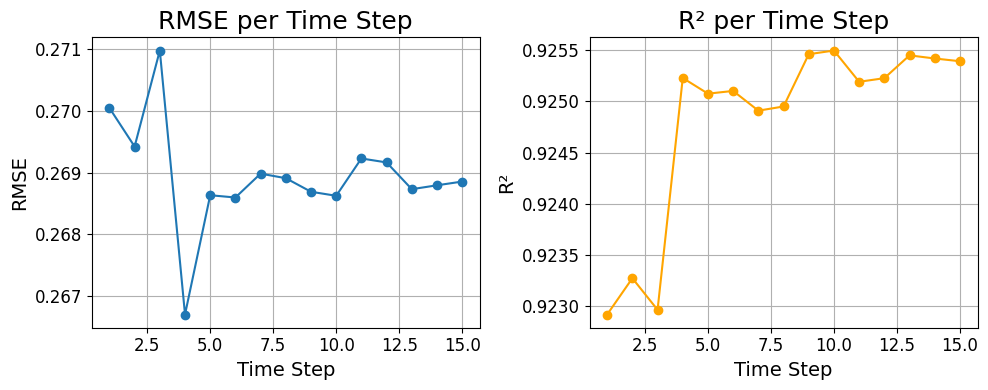

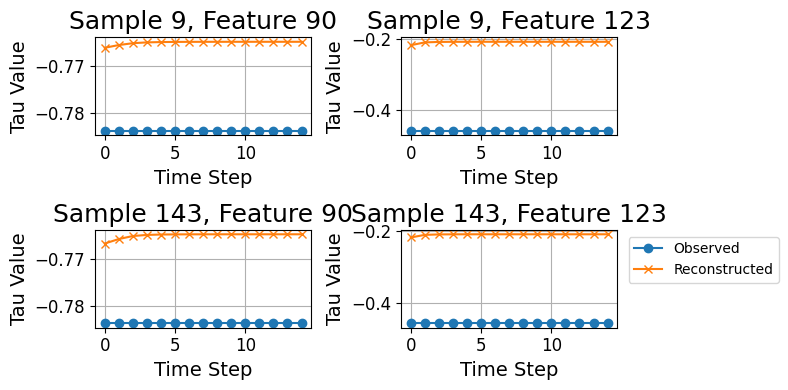

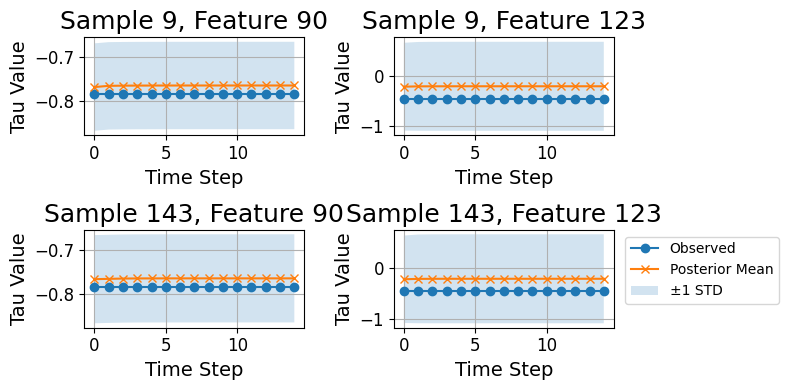

In [ ]:
# 1) Prepare raw inputs
tau_input_np = np.nan_to_num(tau_tensor, 0.0).astype("float32")
mask_np = (~np.isnan(tau_tensor)).astype("float32")
context_input_np = np.nan_to_num(context_tensor, 0.0).astype("float32")

N, T, F = tau_input_np.shape
_, _, C = context_input_np.shape

# 2) Split into train/val/test
val_frac, test_frac = 0.1, 0.1
idx = np.random.permutation(N)
n_val = int(N * val_frac)
n_test = int(N * test_frac)
val_idx = idx[:n_val]
test_idx = idx[n_val:n_val + n_test]
train_idx = idx[n_val + n_test:]

tau_train, mask_train, ctx_train = tau_input_np[train_idx], mask_np[train_idx], context_input_np[train_idx]
tau_val, mask_val, ctx_val = tau_input_np[val_idx], mask_np[val_idx], context_input_np[val_idx]
tau_test, mask_test, ctx_test = tau_input_np[test_idx], mask_np[test_idx], context_input_np[test_idx]

# 3) Normalization
flat_tau = tau_train.reshape(-1, F)
flat_mask = mask_train.reshape(-1, F)
sum_mask = flat_mask.sum(axis=0, keepdims=True)
mean_tau = (flat_tau * flat_mask).sum(axis=0, keepdims=True) / np.maximum(sum_mask, 1.0)
var_tau = ((flat_mask * (flat_tau - mean_tau)**2).sum(axis=0, keepdims=True)) / np.maximum(sum_mask, 1.0)
std_tau = np.sqrt(var_tau + 1e-6)

mean_ctx = ctx_train.mean(axis=(0, 1), keepdims=True)
std_ctx = ctx_train.std(axis=(0, 1), keepdims=True) + 1e-6

def normalize_split(tau, mask, ctx):
    tau_n = ((tau - mean_tau) / std_tau) * mask
    ctx_n = (ctx - mean_ctx) / std_ctx
    return tau_n, mask, ctx_n

tau_train, mask_train, ctx_train = normalize_split(tau_train, mask_train, ctx_train)
tau_val, mask_val, ctx_val = normalize_split(tau_val, mask_val, ctx_val)
tau_test, mask_test, ctx_test = normalize_split(tau_test, mask_test, ctx_test)

# 4) Sampling layer
def sampling(args):
    mu, lv = args
    lv = tf.clip_by_value(lv, -10.0, 10.0)
    std = tf.exp(0.5 * lv)
    eps = tf.random.normal(tf.shape(mu))
    return mu + std * eps

# 5) Encoder
inp_tau = layers.Input(shape=(T, F), name="tau_in")
inp_mask = layers.Input(shape=(T, F), name="mask_in")
inp_ctx = layers.Input(shape=(T, C), name="ctx_in")

x = layers.Concatenate(axis=-1)([
    layers.Multiply()([inp_tau, inp_mask]),
    inp_mask,
    inp_ctx
])
h = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
h = layers.Dense(256, activation='relu')(h)
h = layers.LayerNormalization()(h)
h = layers.Dropout(0.2)(h)

latent_dim = 32
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_logvar = layers.Dense(latent_dim, name="z_logvar")(h)
z = layers.Lambda(sampling, name="z")([z_mean, z_logvar])

encoder = Model([inp_tau, inp_mask, inp_ctx], [z_mean, z_logvar, z], name="encoder")

# 6) Decoder
mdn_components = 5
z_in = layers.Input(shape=(latent_dim,), name="z_in")
d = layers.Dense(256, activation='relu')(z_in)
d = layers.LayerNormalization()(d)
d = layers.Dropout(0.2)(d)
d = layers.RepeatVector(T)(d)
d = layers.LSTM(128, return_sequences=True)(d)
d = layers.TimeDistributed(layers.Dense(256, activation='relu'))(d)
d = layers.LayerNormalization()(d)
d = layers.Dropout(0.2)(d)

pi_hat = layers.TimeDistributed(layers.Dense(F * mdn_components))(d)
mu_hat = layers.TimeDistributed(layers.Dense(F * mdn_components))(d)
rawvar_hat = layers.TimeDistributed(layers.Dense(F * mdn_components))(d)

pi = layers.Reshape((T, F, mdn_components))(pi_hat)
mu = layers.Reshape((T, F, mdn_components))(mu_hat)
rawvar = layers.Reshape((T, F, mdn_components))(rawvar_hat)
pi = layers.Softmax(axis=-1, name="pi")(pi)

decoder = Model(z_in, [pi, mu, rawvar], name="decoder")

# 7) CVAE-MDN model
class CVAE_MDN(Model):
    def __init__(self, encoder, decoder, beta=0.0, eps_min=1e-2, **kwargs):
        super().__init__(inputs=encoder.inputs, outputs=[decoder(encoder.outputs[2])], **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.eps_min = eps_min
        print("Model input shapes:", [input.shape for input in encoder.inputs])

    def build(self, input_shape=None):
        self._input_spec = [
            tf.keras.layers.InputSpec(shape=(None, 15, 125), dtype=tf.float32),
            tf.keras.layers.InputSpec(shape=(None, 15, 125), dtype=tf.float32),
            tf.keras.layers.InputSpec(shape=(None, 15, 286), dtype=tf.float32)
        ]
        super().build(self._input_spec)

    def call(self, inputs, training=False):
        if isinstance(inputs, dict):
            tau = inputs["tau_in"]
            mask = inputs["mask_in"]
            ctx = inputs["ctx_in"]
        elif isinstance(inputs, (list, tuple)) and len(inputs) == 3:
            tau, mask, ctx = inputs
        else:
            raise ValueError(f"Expected dict or list/tuple of 3 tensors, got {type(inputs)}")
        tf.print("call input shapes:", tf.shape(tau), tf.shape(mask), tf.shape(ctx))
        z_mean, z_logvar, z = self.encoder([tau, mask, ctx], training=training)
        pi, mu, rawvar = self.decoder(z, training=training)
        return tf.reduce_sum(pi * mu, axis=-1)

    def mdn_nll(self, tau, mask, pi, mu, rawvar):
        var = tf.nn.softplus(rawvar) + self.eps_min
        logvar = tf.math.log(var)
        invvar = tf.exp(-logvar)
        tau_e = tf.expand_dims(tau, -1)
        comp = -0.5 * (logvar + (tau_e - mu)**2 * invvar)
        logp = tf.math.log(pi + 1e-6) + comp
        logp_m = tf.reduce_logsumexp(logp, axis=-1)
        return -tf.reduce_sum(mask * logp_m, axis=[1, 2])

    def compute_loss(self, x, y=None, y_pred=None, sample_weight=None):
        if isinstance(x, dict):
            tau = x["tau_in"]
            mask = x["mask_in"]
            ctx = x["ctx_in"]
        elif isinstance(x, (list, tuple)) and len(x) == 3:
            tau, mask, ctx = x
        else:
            raise ValueError(f"Expected dict or list/tuple of 3 tensors, got {type(x)}")
        z_mean, z_logvar, z = self.encoder([tau, mask, ctx], training=True)
        pi, mu, rawvar = self.decoder(z, training=True)
        rec_nll = self.mdn_nll(tau, mask, pi, mu, rawvar)
        kl = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        return tf.reduce_mean(rec_nll + self.beta * kl)

    def train_step(self, data):
        if isinstance(data, dict):
            tau = data["tau_in"]
            mask = data["mask_in"]
            ctx = data["ctx_in"]
        elif isinstance(data, (list, tuple)) and len(data) == 3:
            tau, mask, ctx = data
        else:
            raise ValueError(f"Expected data to be a dict or tuple/list of 3 tensors, got {type(data)}")
        tf.debugging.assert_rank(tau, 3)
        tf.debugging.assert_rank(mask, 3)
        tf.debugging.assert_rank(ctx, 3)
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        grads = tape.gradient(loss, self.trainable_variables)
        grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        tf.print("train_step — loss:", loss)
        return {"loss": loss}

    def sample(self, inputs):
        if isinstance(inputs, dict):
            tau = inputs["tau_in"]
            mask = inputs["mask_in"]
            ctx = inputs["ctx_in"]
        elif isinstance(inputs, (list, tuple)) and len(inputs) == 3:
            tau, mask, ctx = inputs
        else:
            raise ValueError(f"Expected dict or list/tuple of 3 tensors, got {type(inputs)}")
        z_mean, z_logvar, z = self.encoder([tau, mask, ctx], training=False)
        pi, mu, rawvar = self.decoder(z, training=False)
        var = tf.nn.softplus(rawvar) + self.eps_min

        logits = tf.reshape(tf.math.log(pi + 1e-8), [-1, mdn_components])
        cat = tf.random.categorical(logits, 1)
        cat = tf.cast(cat, tf.int32)
        cat = tf.reshape(cat, [-1, T, F])

        batch_idx = tf.range(tf.shape(mu)[0])[:, None, None]
        t_idx = tf.range(T)[None, :, None]
        f_idx = tf.range(F)[None, None, :]
        idx = tf.stack([batch_idx * tf.ones_like(cat), t_idx * tf.ones_like(cat), f_idx * tf.ones_like(cat), cat], axis=-1)

        chosen_mu = tf.gather_nd(mu, idx)
        chosen_var = tf.gather_nd(var, idx)
        eps = tf.random.normal(tf.shape(chosen_mu))
        return chosen_mu + tf.sqrt(chosen_var) * eps

# 8) Callbacks
def masked_mse(y_true, y_pred, mask): return tf.reduce_mean(tf.square((y_true - y_pred) * mask))
def masked_mae(y_true, y_pred, mask): return tf.reduce_mean(tf.abs((y_true - y_pred) * mask))

class ValMetrics(tf.keras.callbacks.Callback):
    def __init__(self, data): 
        super().__init__()
        self.data = data
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        try:
            tau_v, mask_v, ctx_v = self.data
            inputs = {"tau_in": tau_v, "mask_in": mask_v, "ctx_in": ctx_v}
            tf.print("ValMetrics input shapes:", tf.shape(tau_v), tf.shape(mask_v), tf.shape(ctx_v))
            pred = self.model(inputs, training=False)
            mse = masked_mse(tau_v, pred, mask_v).numpy()
            mae = masked_mae(tau_v, pred, mask_v).numpy()
            logs["val_masked_mse"] = mse
            logs["val_masked_mae"] = mae
            print(f"Epoch {epoch + 1} — val_masked_mse: {mse:.4f}, val_masked_mae: {mae:.4f}")
        except Exception as e:
            print(f"ValMetrics error: {str(e)}")
            raise

class BetaScheduler(tf.keras.callbacks.Callback):
    def __init__(self, cvae, n_epochs, final_beta=0.5):
        super().__init__()
        self.cvae = cvae
        self.n_epochs = n_epochs
        self.final_beta = final_beta
    def on_epoch_begin(self, epoch, logs=None):
        beta = self.final_beta * min(1.0, epoch / (self.n_epochs * 0.3))
        self.cvae.beta = beta
        print(f"→ setting β={beta:.4f}")

class PrintLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1} — train_loss: {logs.get('loss', 'N/A'):.4f}")

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_masked_mse", patience=10, restore_best_weights=True, mode='min')

# 9) Train
cvae = CVAE_MDN(encoder, decoder, beta=0.0)
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda *_: 0.0, run_eagerly=True)
cvae.build(input_shape=[(None, T, F), (None, T, F), (None, T, C)])

# Debug shapes before training
print("Training data shapes:", tau_train.shape, mask_train.shape, ctx_train.shape)
print("Validation data shapes:", tau_val.shape, mask_val.shape, ctx_val.shape)

# Create datasets with dictionary output
train_dataset = tf.data.Dataset.from_tensor_slices({
    "tau_in": tau_train,
    "mask_in": mask_train,
    "ctx_in": ctx_train
}).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices({
    "tau_in": tau_val,
    "mask_in": mask_val,
    "ctx_in": ctx_val
}).batch(64)

# Debug datasets
for batch in train_dataset.take(1):
    print("Batch type:", type(batch))
    print("Batch keys:", list(batch.keys()))
    for key, tensor in batch.items():
        print(f"{key} shape:", tensor.shape)

for batch in val_dataset.take(1):
    print("Validation batch type:", type(batch))
    print("Validation batch keys:", list(batch.keys()))
    for key, tensor in batch.items():
        print(f"Validation {key} shape:", tensor.shape)

# Train the model
history = cvae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[earlystop, ValMetrics((tau_val, mask_val, ctx_val)), BetaScheduler(cvae, 5), PrintLoss()]
)

#  10) Evaluate
def evaluate_cvae(model, tau, mask, ctx, std_tau, mean_tau, n_samples=30, denorm=False):
    assert mask.sum() > 0, "Test mask is entirely zero"
    inputs = {"tau_in": tau, "mask_in": mask, "ctx_in": ctx}
    tf.print("evaluate_cvae input shapes:", tf.shape(tau), tf.shape(mask), tf.shape(ctx))
    
    # Deterministic prediction
    tau_det = model(inputs, training=False).numpy()
    
    # Compute masked MSE and MAE
    mse_det = ((tau - tau_det)**2 * mask).sum() / mask.sum()
    mae_det = (np.abs(tau - tau_det) * mask).sum() / mask.sum()
    
    # Compute R squared
    masked_tau = tau * mask
    masked_tau_det = tau_det * mask
    mean_tau_masked = masked_tau.sum() / mask.sum()
    ss_tot = ((masked_tau - mean_tau_masked)**2 * mask).sum()
    ss_res = ((masked_tau - masked_tau_det)**2 * mask).sum()
    r2_det = 1 - ss_res / (ss_tot + 1e-6)
    
    # Compute Pearson r
    valid_idx = mask.ravel() > 0
    tau_flat = masked_tau.ravel()[valid_idx]
    tau_det_flat = masked_tau_det.ravel()[valid_idx]
    pearson_r, _ = pearsonr(tau_flat, tau_det_flat) if len(tau_flat) > 1 else (np.nan, np.nan)
    
    print(f"[Deterministic] masked MSE: {mse_det:.4f}, MAE: {mae_det:.4f}, "
          f"R2: {r2_det:.4f}, Pearson r: {pearson_r:.4f}")

    # Stochastic predictions
    mse_samps, mae_samps = [], []
    for _ in range(n_samples):
        samp = model.sample(inputs).numpy()
        mse_samps.append(((tau - samp)**2 * mask).sum() / mask.sum())
        mae_samps.append((np.abs(tau - samp) * mask).sum() / mask.sum())
    mse_samps, mae_samps = np.array(mse_samps), np.array(mae_samps)
    print(f"[Stochastic] masked MSE: {mse_samps.mean():.4f} ± {mse_samps.std():.4f}, "
          f"MAE: {mae_samps.mean():.4f} ± {mae_samps.std():.4f}")

    # Denormalized metrics
    if denorm:
        tau_det_dn = tau_det * std_tau + mean_tau
        tau_true_dn = tau * std_tau + mean_tau
        mse_dn = ((tau_true_dn - tau_det_dn)**2 * mask).sum() / mask.sum()
        mae_dn = (np.abs(tau_true_dn - tau_det_dn) * mask).sum() / mask.sum()
        print(f"[Denormalized] masked MSE: {mse_dn:.2f}, MAE: {mae_dn:.2f}")

    # RMSE and R squared per time step
    T = tau.shape[1]
    rmse_per_t, r2_per_t = [], []
    for t in range(T):
        mask_t = mask[:, t, :]
        tau_t = tau[:, t, :]
        tau_det_t = tau_det[:, t, :]
        mse_t = ((tau_t - tau_det_t)**2 * mask_t).sum() / mask_t.sum()
        rmse_t = np.sqrt(mse_t)
        mean_tau_t = (tau_t * mask_t).sum() / mask_t.sum()
        ss_tot_t = ((tau_t - mean_tau_t)**2 * mask_t).sum()
        ss_res_t = ((tau_t - tau_det_t)**2 * mask_t).sum()
        r2_t = 1 - ss_res_t / (ss_tot_t + 1e-6)
        rmse_per_t.append(rmse_t)
        r2_per_t.append(r2_t)
        print(f"Time step {t+1}: RMSE: {rmse_t:.4f}, R²: {r2_t:.4f}")

    # Plot RMSE and R squared per time step
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, T+1), rmse_per_t, marker='o')
    plt.xlabel("Time Step")
    plt.ylabel("RMSE")
    plt.title("RMSE per Time Step")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, T+1), r2_per_t, marker='o', color='orange')
    plt.xlabel("Time Step")
    plt.ylabel("R²")
    plt.title("R² per Time Step")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Select 2 representative samples & features
    np.random.seed(42)
    n_samples_to_plot = 2
    sample_indices = np.random.choice(tau.shape[0], n_samples_to_plot, replace=False)

    # Determine features with lowest & highest RMSE
    per_feature_mse = ((tau - tau_det)**2 * mask).sum(axis=(0,1)) / mask.sum(axis=(0,1))
    per_feature_rmse = np.sqrt(per_feature_mse)
    n_features_to_plot = 2
    easy_count = n_features_to_plot // 2
    hard_count = n_features_to_plot - easy_count
    sorted_idx = np.argsort(per_feature_rmse)
    easy_feats = sorted_idx[:easy_count]
    hard_feats = sorted_idx[-hard_count:]
    feature_indices = np.concatenate([easy_feats, hard_feats])

    # Plot observed vs. reconstructed tau trajectories (2x2 grid)
    plt.figure(figsize=(8, 4))
    for i, idx in enumerate(sample_indices):
        for j, f in enumerate(feature_indices):
            ax = plt.subplot(n_samples_to_plot, n_features_to_plot, i * n_features_to_plot + j + 1)
            ax.plot(tau[idx, :, f], label="Observed", marker='o')
            ax.plot(tau_det[idx, :, f], label="Reconstructed", marker='x')
            ax.set_title(f"Sample {idx}, Feature {f}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Tau Value")
            ax.grid(True)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Posterior mean and variance vs. observed (2x2 grid)
    _, _, z = model.encoder([tau, mask, ctx], training=False)
    pi, mu, rawvar = model.decoder(z, training=False)
    var = tf.nn.softplus(rawvar) + model.eps_min
    posterior_mean = tf.reduce_sum(pi * mu, axis=-1).numpy()
    posterior_var = (
        tf.reduce_sum(pi * (var + mu**2), axis=-1).numpy()
        - posterior_mean**2
    )

    plt.figure(figsize=(8, 4))
    for i, idx in enumerate(sample_indices):
        for j, f in enumerate(feature_indices):
            ax = plt.subplot(n_samples_to_plot, n_features_to_plot, i * n_features_to_plot + j + 1)
            ax.plot(tau[idx, :, f], label="Observed", marker='o')
            ax.plot(posterior_mean[idx, :, f], label="Posterior Mean", marker='x')
            std = np.sqrt(posterior_var[idx, :, f])
            ax.fill_between(
                range(T),
                posterior_mean[idx, :, f] - std,
                posterior_mean[idx, :, f] + std,
                alpha=0.2,
                label="±1 STD"
            )
            ax.set_title(f"Sample {idx}, Feature {f}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Tau Value")
            ax.grid(True)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return tau_det

# Debug test set shapes & call
print("Test data shapes:", tau_test.shape, mask_test.shape, ctx_test.shape)
tau_det_test = evaluate_cvae(
    cvae, tau_test, mask_test, ctx_test,
    std_tau, mean_tau,
    n_samples=30,
    denorm=True
)

## <center> Step 20:  Integrate CVAE Predictions into the Cohort Time-Series
Here we take the CVAE’s reconstructed tau trajectories for our test subjects and seamlessly fold them back into the full cohort timeline. First, we denormalize the model’s outputs by multiplying by the training‐set standard deviations and adding back the means, yielding tau_synth_denorm on the original biomarker scale. We then map each row of this tensor back to the corresponding subject ID using our test_idx array, and verify that the feature dimension matches the combined list of CSF, PET‐tau, and plasma pTau variables. Next, we flatten these predictions into a long‐format DataFrame, with one row per subject per visit code, so that each column holds the denormalized value for a specific tau feature at that timepoint. Applying our create_modality_tensor helper to this DataFrame reconstructs a test‐only tensor of shape (n_test_subjects × n_visits × n_features). Finally, we invoke add_missing to pad this test tensor into the full subject set by inserting rows of NaNs for training and validation subjects, ensuring that tau_tensor_synth has the same ordering and dimensions as all our other modality tensors. A final print statement confirms that the synthesized tau tensor has been created with the expected shape.

In [25]:
# Wrap CVAE-generated tau values into a tensor aligned to union_rids

# Denormalize the CVAE output (only for test subjects)
tau_synth_denorm = tau_det_test * std_tau + mean_tau  # shape: (n_test, T, F)

#  Map test indices back to RIDs
test_rids = [union_rids[i] for i in test_idx]

# Full feature list you used for tau_tensor
tau_feature_names = STATIC_TAU_COLUMNS + PET_TAU_COLUMNS + PLASMA_PTAU_COLUMNS
assert len(tau_feature_names) == tau_synth_denorm.shape[-1]

# Sanity‐check shapes
n_test, T_pred, F_pred = tau_synth_denorm.shape
assert n_test == len(test_rids)
assert T_pred == len(expected_visits)

# Build long‐format DataFrame for test set
rows = []
for i, rid in enumerate(test_rids):
    for t, visit in enumerate(expected_visits):
        row = {"RID": rid, "VISCODE": visit}
        for j, feat in enumerate(tau_feature_names):
            row[feat] = tau_synth_denorm[i, t, j]
        rows.append(row)

tau_df_synth = pd.DataFrame(rows)

# Reconstruct a tensor aligned to test_rids
tau_tensor_test, rids_present = create_modality_tensor(
    tau_df_synth,
    modality_vars=tau_feature_names
)

# Pad/mask it out to the full union_rids (train+val rows become NaN)
tau_tensor_synth = add_missing(
    tau_tensor_test,
    rids_present,
    union_rids
)

print("tau_tensor_synth created:", tau_tensor_synth.shape)

tau_tensor_synth created: (2271, 15, 125)


## <center> Step 21: Generate Multiple Stratified Splits with Diagnosis-Aware Imputation, Stats-PCA, Background Augmentation & Scaling
In this block we first one-time prepare our diagnosis labels (encoding them numerically) and build an aligned xarray dataset that holds every modality tensor: cognitive tests, MRI, PET, assessments, metabolomics, regression targets, synthesized tau trajectories, and static features, indexed by the same ordered list of subject IDs and visit codes. We then extract the subset of subjects present in both our aligned dataset and the diagnosis table, preserving their encoded labels for stratification. Next, we take a clean copy of our per-subject statistical features and ensure it’s keyed by RID.

We define a custom DiagnosisKNNImputer that fits separate KNN imputers (with scaling) for each diagnostic group, filling numeric fields by nearest neighbors and categorical fields by mode. Then, for each of 10 random seeds, we perform a stratified 60/20/20 train/val/test split on subject IDs, slice our aligned xarray into corresponding sub-datasets, and pull out the diagnosis labels for each split. Inside the loop, we merge the static features with their diagnoses, run the diagnosis-aware KNN imputer, standard-scale, and apply PCA (capturing 91% variance) to reduce dimensionality, treating this pipeline as part of our feature preparation.

Finally, we flatten and scale both the regression target tensor and the synthesized tau tensor, fitting a separate StandardScaler on the training flattenings, then reshaping back into (subjects x visits x features) for each split. All of these objects, split IDs, label arrays, PCA results, enriched background tables, fitted scalers, and scaled time-series tensors are collected into a list of dictionaries (all_splits) for downstream modeling, allowing consistent evaluation across repeated, stratified folds.

In [26]:
# One-time prep outside the loop

# (0) Encode diagnosis
subject_diagnosis = subject_diagnosis.copy()
subject_diagnosis["RID"] = subject_diagnosis["RID"].astype(str)
if "DIAGNOSIS_ENC" not in subject_diagnosis.columns:
    subject_diagnosis["DIAGNOSIS_ENC"] = (
        subject_diagnosis["DIAGNOSIS"].astype("category").cat.codes
    )

# (1) Build aligned xarray
ds_aligned = xr.Dataset({
    "cognitive":      (("subject", "visit", "cognitive_feature"),      cognitive_tensor),
    "mri":            (("subject", "visit", "mri_feature"),            mri_tensor),
    "pet":            (("subject", "visit", "pet_feature"),            pet_tensor),
    "assessment":     (("subject", "visit", "assessment_feature"),     assess_tensor),
    "neuropathology": (("subject", "visit", "neuropathology_feature"), neuropath_tensor),
    "regression":     (("subject", "visit", "regression_feature"),     reg_tensor),
    "tau":            (("subject", "visit", "tau_feature"),            tau_tensor_synth),
    "static":         (("subject", "static_feature"),                  static_features),
}, coords={
    "subject":               union_rids,
    "visit":                 expected_visits,
    "cognitive_feature":      np.arange(cognitive_tensor.shape[2]),
    "mri_feature":            np.arange(mri_tensor.shape[2]),
    "pet_feature":            np.arange(pet_tensor.shape[2]),
    "assessment_feature":     np.arange(assess_tensor.shape[2]),
    "neuropathology_feature": np.arange(neuropath_tensor.shape[2]),
    "regression_feature":     np.arange(reg_tensor.shape[2]),
    "tau_feature":            np.arange(tau_tensor_synth.shape[2]),
    "static_feature":         np.arange(static_features.shape[1]),
})

# (2) Intersect subjects + gather labels
common_rids = sorted(set(ds_aligned.subject.values) & set(subject_diagnosis.RID))
subject_diag_common = (
    subject_diagnosis.set_index("RID")
                     .loc[common_rids]
                     .reset_index()
)
diag_labels = subject_diag_common["DIAGNOSIS_ENC"].values

# Keep a pristine copy of stats_features
if stats_features.index.name == "RID":
    stats_base = stats_features.reset_index()
else:
    stats_base = stats_features.copy()
stats_base["RID"] = stats_base["RID"].astype(str)

# (3) Diagnosis-aware KNN imputer
class DiagnosisKNNImputer(BaseEstimator, TransformerMixin):
    """
    Diagnosis-aware KNN imputer that fits a separate KNNImputer (with scaling) for each
    diagnostic group on the specified numeric columns and fills categorical columns
    with the group mode.

    Parameters
    ----------
    numeric_cols : list of str
        Names of numeric columns to impute via KNN.
    categorical_cols : list of str, default=()
        Names of categorical columns to impute via mode.
    k : int, default=10
        Number of neighbors for the KNNImputer.
    """
    def __init__(self, numeric_cols, categorical_cols=(), k=10):
        self.numeric_cols = list(numeric_cols)
        self.categorical_cols = list(categorical_cols)
        self.k = k
        self.imputers_ = {}

    def fit(self, X, y=None):
        for diag, sub in X.groupby("DIAGNOSIS_ENC"):
            num = sub[self.numeric_cols].fillna(0)
            scaler = StandardScaler().fit(num)
            knn = KNNImputer(n_neighbors=self.k)
            knn.fit(scaler.transform(num))
            self.imputers_[diag] = (scaler, knn)
        return self

    def transform(self, X):
        X = X.copy()
        for diag, idx in X.groupby("DIAGNOSIS_ENC").groups.items():
            scaler, knn = self.imputers_[diag]
            block = X.loc[idx, self.numeric_cols].fillna(0)
            imputed = scaler.inverse_transform(knn.transform(scaler.transform(block)))
            X.loc[idx, self.numeric_cols] = imputed
            for col in self.categorical_cols:
                mode = X.loc[idx, col].mode()
                if not mode.empty:
                    X.loc[idx, col] = X.loc[idx, col].fillna(mode.iloc[0])
        return X

# Loop over splits #
n_repeats = 10
all_splits = []

for seed in range(n_repeats):
    # 4) Stratified 60/20/20 split
    r_train, r_temp = train_test_split(
        common_rids, test_size=0.4, random_state=seed, stratify=diag_labels
    )
    temp_lbls = subject_diag_common.set_index("RID").loc[r_temp]["DIAGNOSIS_ENC"]
    r_val, r_test = train_test_split(
        r_temp, test_size=0.5, random_state=seed, stratify=temp_lbls
    )
    train_ids, val_ids, test_ids = map(sorted, (r_train, r_val, r_test))

    # 5) Slice xarray by subject
    ds_tr  = ds_aligned.sel(subject=train_ids)
    ds_val = ds_aligned.sel(subject=val_ids)
    ds_te  = ds_aligned.sel(subject=test_ids)

    # 6) Extract labels
    y_tr = subject_diag_common.set_index("RID").loc[train_ids]["DIAGNOSIS_ENC"].values
    y_va = subject_diag_common.set_index("RID").loc[val_ids]["DIAGNOSIS_ENC"].values
    y_te = subject_diag_common.set_index("RID").loc[test_ids]["DIAGNOSIS_ENC"].values

    # 7) Stats‐PCA pipeline inside loop
    sf = (stats_base
          .merge(subject_diag_common[["RID","DIAGNOSIS_ENC"]], on="RID", how="left")
          .set_index("RID"))

    agg_numeric = [c for c in sf.columns if c != "DIAGNOSIS_ENC"]
    sf[agg_numeric] = sf[agg_numeric].astype(float)

    train_idx = [rid for rid in train_ids if rid in sf.index]
    val_idx   = [rid for rid in val_ids   if rid in sf.index]
    test_idx  = [rid for rid in test_ids  if rid in sf.index]

    pipeline = Pipeline([
        ("diag_knn", DiagnosisKNNImputer(numeric_cols=agg_numeric, k=10)),
        ("scaler",   StandardScaler()),
        ("pca",      PCA(n_components=0.91, random_state=seed)),
    ])

    train_df = sf.loc[train_idx]
    val_df   = sf.loc[val_idx]
    test_df  = sf.loc[test_idx]

    pipeline.fit(train_df)
    pca_tr = pipeline.transform(train_df)
    pca_va = pipeline.transform(val_df)
    pca_te = pipeline.transform(test_df)

    pca_cols = [f"stats_PCA_{i+1}" for i in range(pca_tr.shape[1])]
    df_tr = pd.DataFrame(pca_tr, index=train_df.index, columns=pca_cols)
    df_va = pd.DataFrame(pca_va, index=val_df.index,   columns=pca_cols)
    df_te = pd.DataFrame(pca_te, index=test_df.index,  columns=pca_cols)
    stats_pca_df = pd.concat([df_tr, df_va, df_te]).sort_index()

    # 8) Merge PCA into background
    bg = final_static.copy()
    if bg.index.name == "RID":
        bg = bg.reset_index()
    bg["RID"] = bg["RID"].astype(str)
    background_with_stats = bg.merge(
        stats_pca_df.reset_index(), on="RID", how="left"
    )

    # 9) Regression cleaning & scaling
    def clean_and_flatten(da):
        arr = np.nan_to_num(da.values, nan=0.0, posinf=0.0, neginf=0.0)
        s0,s1,s2 = arr.shape
        return arr.reshape(-1, s2), arr

    flat_tr, reg_tr = clean_and_flatten(ds_tr["regression"])
    _,       reg_va = clean_and_flatten(ds_val["regression"])
    _,       reg_te = clean_and_flatten(ds_te["regression"])

    scaler_reg = StandardScaler().fit(flat_tr)

    def reshape_and_apply(tensor, scaler):
        s0,s1,s2 = tensor.shape
        scaled = scaler.transform(tensor.reshape(-1, s2))
        return scaled.reshape(s0, s1, s2)

    regression_scaled = {
        "train": reshape_and_apply(reg_tr, scaler_reg),
        "val":   reshape_and_apply(reg_va, scaler_reg),
        "test":  reshape_and_apply(reg_te, scaler_reg),
    }

    # 9b) Tau cleaning & scaling (same logic)
    flat_tr, tau_tr = clean_and_flatten(ds_tr["tau"])
    _,      tau_va  = clean_and_flatten(ds_val["tau"])
    _,      tau_te  = clean_and_flatten(ds_te["tau"])

    scaler_tau = StandardScaler().fit(flat_tr)

    tau_scaled = {
        "train": reshape_and_apply(tau_tr, scaler_tau),
        "val":   reshape_and_apply(tau_va, scaler_tau),
        "test":  reshape_and_apply(tau_te, scaler_tau),
    }

    # 10) Store split outputs
    all_splits.append({
        "seed":                   seed,
        "train_ids":              train_ids,
        "val_ids":                val_ids,
        "test_ids":               test_ids,
        "y":                      {"train": y_tr, "val": y_va, "test": y_te},
        "stats_pca_df":           stats_pca_df,
        "background_with_stats":  background_with_stats,
        "regression_scaler":      scaler_reg,
        "regression_scaled":      regression_scaled,
        "tau_scaler":             scaler_tau,
        "tau_scaled":             tau_scaled
    })

print(f"Finished processing {len(all_splits)} splits.")

Finished processing 10 splits.


## <center> Step 22: Inspect Each Split’s Data Shapes
We loop over each of our stratified splits and perform a thorough sanity check of every data structure. For each seed’s split, we first re‐slice the aligned xarray dataset into training, validation and test subsets and print the shape of each modality tensor (cognitive, mri, pet, assessment, neuropathology, regression, tau, and static) to confirm the dimensions match expectations. We then report the shape of the diagnosis label arrays (y_train, y_val, y_test) to ensure the correct number of subjects in each partition. Next, we display the shape of the per‐split stats_pca_df, verifying the number of rows equals the total subjects in that split and the number of PCA components, and the shape of the background_with_stats table, which combines static baseline features with the PCA results. Finally, we print the shapes of the flattened and scaled regression and tau tensors for train, validation and test, confirming that all time‐series inputs have been correctly processed and aligned across every split before proceeding to model training.

In [27]:
for split in all_splits:
    seed = split["seed"]
    print(f"\n=== Split {seed} ===")

    # Re‐slice xarray for this split
    train_ids = split["train_ids"]
    val_ids   = split["val_ids"]
    test_ids  = split["test_ids"]

    ds_tr  = ds_aligned.sel(subject=train_ids)
    ds_val = ds_aligned.sel(subject=val_ids)
    ds_te  = ds_aligned.sel(subject=test_ids)

    # 1) Feature modalities
    for phase, ds in [("TRAIN", ds_tr), ("VAL", ds_val), ("TEST", ds_te)]:
        print(f"\n  {phase} modal shapes:")
        for var in ds.data_vars:
            arr = ds[var].values
            print(f"    {var:<14}: {arr.shape}")

    # 2) y‐labels
    for phase in ["train", "val", "test"]:
        y = split["y"][phase]
        print(f"  {phase.upper()} y shape: {y.shape}")

    # 3) stats_pca_df
    pca_df = split["stats_pca_df"]
    print(f"  stats_pca_df shape:           {pca_df.shape}")

    # 4) background_with_stats
    bg = split["background_with_stats"]
    print(f"  background_with_stats shape:  {bg.shape}")

    # 5) regression_scaled
    print("  regression_scaled shapes:")
    for phase in ["train", "val", "test"]:
        reg = split["regression_scaled"][phase]
        print(f"    {phase:<5}: {reg.shape}")

    # 6) tau_scaled
    print("  tau_scaled shapes:")
    for phase in ["train", "val", "test"]:
        tau = split["tau_scaled"][phase]
        print(f"    {phase:<5}: {tau.shape}")


=== Split 0 ===

  TRAIN modal shapes:
    cognitive     : (1362, 15, 63)
    mri           : (1362, 15, 111)
    pet           : (1362, 15, 20)
    assessment    : (1362, 15, 62)
    neuropathology: (1362, 15, 50)
    regression    : (1362, 15, 4)
    tau           : (1362, 15, 125)
    static        : (1362, 222)

  VAL modal shapes:
    cognitive     : (454, 15, 63)
    mri           : (454, 15, 111)
    pet           : (454, 15, 20)
    assessment    : (454, 15, 62)
    neuropathology: (454, 15, 50)
    regression    : (454, 15, 4)
    tau           : (454, 15, 125)
    static        : (454, 222)

  TEST modal shapes:
    cognitive     : (455, 15, 63)
    mri           : (455, 15, 111)
    pet           : (455, 15, 20)
    assessment    : (455, 15, 62)
    neuropathology: (455, 15, 50)
    regression    : (455, 15, 4)
    tau           : (455, 15, 125)
    static        : (455, 222)
  TRAIN y shape: (1362,)
  VAL y shape: (454,)
  TEST y shape: (455,)
  stats_pca_df shape:        

## <center> Step 23: Build, Train & Evaluate Multimodal Multi-Task Base and Uncertainty Models
We define CNN-BiLSTM pipelines for each time-series modality (cognitive tests, MRI, PET, assessments, neuropathology, tau) and a fully connected network for static background features. We fuse all modality representations by concatenating their time-distributed outputs with a tiled background embedding, extracting the final time step, and passing it through a shared dense block. From this shared representation we branch into a classification head (predicting CN/MCI/AD) and four regression heads (predicting ADAS-13, MMSE, FAQ total, and CDR-SB). To capture predictive uncertainty, we wrap this base model in a custom MultiTaskUncertaintyModel that learns a log-variance parameter for each output and applies an uncertainty-weighted loss combining cross-entropy (for classification) and MSE (for regression).

We then iterate over each stratified split in all_splits: we prepare fold-specific training, validation, and test data (inputs plus true outcomes) via a helper that flattens and scales the final time-point regression targets; compute balanced class weights for the classification loss; set up callbacks (early stopping, CSV logging, epoch printing); and train both the base model and the uncertainty model for up to 100 epochs. After each fold we predict on the test set, compute classification metrics (F1, precision, recall, accuracy) and regression metrics (R², Pearson’s r, MAE, RMSE) for both models, and append them to a CSV log.

Once all splits are processed, we aggregate metrics across folds, compute their means and standard deviations, and visualize comparison bar charts for classification performance. For the first fold, we also plot confusion matrices side-by-side for the base vs uncertainty models, scatter true vs. predicted regression outcomes with diagnostic guards and best-fit lines, and generate saliency heatmaps over time steps to highlight which modalities are most influential for each regression head under both modeling frameworks. This comprehensive evaluation completes our multimodal, multi-task learning pipeline with both point estimates and uncertainty quantification.

[Fold 0] Epoch 1
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - classification_loss: 1.2581 - loss: 32.8442 - regression_adas_loss: 1.3410 - regression_cdrsb_loss: 1.4023 - regression_faq_loss: 2.0351 - regression_mmse_loss: 1.5961 - val_classification_loss: 1.1823 - val_loss: 30.3055 - val_regression_adas_loss: 1.3043 - val_regression_cdrsb_loss: 1.2948 - val_regression_faq_loss: 1.1776 - val_regression_mmse_loss: 1.5246
[Fold 0] Epoch 2
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - classification_loss: 1.1158 - loss: 29.8824 - regression_adas_loss: 1.1141 - regression_cdrsb_loss: 1.1112 - regression_faq_loss: 1.1792 - regression_mmse_loss: 1.2422 - val_classification_loss: 1.1123 - val_loss: 28.3701 - val_regression_adas_loss: 1.1963 - val_regression_cdrsb_loss: 1.1713 - val_regression_faq_loss: 0.8920 - val_regression_mmse_loss: 1.2698
[Fold 0] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - classification_loss: 1.0893 - loss: 28.2355 - regression_adas_

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 923ms/step - adas_mae: 0.7819 - cdrsb_mae: 0.8092 - cls_acc: 0.4507 - faq_mae: 0.8276 - mmse_mae: 0.7680 - val_adas_mae: 0.7389 - val_cdrsb_mae: 0.6290 - val_cls_acc: 0.5441 - val_faq_mae: 0.7289 - val_mmse_mae: 0.7411
[Fold 0] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 929ms/step - adas_mae: 0.7595 - cdrsb_mae: 0.6837 - cls_acc: 0.5016 - faq_mae: 0.7263 - mmse_mae: 0.6920 - val_adas_mae: 0.6720 - val_cdrsb_mae: 0.5521 - val_cls_acc: 0.5969 - val_faq_mae: 0.6344 - val_mmse_mae: 0.6420
[Fold 0] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 914ms/step - adas_mae: 0.7021 - cdrsb_mae: 0.6800 - cls_acc: 0.5086 - faq_mae: 0.6876 - mmse_mae: 0.6287 - val_adas_mae: 0.6232 - val_cdrsb_mae: 0.5226 - val_cls_acc: 0.6123 - val_faq_mae: 0.5863 - val_mmse_mae: 0.5756
[Fold 0] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 926ms/step - adas_mae: 0.6622 - cdrsb_mae: 0.6498 - cls_acc: 0.5613 - faq_mae: 0.6694 - mmse_mae: 0.5643 - val_adas_mae: 0.5958 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 973ms/step - adas_mae: 0.8037 - cdrsb_mae: 0.6926 - cls_acc: 0.4817 - faq_mae: 0.8251 - mmse_mae: 0.7251 - val_adas_mae: 0.7220 - val_cdrsb_mae: 0.7515 - val_cls_acc: 0.5639 - val_faq_mae: 0.8027 - val_mmse_mae: 0.7322
[Fold 1] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 960ms/step - adas_mae: 0.7204 - cdrsb_mae: 0.6599 - cls_acc: 0.5133 - faq_mae: 0.7521 - mmse_mae: 0.6826 - val_adas_mae: 0.6653 - val_cdrsb_mae: 0.6454 - val_cls_acc: 0.5991 - val_faq_mae: 0.6993 - val_mmse_mae: 0.6393
[Fold 1] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 979ms/step - adas_mae: 0.6880 - cdrsb_mae: 0.6052 - cls_acc: 0.5570 - faq_mae: 0.6554 - mmse_mae: 0.6056 - val_adas_mae: 0.6279 - val_cdrsb_mae: 0.5957 - val_cls_acc: 0.6189 - val_faq_mae: 0.6331 - val_mmse_mae: 0.5703
[Fold 1] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 964ms/step - adas_mae: 0.6327 - cdrsb_mae: 0.5869 - cls_acc: 0.5361 - faq_mae: 0.6521 - mmse_mae: 0.5826 - val_adas_mae: 0.6032 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 997ms/step - adas_mae: 0.7794 - cdrsb_mae: 0.8216 - cls_acc: 0.3907 - faq_mae: 0.8928 - mmse_mae: 0.7652 - val_adas_mae: 0.6887 - val_cdrsb_mae: 0.8009 - val_cls_acc: 0.4361 - val_faq_mae: 0.8787 - val_mmse_mae: 0.6536
[Fold 2] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 965ms/step - adas_mae: 0.7327 - cdrsb_mae: 0.7601 - cls_acc: 0.4657 - faq_mae: 0.8365 - mmse_mae: 0.7014 - val_adas_mae: 0.6169 - val_cdrsb_mae: 0.7459 - val_cls_acc: 0.5022 - val_faq_mae: 0.8105 - val_mmse_mae: 0.5820
[Fold 2] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 971ms/step - adas_mae: 0.7312 - cdrsb_mae: 0.7291 - cls_acc: 0.4427 - faq_mae: 0.7745 - mmse_mae: 0.7074 - val_adas_mae: 0.5812 - val_cdrsb_mae: 0.6593 - val_cls_acc: 0.5441 - val_faq_mae: 0.6846 - val_mmse_mae: 0.5172
[Fold 2] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 988ms/step - adas_mae: 0.6606 - cdrsb_mae: 0.6606 - cls_acc: 0.5182 - faq_mae: 0.6790 - mmse_mae: 0.5947 - val_adas_mae: 0.5578 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 954ms/step - adas_mae: 0.8496 - cdrsb_mae: 0.7473 - cls_acc: 0.4134 - faq_mae: 0.8564 - mmse_mae: 0.7454 - val_adas_mae: 0.7399 - val_cdrsb_mae: 0.5734 - val_cls_acc: 0.4714 - val_faq_mae: 0.7707 - val_mmse_mae: 0.6616
[Fold 3] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 939ms/step - adas_mae: 0.8081 - cdrsb_mae: 0.6419 - cls_acc: 0.4458 - faq_mae: 0.7798 - mmse_mae: 0.6891 - val_adas_mae: 0.6706 - val_cdrsb_mae: 0.4693 - val_cls_acc: 0.4978 - val_faq_mae: 0.6429 - val_mmse_mae: 0.5609
[Fold 3] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 966ms/step - adas_mae: 0.7147 - cdrsb_mae: 0.6155 - cls_acc: 0.4899 - faq_mae: 0.7391 - mmse_mae: 0.6430 - val_adas_mae: 0.6162 - val_cdrsb_mae: 0.4645 - val_cls_acc: 0.5330 - val_faq_mae: 0.5388 - val_mmse_mae: 0.4803
[Fold 3] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 962ms/step - adas_mae: 0.6904 - cdrsb_mae: 0.6054 - cls_acc: 0.4809 - faq_mae: 0.6646 - mmse_mae: 0.5926 - val_adas_mae: 0.6041 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 934ms/step - adas_mae: 0.7869 - cdrsb_mae: 0.7594 - cls_acc: 0.4282 - faq_mae: 0.8606 - mmse_mae: 0.7568 - val_adas_mae: 0.6621 - val_cdrsb_mae: 0.6638 - val_cls_acc: 0.4978 - val_faq_mae: 0.7429 - val_mmse_mae: 0.6300
[Fold 4] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 966ms/step - adas_mae: 0.7456 - cdrsb_mae: 0.7185 - cls_acc: 0.5064 - faq_mae: 0.8154 - mmse_mae: 0.7422 - val_adas_mae: 0.5935 - val_cdrsb_mae: 0.5837 - val_cls_acc: 0.5286 - val_faq_mae: 0.6484 - val_mmse_mae: 0.5487
[Fold 4] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 941ms/step - adas_mae: 0.6993 - cdrsb_mae: 0.6878 - cls_acc: 0.5066 - faq_mae: 0.7663 - mmse_mae: 0.6443 - val_adas_mae: 0.5449 - val_cdrsb_mae: 0.5264 - val_cls_acc: 0.5705 - val_faq_mae: 0.5929 - val_mmse_mae: 0.4624
[Fold 4] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 936ms/step - adas_mae: 0.6790 - cdrsb_mae: 0.6108 - cls_acc: 0.4981 - faq_mae: 0.6871 - mmse_mae: 0.5928 - val_adas_mae: 0.5231 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 939ms/step - adas_mae: 0.8014 - cdrsb_mae: 0.8257 - cls_acc: 0.3948 - faq_mae: 0.7786 - mmse_mae: 0.7100 - val_adas_mae: 0.7064 - val_cdrsb_mae: 0.7738 - val_cls_acc: 0.5110 - val_faq_mae: 0.7145 - val_mmse_mae: 0.6185
[Fold 5] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 939ms/step - adas_mae: 0.8017 - cdrsb_mae: 0.7648 - cls_acc: 0.4364 - faq_mae: 0.7542 - mmse_mae: 0.7124 - val_adas_mae: 0.6421 - val_cdrsb_mae: 0.6411 - val_cls_acc: 0.5441 - val_faq_mae: 0.6244 - val_mmse_mae: 0.5515
[Fold 5] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 932ms/step - adas_mae: 0.7296 - cdrsb_mae: 0.6426 - cls_acc: 0.5022 - faq_mae: 0.6558 - mmse_mae: 0.6312 - val_adas_mae: 0.5915 - val_cdrsb_mae: 0.5759 - val_cls_acc: 0.6035 - val_faq_mae: 0.5700 - val_mmse_mae: 0.4807
[Fold 5] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 964ms/step - adas_mae: 0.6909 - cdrsb_mae: 0.6207 - cls_acc: 0.5196 - faq_mae: 0.6619 - mmse_mae: 0.6063 - val_adas_mae: 0.5553 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 938ms/step - adas_mae: 0.7248 - cdrsb_mae: 0.7293 - cls_acc: 0.3810 - faq_mae: 0.8556 - mmse_mae: 0.7344 - val_adas_mae: 0.6625 - val_cdrsb_mae: 0.6067 - val_cls_acc: 0.5198 - val_faq_mae: 0.7314 - val_mmse_mae: 0.6349
[Fold 6] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 973ms/step - adas_mae: 0.7472 - cdrsb_mae: 0.6543 - cls_acc: 0.4618 - faq_mae: 0.7686 - mmse_mae: 0.6880 - val_adas_mae: 0.6052 - val_cdrsb_mae: 0.5459 - val_cls_acc: 0.5617 - val_faq_mae: 0.6246 - val_mmse_mae: 0.5382
[Fold 6] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 933ms/step - adas_mae: 0.6668 - cdrsb_mae: 0.6443 - cls_acc: 0.5216 - faq_mae: 0.6752 - mmse_mae: 0.6419 - val_adas_mae: 0.5648 - val_cdrsb_mae: 0.5120 - val_cls_acc: 0.5793 - val_faq_mae: 0.5502 - val_mmse_mae: 0.4713
[Fold 6] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 933ms/step - adas_mae: 0.6676 - cdrsb_mae: 0.6266 - cls_acc: 0.5498 - faq_mae: 0.6616 - mmse_mae: 0.6116 - val_adas_mae: 0.5381 - va

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 980ms/step - adas_mae: 0.7838 - cdrsb_mae: 0.7354 - cls_acc: 0.4745 - faq_mae: 0.8362 - mmse_mae: 0.7613 - val_adas_mae: 0.7223 - val_cdrsb_mae: 0.6923 - val_cls_acc: 0.5374 - val_faq_mae: 0.8099 - val_mmse_mae: 0.6829
[Fold 7] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - adas_mae: 0.7377 - cdrsb_mae: 0.7093 - cls_acc: 0.5194 - faq_mae: 0.8047 - mmse_mae: 0.6936 - val_adas_mae: 0.6702 - val_cdrsb_mae: 0.6251 - val_cls_acc: 0.5661 - val_faq_mae: 0.7460 - val_mmse_mae: 0.5895
[Fold 7] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 984ms/step - adas_mae: 0.6659 - cdrsb_mae: 0.6450 - cls_acc: 0.5691 - faq_mae: 0.7433 - mmse_mae: 0.6303 - val_adas_mae: 0.6326 - val_cdrsb_mae: 0.5833 - val_cls_acc: 0.5859 - val_faq_mae: 0.6548 - val_mmse_mae: 0.5349
[Fold 7] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 981ms/step - adas_mae: 0.6507 - cdrsb_mae: 0.6069 - cls_acc: 0.5754 - faq_mae: 0.6882 - mmse_mae: 0.6304 - val_adas_mae: 0.6088 - val_c

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 994ms/step - adas_mae: 0.8068 - cdrsb_mae: 0.8298 - cls_acc: 0.4468 - faq_mae: 0.8073 - mmse_mae: 0.7306 - val_adas_mae: 0.7391 - val_cdrsb_mae: 0.7116 - val_cls_acc: 0.5132 - val_faq_mae: 0.7504 - val_mmse_mae: 0.6412
[Fold 8] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 976ms/step - adas_mae: 0.7778 - cdrsb_mae: 0.7476 - cls_acc: 0.4852 - faq_mae: 0.7795 - mmse_mae: 0.6824 - val_adas_mae: 0.6599 - val_cdrsb_mae: 0.5954 - val_cls_acc: 0.5837 - val_faq_mae: 0.6516 - val_mmse_mae: 0.5426
[Fold 8] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 975ms/step - adas_mae: 0.6949 - cdrsb_mae: 0.6681 - cls_acc: 0.5153 - faq_mae: 0.6991 - mmse_mae: 0.6105 - val_adas_mae: 0.5988 - val_cdrsb_mae: 0.5432 - val_cls_acc: 0.6101 - val_faq_mae: 0.5817 - val_mmse_mae: 0.4952
[Fold 8] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - adas_mae: 0.6561 - cdrsb_mae: 0.6139 - cls_acc: 0.5933 - faq_mae: 0.6442 - mmse_mae: 0.5904 - val_adas_mae: 0.5584 - val_c

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: adas_mae,cdrsb_mae,cls_acc,faq_mae,mmse_mae,val_adas_mae,val_cdrsb_mae,val_cls_acc,val_faq_mae,val_mmse_mae
  current = self.get_monitor_value(logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 972ms/step - adas_mae: 0.7685 - cdrsb_mae: 0.7452 - cls_acc: 0.4307 - faq_mae: 0.8235 - mmse_mae: 0.7214 - val_adas_mae: 0.7313 - val_cdrsb_mae: 0.6423 - val_cls_acc: 0.4714 - val_faq_mae: 0.7110 - val_mmse_mae: 0.6270
[Fold 9] Epoch 3
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 968ms/step - adas_mae: 0.7056 - cdrsb_mae: 0.6999 - cls_acc: 0.4930 - faq_mae: 0.7266 - mmse_mae: 0.6567 - val_adas_mae: 0.6821 - val_cdrsb_mae: 0.5510 - val_cls_acc: 0.5132 - val_faq_mae: 0.6281 - val_mmse_mae: 0.5562
[Fold 9] Epoch 4
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - adas_mae: 0.6921 - cdrsb_mae: 0.6680 - cls_acc: 0.4573 - faq_mae: 0.7004 - mmse_mae: 0.6232 - val_adas_mae: 0.6500 - val_cdrsb_mae: 0.5031 - val_cls_acc: 0.5903 - val_faq_mae: 0.5901 - val_mmse_mae: 0.5238
[Fold 9] Epoch 5
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 981ms/step - adas_mae: 0.6570 - cdrsb_mae: 0.6545 - cls_acc: 0.5569 - faq_mae: 0.6826 - mmse_mae: 0.6071 - val_adas_mae: 0.6171 - val_c

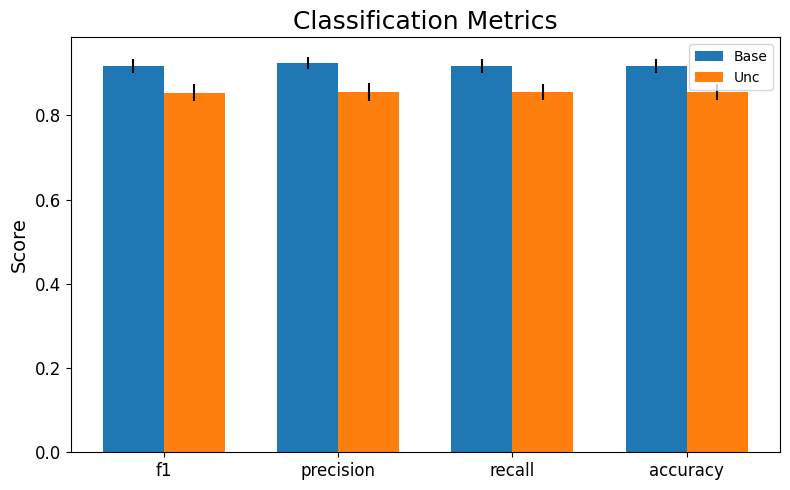

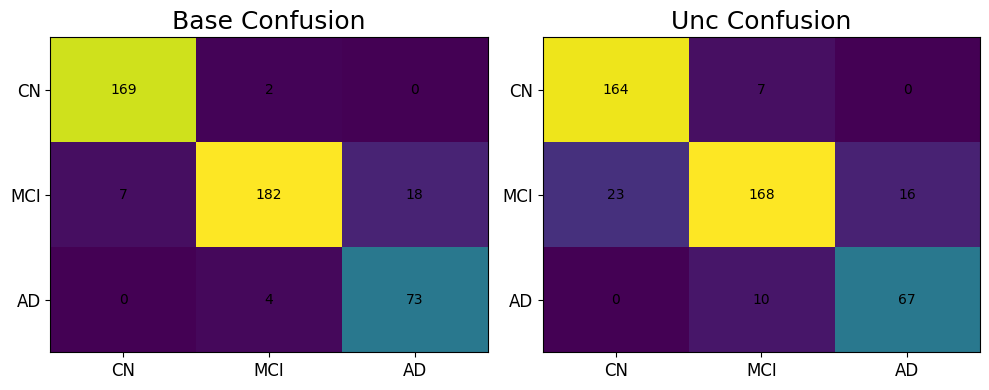


Head 'regression_adas' (Base):
  Valid points: 455
  True span:  8.9615, Pred span:  5.78425
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_adas' (Unc):
  Valid points: 455
  True span:  8.9615, Pred span:  4.79996
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


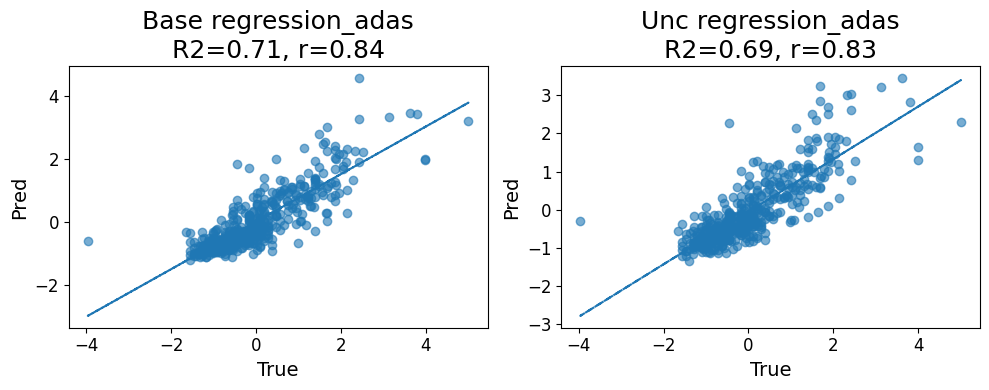


Head 'regression_mmse' (Base):
  Valid points: 455
  True span:  7.91115, Pred span:  6.061
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_mmse' (Unc):
  Valid points: 455
  True span:  7.91115, Pred span:  5.08978
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


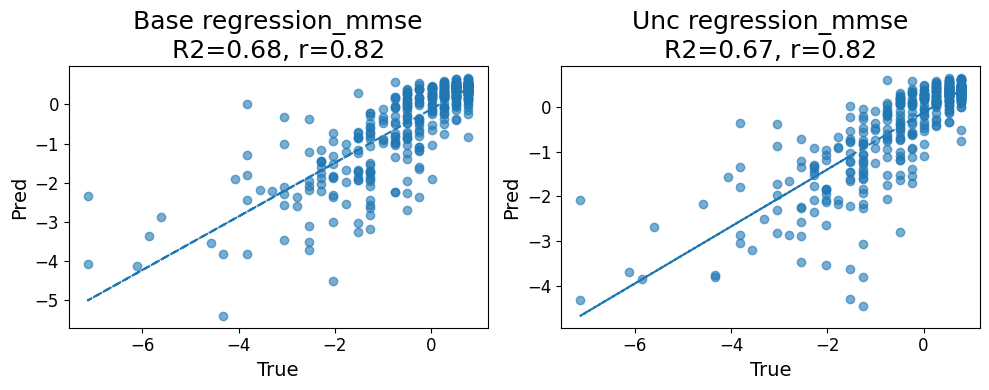


Head 'regression_faq' (Base):
  Valid points: 453
  True span:  4.12012, Pred span:  4.38418
  NaNs in true: 2, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_faq' (Unc):
  Valid points: 453
  True span:  4.12012, Pred span:  4.06747
  NaNs in true: 2, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


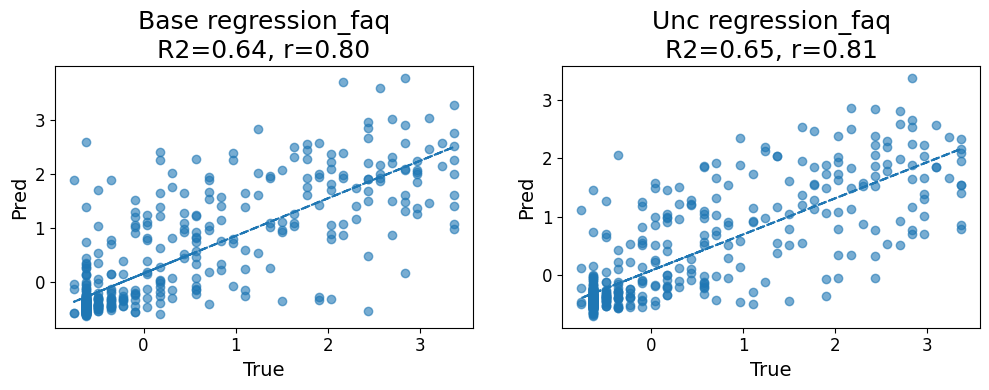


Head 'regression_cdrsb' (Base):
  Valid points: 455
  True span:  5.44419, Pred span:  4.13343
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0

Head 'regression_cdrsb' (Unc):
  Valid points: 455
  True span:  5.44419, Pred span:  4.30741
  NaNs in true: 0, Infs in true: 0
  NaNs in pred: 0, Infs in pred: 0


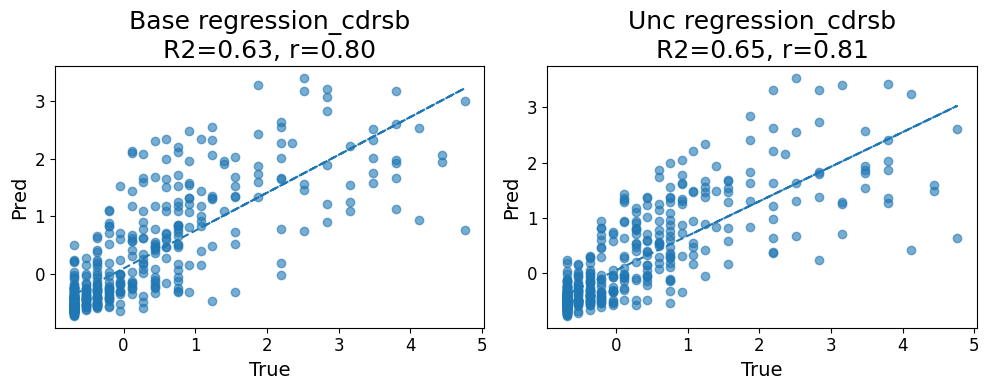

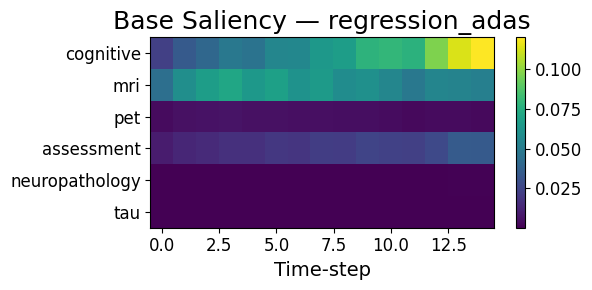

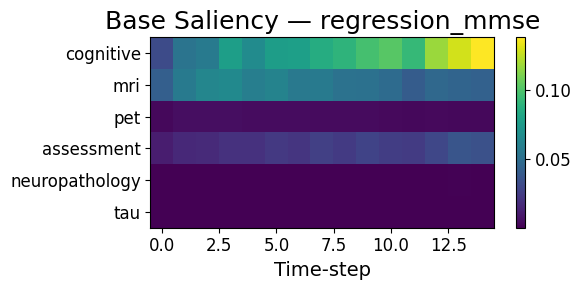

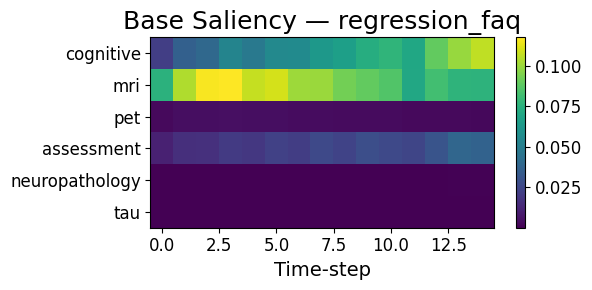

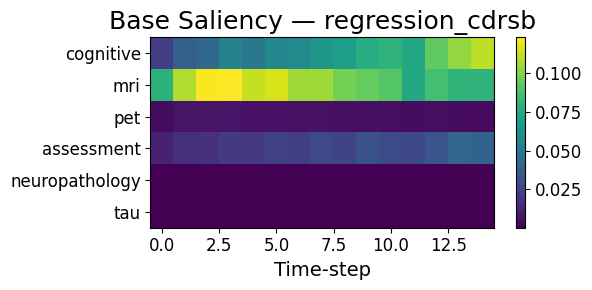

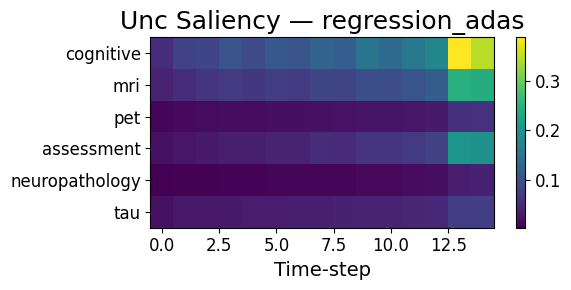

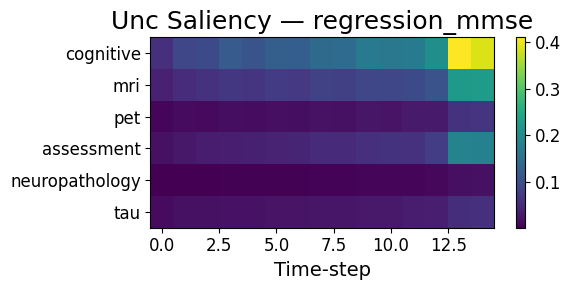

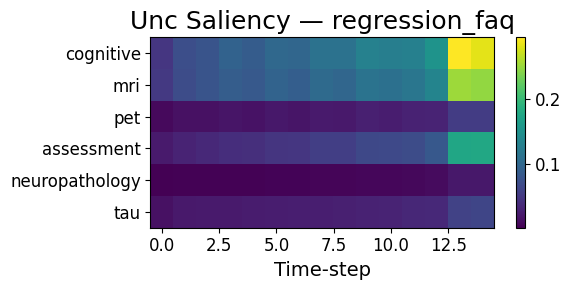

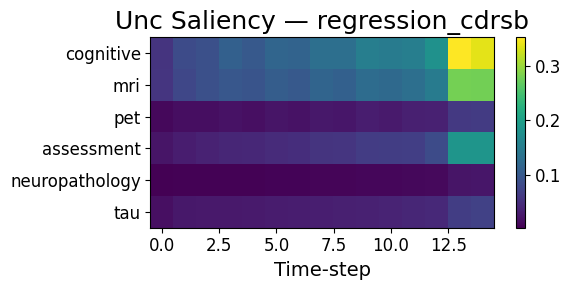

In [28]:
# derive input & background shapes from ds_aligned
input_shapes = {
    k: ds_aligned[k].shape[1:]
    for k in ["cognitive", "mri", "pet", "assessment", "neuropathology", "tau"]
}
bg_shape = (ds_aligned["static"].shape[1],)

os.makedirs("logs", exist_ok=True)
metrics_file = "logs/fold_metrics.csv"
first_seed = all_splits[0]["seed"]

def build_modality_pipeline_tv(input_shape, filters=64, kernel_size=4, lstm_units=64, name_prefix=""):
    """
    Build a time-series feature extractor: Conv1D → MaxPool → Dropout → BiLSTM → TimeDistributed Dense.

    Parameters
    ----------
    input_shape : tuple
        Shape of the input sequence (timesteps, features).
    filters : int, default=64
        Number of convolutional filters.
    kernel_size : int, default=4
        Width of the convolutional kernel.
    lstm_units : int, default=64
        Number of units in the BiLSTM layer.
    name_prefix : str, default=""
        Prefix for layer names.

    Returns
    -------
    tensorflow.keras.Model
        A model that takes a time-series input and outputs transformed sequences.
    """
    inp = Input(shape=input_shape, name=f"{name_prefix}_input")
    x = Conv1D(filters, kernel_size, padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(0.01), name=f"{name_prefix}_conv")(inp)
    x = MaxPooling1D(2,2,padding='same', name=f"{name_prefix}_pool")(x)
    x = Dropout(0.10, name=f"{name_prefix}_drop1")(x)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, activation='tanh',
                           kernel_regularizer=regularizers.l2(0.01), dropout=0.10),
                      name=f"{name_prefix}_bilstm1")(x)
    x = TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
                        name=f"{name_prefix}_td_dense1")(x)
    x = TimeDistributed(Dropout(0.10), name=f"{name_prefix}_td_drop1")(x)
    return Model(inputs=inp, outputs=x, name=f"{name_prefix}_pipeline_tv")

def build_background_network(bg_input_shape):
    """
    Build a fully connected background feature extractor.

    Parameters
    ----------
    bg_input_shape : tuple of int
        Shape of the static background input vector.

    Returns
    -------
    tensorflow.keras.Model
        A Keras Model that maps static inputs to a 64-dimensional
        ReLU-activated embedding with dropout regularization.
    """
    inp = Input(shape=bg_input_shape, name="background_input")
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name="bg_fc1")(inp)
    x = Dropout(0.20, name="bg_drop1")(x)
    return Model(inputs=inp, outputs=x, name="background_pipeline")

def build_shared_fusion_block(x):
    """
    Apply a shared dense layer and dropout for feature fusion.

    Parameters
    ----------
    x : tensor
        Input tensor from concatenated modality and background features.

    Returns
    -------
    tensor
        Output tensor after a 64-unit ReLU dense layer and 20% dropout.
    """
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01),
              name="fusion_shared_fc1")(x)
    return Dropout(0.20, name="fusion_shared_drop1")(x)

def build_multitask_heads(f, num_classes=3): 
    """
    Build classification and regression heads for the multitask network.

    Parameters
    ----------
    f : tensor
        Shared feature tensor from the fusion block.
    num_classes : int, default=3
        Number of classes for the classification head.

    Returns
    -------
    list of tensors
        First element is the classification output (softmax over `num_classes`),
        followed by four regression outputs (linear) for ADAS-13, MMSE, FAQ total, and CDR-SB.
    """
    c = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name="cls_fc1")(f)
    c = Dropout(0.20, name="cls_drop1")(c)
    out_cls = Dense(num_classes, activation='softmax', name="classification")(c)
    regs = []
    for head in ["regression_adas","regression_mmse","regression_faq","regression_cdrsb"]:
        r = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name=f"{head}_fc1")(f)
        r = Dropout(0.20, name=f"{head}_drop1")(r)
        regs.append(Dense(1, activation='linear', name=head)(r))
    return [out_cls] + regs

def build_full_multimodal_model(input_shapes, bg_shape, num_classes=3):
    """
    Construct the full model.

    This model combines time-series pipelines for each modality (cognitive, MRI, PET,
    assessments, neuropathology, tau) with a background feature network. After tiling
    the background embedding across time, all modality sequences are concatenated and
    reduced to the last time step. A shared fusion block then feeds into one
    classification head (softmax over `num_classes`) and four regression heads
    (ADAS-13, MMSE, FAQ, CDR-SB).

    Parameters
    ----------
    input_shapes : dict
        Mapping modality name → tuple (timesteps, features) for each time-series pipeline.
    bg_shape : tuple of int
        Shape of the static background input vector.
    num_classes : int, default=3
        Number of output classes for the classification head.

    Returns
    -------
    tensorflow.keras.Model
        A compiled Keras Model with:
        - Inputs: one tensor per modality sequence + one background tensor
        - Outputs: [classification_softmax, regression_adas, regression_mmse,
                    regression_faq, regression_cdrsb]
    """
    pipes = {k: build_modality_pipeline_tv(input_shapes[k], name_prefix=k) for k in input_shapes}
    bg_m   = build_background_network(bg_shape)
    inputs = [p.input for p in pipes.values()] + [bg_m.input]
    seqs   = [p.output for p in pipes.values()]
    bg_vec = bg_m.output
    T      = Lambda(lambda t: tf.shape(t)[1], name="get_T")(seqs[0])
    bg_seq = Lambda(lambda x: tf.expand_dims(x,1),                name="bg_expand")(bg_vec)
    bg_seq = Lambda(lambda args: tf.tile(args[0],[1,args[1],1]),   name="bg_tile")([bg_seq,T])
    fused_seq = Concatenate(name="fused_features")(seqs + [bg_seq])
    fused_last= Lambda(lambda t: t[:, -1, :], name="fused_last")(fused_seq)
    fused_feat= build_shared_fusion_block(fused_last)
    outputs   = build_multitask_heads(fused_feat, num_classes)
    return Model(inputs=inputs, outputs=outputs, name="Full_Multimodal_Model_Slim")

class MultiTaskUncertaintyModel(tf.keras.Model):
    """
    Multi-task model that wraps a base multimodal network and learns per-task uncertainty.

    This model jointly trains a classification head and four regression heads, automatically
    weighting their losses by learned log-variance parameters (homoscedastic uncertainty).

    Parameters
    ----------
    base_model : tf.keras.Model
        Underlying Keras model with outputs [cls, adas, mmse, faq, cdrsb].
    log_vars : dict
        Mapping task name - tf.Variable for log(sigma^2) of each loss.
    clamp_bounds : dict, optional
        Task-specific (min, max) bounds to clamp log-variance values during training.
    """
    def __init__(self, base_model, log_vars, clamp_bounds=None):
        super().__init__()
        self.base_model    = base_model
        self.log_vars      = log_vars
        self.clamp_bounds  = clamp_bounds or {}
        self.cls_acc       = tf.keras.metrics.SparseCategoricalAccuracy(name="cls_acc")
        self.adas_mae      = tf.keras.metrics.MeanAbsoluteError(name="adas_mae")
        self.mmse_mae      = tf.keras.metrics.MeanAbsoluteError(name="mmse_mae")
        self.faq_mae       = tf.keras.metrics.MeanAbsoluteError(name="faq_mae")
        self.cdrsb_mae     = tf.keras.metrics.MeanAbsoluteError(name="cdrsb_mae")

    @property
    def metrics(self):
        """List of metrics to reset at each epoch."""
        return [self.cls_acc, self.adas_mae, self.mmse_mae, self.faq_mae, self.cdrsb_mae]

    def compile(self, optimizer, run_eagerly=False):
        """
        Configure the model for training.

        Parameters
        ----------
        optimizer : tf.keras.optimizers.Optimizer
            Optimizer to use for gradient updates.
        run_eagerly : bool, default=False
            Whether to run training loops eagerly (this was useful for debugging).
        """
        super().compile(optimizer=optimizer, run_eagerly=run_eagerly)
        self.loss_cls = tf.keras.losses.SparseCategoricalCrossentropy()
        self.loss_mse = tf.keras.losses.MeanSquaredError()

    def call(self, inputs, training=False):
        """
        Forward pass through the base model.

        Parameters
        ----------
        inputs : list or dict
            Input tensors matching base_model inputs.
        training : bool
            Whether to run in training mode.

        Returns
        -------
        list of tf.Tensor
            Model outputs: [classification_logits, adas_pred, mmse_pred, faq_pred, cdrsb_pred].
        """
        return self.base_model(inputs, training=training)

    def train_step(self, data):
        """
        Training step that applies uncertainty-weighted multi-task loss.

        Parameters
        ----------
        data : tuple
            (inputs, targets), where targets is a list matching model outputs.

        Returns
        -------
        dict
            Updated metric results.
        """
        x, y = data[:2]
        with tf.GradientTape() as tape:
            preds = self.base_model(x, training=True)
            losses = {
                'classification':   self.loss_cls(y[0], preds[0]),
                'regression_adas':  self.loss_mse(y[1], preds[1]),
                'regression_mmse':  self.loss_mse(y[2], preds[2]),
                'regression_faq':   self.loss_mse(y[3], preds[3]),
                'regression_cdrsb': self.loss_mse(y[4], preds[4]),
            }
            total_loss = 0.0
            for name, L in losses.items():
                # s = log(sigma^2)
                s = self.log_vars[name]
                # optional clamping of s
                if name in self.clamp_bounds:
                    lo, hi = self.clamp_bounds[name]
                    s = tf.clip_by_value(s, lo, hi)
                precision = tf.exp(-s)  # = 1 / sigma^2

                if name == 'classification':
                    # classification: (1/sigma^2) * CE + log(sigma)
                    total_loss += precision * L + 0.5 * s
                else:
                    # regression: (1/(2 sigma^2)) * MSE + log(sigma)
                    total_loss += 0.5 * precision * L + 0.5 * s

        # update weights
        vars_to_train = self.base_model.trainable_variables + list(self.log_vars.values())
        grads = tape.gradient(total_loss, vars_to_train)
        self.optimizer.apply_gradients(zip(grads, vars_to_train))

        # update metrics
        for m, pred, true in zip(self.metrics, preds, y):
            m.update_state(true, pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        Evaluation step.

        Parameters
        ----------
        data : tuple
            (inputs, targets)
        
        Returns
        -------
        dict
            Metric results on the provided data.
        """
        x, y = data[:2]
        preds = self.base_model(x, training=False)
        for m, pred, true in zip(self.metrics, preds, y):
            m.update_state(true, pred)
        return {m.name: m.result() for m in self.metrics}

def make_split(rids, ds_aligned, diag_df, scaler_reg):
    """
    Prepare inputs and targets for classification and regression from xarray.

    Parameters
    ----------
    rids : list of str
        Subject IDs for this split.
    ds_aligned : xarray.Dataset
        Dataset containing data variables 'cognitive', 'mri', 'pet', 'assessment',
        'neuropathology', 'tau', 'regression', 'static' aligned on ('subject','visit').
    diag_df : pandas.DataFrame
        DataFrame with index 'RID' and column 'DIAGNOSIS_ENC'.
    scaler_reg : sklearn.preprocessing.StandardScaler
        Fitted scaler for regression targets.

    Returns
    -------
    Xs : list of np.ndarray
        List of input arrays for each modality and static data.
    y : dict of np.ndarray
        Mapping task name → target array.
    R : np.ndarray
        Raw regression tensor (n_subjects, n_visits, 4) before scaling.
    """
    ds = ds_aligned.sel(subject=rids)
    R  = ds["regression"].values # (n, T, 4)
    flat = R.reshape(-1, R.shape[-1])
    flat_s = scaler_reg.transform(flat)
    R_s = flat_s.reshape(R.shape)
    y = {
        "classification":   diag_df.set_index("RID").loc[rids]["DIAGNOSIS_ENC"].values,
        "regression_adas":  R_s[:, -1, 0][:, None],
        "regression_mmse":  R_s[:, -1, 1][:, None],
        "regression_faq":   R_s[:, -1, 2][:, None],
        "regression_cdrsb": R_s[:, -1, 3][:, None],
    }
    Xs = [np.nan_to_num(ds[v].values, nan=0., posinf=0., neginf=0.)
          for v in ["cognitive","mri","pet","assessment","neuropathology", "tau","static"]]
    for k in y:
        y[k] = np.nan_to_num(y[k], nan=0., posinf=0., neginf=0.)
    return Xs, y, R

def compute_saliency_ts(model, Xs, mod_idx, out_idx):
    """
    Compute average saliency (gradient magnitude) over time for one modality and output head.

    Parameters
    ----------
    model : tf.keras.Model
        Trained multi-task model.
    Xs : list of np.ndarray
        List of input arrays matching model inputs.
    mod_idx : int
        Index of the modality in Xs to compute saliency for.
    out_idx : int
        Index of the output head (0=classification, 1=ADAS, etc.) to sum gradients of.

    Returns
    -------
    np.ndarray
        1D array of length T representing mean absolute gradient per time step.
    """
    inputs = [tf.constant(x, dtype=tf.float32) for x in Xs]
    with tf.GradientTape() as tape:
        tape.watch(inputs[mod_idx])
        out  = model(inputs, training=False)[out_idx]
        loss = tf.reduce_sum(out)
    grads = tape.gradient(loss, inputs[mod_idx])
    sal   = tf.reduce_sum(tf.abs(grads), axis=-1).numpy()
    return sal.mean(axis=0)

# — train across splits, collect metrics & save fold‐0 data for plotting —
results   = []
out_order = [
    'classification',
    'regression_adas','regression_mmse',
    'regression_faq','regression_cdrsb'
]
plot_seed = first_seed

for split in all_splits:
    seed       = split["seed"]
    scaler_reg = split["regression_scaler"]

    # prepare data
    X_tr, y_tr, _   = make_split(split["train_ids"], ds_aligned, subject_diag_common, scaler_reg)
    X_val, y_val, _ = make_split(split["val_ids"],   ds_aligned, subject_diag_common, scaler_reg)
    X_te,  y_te, R_te=make_split(split["test_ids"],  ds_aligned, subject_diag_common, scaler_reg)

     # save the raw test data and scaler for your chosen plotting fold
    if seed == plot_seed:
        X_te_plot, y_te_plot, R_te_plot, scaler_plot = X_te, y_te, R_te, scaler_reg

    # class weights
    y_cls   = y_tr["classification"].flatten()
    classes = np.unique(y_cls)
    cw      = compute_class_weight('balanced', classes=classes, y=y_cls)
    sw_cls  = np.vectorize(dict(zip(classes, cw)).get)(y_cls)
    sw_tr_list = [sw_cls] + [np.ones_like(sw_cls)]*4

    # callbacks
    epoch_logger = LambdaCallback(on_epoch_begin=lambda ep, logs: print(f"[Fold {seed}] Epoch {ep+1}"))
    es           = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    cb_base      = [es, epoch_logger, CSVLogger(f"logs/base_split_{seed}.csv")]
    cb_unc       = [es, epoch_logger, CSVLogger(f"logs/unc_split_{seed}.csv")]

    y_tr_list  = [y_tr[n] for n in out_order]
    y_val_list = [y_val[n] for n in out_order]

    # Base model (100 epochs, verbose=1)
    base = build_full_multimodal_model(input_shapes, bg_shape, num_classes=len(classes))
    base.compile(
        optimizer=Adam(1e-4, clipnorm=1.0),
        loss=['sparse_categorical_crossentropy'] + ['mse']*4
    )
    base.fit(
        X_tr, y_tr_list,
        sample_weight=sw_tr_list,
        validation_data=(X_val, y_val_list),
        epochs=100,
        batch_size=32,
        callbacks=cb_base,
        verbose=1
    )
    preds_b = base.predict(X_te, verbose=0)
    
    if seed == plot_seed:
        preds_b_plot = preds_b
        base_plot    = base

    # classification metrics (base)
    y_pred_cls_b = np.argmax(preds_b[0], axis=1)
    cls_metrics_b = {
        "f1":        f1_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "recall":    recall_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "precision": precision_score(y_te["classification"], y_pred_cls_b, average="weighted"),
        "accuracy":  accuracy_score(y_te["classification"], y_pred_cls_b)
    }

    # regression metrics (base)
    reg_metrics_b = {}
    for i, name in enumerate(out_order[1:], start=0): # i=0..3
        yt = R_te[:, -1, i]
        pred_orig = scaler_reg.inverse_transform(
            np.concatenate([preds_b[j] for j in range(1,5)], axis=-1)
        )[:, i]

        if seed == plot_seed:
            print(f"[DEBUG fold {seed} head {name}] "
                  f"yt nonfinite={(~np.isfinite(yt)).sum()}, "
                  f"pred nonfinite={(~np.isfinite(pred_orig)).sum()}")

        mask = np.isfinite(yt) & np.isfinite(pred_orig)
        if mask.sum() < 2:
            vals = {"r2": np.nan, "pearson": np.nan, "mae": np.nan, "rmse": np.nan}
        else:
            yt_f, p_f = yt[mask], pred_orig[mask]
            vals = {
                "r2":      r2_score(yt_f, p_f),
                "pearson": pearsonr(yt_f, p_f)[0],
                "mae":     mean_absolute_error(yt_f, p_f),
                "rmse":    np.sqrt(mean_squared_error(yt_f, p_f))
            }
        reg_metrics_b[name] = vals

    # Uncertainty model (100 epochs, verbose=1)
    log_vars = {n: tf.Variable(0., trainable=True, name=f"logvar_{n}_{seed}") for n in out_order}
    unc = MultiTaskUncertaintyModel(
        build_full_multimodal_model(input_shapes, bg_shape, num_classes=len(classes)),
        log_vars
    )
    unc.compile(optimizer=Adam(1e-4, clipnorm=1.0), run_eagerly=True)
    unc.fit(
        X_tr, y_tr_list,
        sample_weight=sw_tr_list,
        validation_data=(X_val, y_val_list),
        epochs=100,
        batch_size=32,
        callbacks=cb_unc,
        verbose=1
    )
    preds_u = unc.predict(X_te, verbose=0)
    
    if seed == plot_seed:
        preds_u_plot = preds_u
        unc_plot     = unc
    # classification metrics (unc)
    y_pred_cls_u = np.argmax(preds_u[0], axis=1)
    cls_metrics_u = {
        "f1":        f1_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "recall":    recall_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "precision": precision_score(y_te["classification"], y_pred_cls_u, average="weighted"),
        "accuracy":  accuracy_score(y_te["classification"], y_pred_cls_u)
    }

    # regression metrics (unc)
    reg_metrics_u = {}
    for i, name in enumerate(out_order[1:], start=0): # i=0..3
        yt = R_te[:, -1, i]
        pred_orig = scaler_reg.inverse_transform(
            np.concatenate([preds_u[j] for j in range(1,5)], axis=-1)
        )[:, i]

        if seed == plot_seed:
            print(f"[DEBUG fold {seed} UNC head {name}] "
                  f"yt nonfinite={(~np.isfinite(yt)).sum()}, "
                  f"pred nonfinite={(~np.isfinite(pred_orig)).sum()}")

        mask = np.isfinite(yt) & np.isfinite(pred_orig)
        if mask.sum() < 2:
            vals = {"r2": np.nan, "pearson": np.nan, "mae": np.nan, "rmse": np.nan}
        else:
            yt_f, p_f = yt[mask], pred_orig[mask]
            vals = {
                "r2":      r2_score(yt_f, p_f),
                "pearson": pearsonr(yt_f, p_f)[0],
                "mae":     mean_absolute_error(yt_f, p_f),
                "rmse":    np.sqrt(mean_squared_error(yt_f, p_f))
            }
        reg_metrics_u[name] = vals

    # collect & log all metrics
    row = {"split": seed}
    row.update({f"base_cls_{k}": v for k,v in cls_metrics_b.items()})
    row.update({f"unc_cls_{k}":  v for k,v in cls_metrics_u.items()})
    for nm in out_order[1:]:
        for metric,val in reg_metrics_b[nm].items(): row[f"base_{nm}_{metric}"] = val
        for metric,val in reg_metrics_u[nm].items(): row[f"unc_{nm}_{metric}"]  = val

    results.append(row)
    mode = 'w' if seed == first_seed else 'a'
    with open(metrics_file, mode, newline='') as f:
        writer = csv.DictWriter(f, fieldnames=list(row.keys()))
        if mode == 'w':
            writer.writeheader()
        writer.writerow(row)

# summary across splits & plotting
df = pd.DataFrame(results).set_index("split")
summary = df.describe().loc[['mean','std']]
print("Aggregate metrics (mean, std):\n", summary)

# plot classification comparison
cls_mets = ['f1','precision','recall','accuracy']
x = np.arange(len(cls_mets))
width = 0.35
base_means = [summary.loc['mean', f"base_cls_{m}"] for m in cls_mets]
base_stds  = [summary.loc['std',  f"base_cls_{m}"] for m in cls_mets]
unc_means  = [summary.loc['mean', f"unc_cls_{m}"]  for m in cls_mets]
unc_stds   = [summary.loc['std',  f"unc_cls_{m}"]  for m in cls_mets]
plt.figure(figsize=(8,5))
plt.bar(x - width/2, base_means,  width, yerr=base_stds,  label="Base")
plt.bar(x + width/2, unc_means,   width, yerr=unc_stds,   label="Unc")
plt.xticks(x, cls_mets)
plt.ylabel("Score")
plt.title("Classification Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# confusion matrices for fold 0
y_true = y_te_plot["classification"]
y_pred_b0 = np.argmax(preds_b_plot[0], axis=1)
y_pred_u0 = np.argmax(preds_u_plot[0], axis=1)
cm_b0 = confusion_matrix(y_true, y_pred_b0)
cm_u0 = confusion_matrix(y_true, y_pred_u0)
fig, axes = plt.subplots(1,2,figsize=(10,4))
for ax, cm, title in zip(axes, [cm_b0, cm_u0], ["Base","Unc"]):
    ax.imshow(cm, interpolation='nearest', aspect='auto')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha='center', va='center')
    ax.set_xticks([0,1,2]); ax.set_xticklabels(["CN","MCI","AD"])
    ax.set_yticks([0,1,2]); ax.set_yticklabels(["CN","MCI","AD"])
    ax.set_title(f"{title} Confusion")
fig.tight_layout()
plt.show()

# regression true vs. pred for fold 0
reg_heads = out_order[1:]
true_vals = R_te_plot[:, -1, :]
preds_b_scaled = np.concatenate(preds_b_plot[1:], axis=-1)
preds_u_scaled = np.concatenate(preds_u_plot[1:], axis=-1)
preds_b_orig = scaler_plot.inverse_transform(preds_b_scaled)
preds_u_orig = scaler_plot.inverse_transform(preds_u_scaled)

for i, head in enumerate(reg_heads):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, pred, title in zip(
        axes,
        [preds_b_orig[:, i], preds_u_orig[:, i]],
        ["Base", "Unc"]
    ):
        x = true_vals[:, i]
        y = pred

        # 1) Mask out any NaNs/Infs
        mask = np.isfinite(x) & np.isfinite(y)
        xv, yv = x[mask], y[mask]

        # 2) Print diagnostics
        print(f"\nHead {head!r} ({title}):")
        print(f"  Valid points: {len(xv)}")
        print(f"  True span:  {np.ptp(xv):.6g}, Pred span:  {np.ptp(yv):.6g}")
        print(f"  NaNs in true: {np.isnan(x).sum()}, Infs in true: {np.isinf(x).sum()}")
        print(f"  NaNs in pred: {np.isnan(y).sum()}, Infs in pred: {np.isinf(y).sum()}")

        # 3) Scatter all valid points
        ax.scatter(xv, yv, alpha=0.6)

        # 4) Only fit a line if we have ≥2 points and nonzero span
        if len(xv) < 2 or np.ptp(xv) < 1e-8 or np.ptp(yv) < 1e-8:
            print("  → Skipping line fit (too few points or zero variance)")
            m, b = np.nan, np.nan
        else:
            try:
                m, b = np.polyfit(xv, yv, 1)
            except np.linalg.LinAlgError:
                print("  → SVD did not converge; skipping line fit")
                m, b = np.nan, np.nan

        # 5) Plot the line if it’s valid
        if np.isfinite(m) and np.isfinite(b):
            ax.plot(xv, m * xv + b, "--")

        # 6) Compute and display R squared and Pearson r on the title
        if len(xv) >= 2:
            r2 = r2_score(xv, yv)
            r = pearsonr(xv, yv)[0]
        else:
            r2, r = np.nan, np.nan

        ax.set_xlabel("True")
        ax.set_ylabel("Pred")
        ax.set_title(f"{title} {head}\nR2={r2:.2f}, r={r:.2f}")

    fig.tight_layout()
    plt.show()


# saliency heatmaps for regression heads, fold 0
modalities = list(input_shapes.keys())
for model, title in [(base_plot,"Base"), (unc_plot,"Unc")]:
    for idx, head in enumerate(reg_heads, start=1):
        sal_map = np.stack([
            compute_saliency_ts(model, X_te_plot, mi, idx)
            for mi in range(len(modalities))
        ])
        plt.figure(figsize=(6,3))
        plt.imshow(sal_map, aspect='auto')
        plt.yticks(range(len(modalities)), modalities)
        plt.xlabel("Time-step"); plt.title(f"{title} Saliency — {head}")
        plt.colorbar(); plt.tight_layout(); plt.show()

## <center> Step 24: Summarize Regression Metrics Across Folds
We load the per‐fold performance metrics from logs/fold_metrics.csv and focus on our four regression heads (ADAS-13, MMSE, FAQ total, and CDRSB) and the key statistics R squared, Pearson’s r, RMSE, and MAE. We then build a pandas MultiIndex over (head, stat) and, for each head–stat pair, compute the mean and standard deviation across all splits for both the base model and the uncertainty‐weighted model. These values are assembled into a summary DataFrame with columns base_mean, base_std, unc_mean, and unc_std. Finally, we print out, for each regression head, lines of the form

In [29]:
# 1) Load the metrics CSV 
df = pd.read_csv("logs/fold_metrics.csv", index_col="split")

# 2) Define the heads and stats of interest
reg_heads = ["regression_adas", "regression_mmse", "regression_faq", "regression_cdrsb"]
stats     = ["r2", "pearson", "rmse", "mae"]

# 3) Build a MultiIndex to organize the summary
idx = pd.MultiIndex.from_product([reg_heads, stats], names=("head", "stat"))

# 4) Collect mean/std for both Base and Unc
data = []
for head in reg_heads:
    for stat in stats:
        base_col = f"base_{head}_{stat}"
        unc_col  = f"unc_{head}_{stat}"
        data.append([
            df[base_col].mean(),
            df[base_col].std(),
            df[unc_col].mean(),
            df[unc_col].std()
        ])

# 5) Create a summary DataFrame
summary_df = pd.DataFrame(
    data,
    index=idx,
    columns=["base_mean", "base_std", "unc_mean", "unc_std"]
)

# 6) Display
print("\nRegression metrics summary (mean ± std):\n")
for head in reg_heads:
    sub = summary_df.loc[head]
    print(f"{head}:")
    print(sub.apply(lambda row: f"  {row.name}: Base = {row['base_mean']:.3f}±{row['base_std']:.3f}, "
                               f"Unc = {row['unc_mean']:.3f}±{row['unc_std']:.3f}", axis=1))
    print()

# see it as a clean table:
print("Full summary table:\n", summary_df)


Regression metrics summary (mean ± std):

regression_adas:
stat
r2                r2: Base = 0.633±0.053, Unc = 0.628±0.052
pearson      pearson: Base = 0.797±0.033, Unc = 0.793±0.032
rmse            rmse: Base = 0.699±0.075, Unc = 0.704±0.072
mae              mae: Base = 0.451±0.027, Unc = 0.460±0.027
dtype: object

regression_mmse:
stat
r2                r2: Base = 0.665±0.047, Unc = 0.658±0.042
pearson      pearson: Base = 0.820±0.027, Unc = 0.817±0.023
rmse            rmse: Base = 0.789±0.096, Unc = 0.797±0.084
mae              mae: Base = 0.500±0.038, Unc = 0.512±0.035
dtype: object

regression_faq:
stat
r2                r2: Base = 0.636±0.024, Unc = 0.634±0.024
pearson      pearson: Base = 0.801±0.015, Unc = 0.800±0.014
rmse            rmse: Base = 0.742±0.029, Unc = 0.745±0.031
mae              mae: Base = 0.488±0.024, Unc = 0.508±0.022
dtype: object

regression_cdrsb:
stat
r2                r2: Base = 0.592±0.036, Unc = 0.598±0.037
pearson      pearson: Base = 0.774±0.024, Un

## <center> Loading fold-wise metrics
This utility locates the fold_metrics.csv anywhere under the project tree (e.g., logs/fold_metrics.csv or timestamped subfolders), loads it, and sanity-checks that both Base and Unc result columns are present. Paired stats (paired t, Cohen’s d for paired designs, 95% CI of mean differences) require per-fold values for both models. This helper finds and loads that CSV reliably so downstream analysis can proceed. This step was added post hoc as a convenient way to utilise the saved log for computing additional statistics.

In [30]:
def find_fold_metrics(start=".", filename="fold_metrics.csv"):
    start = Path(start).resolve()
    print("CWD:", os.getcwd())

    # 1) obvious spots
    candidates = []
    for p in [start/filename, start/"logs"/filename]:
        if p.exists():
            candidates.append(p)

    # 2) recursive search (common patterns)
    patterns = [f"**/{filename}", "**/*fold*metrics*.csv", "**/logs/*metrics*.csv"]
    for pat in patterns:
        candidates.extend(start.glob(pat))

    # de-dup + newest first
    candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates

cands = find_fold_metrics(".")
print("Found", len(cands), "candidate(s):")
for i, p in enumerate(cands[:10], 1):
    print(f"{i}. {p}")

if not cands:
    raise FileNotFoundError("Couldn't find any fold_metrics*.csv under this project. "
                            "Check where your training script saved it (look for a timestamped logs/ subdir).")

csv_path = cands[0] # pick the most recent
print("Using:", csv_path)
df = pd.read_csv(csv_path)

# sanity-check expected columns exist
expected_prefixes = ["base_", "unc_"]
missing = [c for pref in expected_prefixes for c in [col for col in df.columns if col.startswith(pref)]]
if not any(col.startswith("base_") for col in df.columns) or not any(col.startswith("unc_") for col in df.columns):
    raise ValueError("Loaded CSV but didn't see base_/unc_ columns. Open the file and confirm its schema.")

CWD: c:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models
Found 2 candidate(s):
1. C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics.csv
2. C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics_orig.csv
Using: C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics.csv


## <center> Paired t-tests, Cohen’s d (paired), and 95% CIs from fold_metrics.csv
This block loads the per-fold metrics for Base vs Uncertainty-weighted (Unc) models, computes paired differences (unc − base) for each metric, runs paired t-tests, and adds: Cohen’s d for paired designs, 95% confidence interval for the mean difference. Results are saved to paired_stats_with_d_and_ci.csv.

In [31]:
# Load
csv_path = r"C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics.csv"
df = pd.read_csv(csv_path)

# Metrics to compare (unc - base)
metrics = [
    "cls_f1", "cls_recall", "cls_precision", "cls_accuracy",
    "regression_adas_r2", "regression_adas_pearson", "regression_adas_mae", "regression_adas_rmse",
    "regression_mmse_r2", "regression_mmse_pearson", "regression_mmse_mae", "regression_mmse_rmse",
    "regression_faq_r2", "regression_faq_pearson", "regression_faq_mae", "regression_faq_rmse",
    "regression_cdrsb_r2", "regression_cdrsb_pearson", "regression_cdrsb_mae", "regression_cdrsb_rmse"
]

rows = []
for m in metrics:
    base_col = f"base_{m}"
    unc_col  = f"unc_{m}"
    if base_col not in df.columns or unc_col not in df.columns:
        continue

    # paired differences: unc - base
    d = df[unc_col].to_numpy() - df[base_col].to_numpy()
    n = d.size

    mean_base = float(np.nanmean(df[base_col]))
    mean_unc  = float(np.nanmean(df[unc_col]))
    mdiff     = float(np.nanmean(d))

    # SD of differences with ddof=1; guard n<2
    sd = float(np.nanstd(d, ddof=1)) if n >= 2 else np.nan
    se = sd / np.sqrt(n) if (n >= 2 and np.isfinite(sd)) else np.nan

    # paired t-test (will yield nan if n<2 or zero variance)
    t_stat, p_val = ttest_rel(df[unc_col], df[base_col], nan_policy="omit")
    dfree = int(n - 1) if n >= 1 else 0

    # Cohen's d for paired design (d_z): uses SD of differences
    d_z = mdiff / sd if (sd is not np.nan and np.isfinite(sd) and sd > 0) else np.nan

    # 95% CI for the mean difference using Student-t critical value
    if dfree > 0 and np.isfinite(se):
        tcrit = float(student_t.ppf(0.975, dfree))
        ci_low  = mdiff - tcrit * se
        ci_high = mdiff + tcrit * se
    else:
        ci_low = np.nan
        ci_high = np.nan

    rows.append({
        "metric": m,
        "baseline_mean": mean_base,
        "uncertainty_mean": mean_unc,
        "mean_diff_unc_minus_base": mdiff,
        "t_stat": float(t_stat) if np.isfinite(t_stat) else np.nan,
        "df": dfree,
        "p_value": float(p_val) if np.isfinite(p_val) else np.nan,
        "cohens_dz": d_z,
        "ci95_low_mean_diff": ci_low,
        "ci95_high_mean_diff": ci_high
    })

out = pd.DataFrame(rows).sort_values("p_value", na_position="last")
out_path = csv_path.replace("fold_metrics.csv", "paired_stats_with_d_and_ci.csv")
out.to_csv(out_path, index=False)
print("Saved:", out_path)
out.head(10)

Saved: C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\paired_stats_with_d_and_ci.csv


,metric,baseline_mean,uncertainty_mean,mean_diff_unc_minus_base,t_stat,df,p_value,cohens_dz,ci95_low_mean_diff,ci95_high_mean_diff
2,cls_precision,0.923858,0.855272,-0.068586,-9.489807,9,0.000006,-3.000940,-0.084935,-0.052236
0,cls_f1,0.918216,0.854307,-0.063910,-8.423010,9,0.000015,-2.663590,-0.081074,-0.046745
1,cls_recall,0.917802,0.855385,-0.062418,-8.369045,9,0.000015,-2.646524,-0.079289,-0.045546
3,cls_accuracy,0.917802,0.855385,-0.062418,-8.369045,9,0.000015,-2.646524,-0.079289,-0.045546
14,regression_faq_mae,0.487702,0.508364,0.020662,3.003979,9,0.014860,0.949941,0.005102,0.036221
10,regression_mmse_mae,0.499536,0.512008,0.012471,2.830564,9,0.019704,0.895103,0.002504,0.022438
6,regression_adas_mae,0.451125,0.460404,0.009280,2.668103,9,0.025702,0.843728,0.001412,0.017147
18,regression_cdrsb_mae,0.463767,0.475702,0.011934,2.396115,9,0.040153,0.757718,0.000667,0.023201
8,regression_mmse_r2,0.665213,0.658305,-0.006908,-1.173958,9,0.270540,-0.371238,-0.020220,0.006403
11,regression_mmse_rmse,0.789184,0.796881,0.007697,1.121764,9,0.290999,0.354733,-0.007825,0.023218


## <center> Paired cross-fold test for tau augmentation hypothesis (uses logs from the two notebooks)
This block loads the two per-fold results files (without-tau vs with-tau), aligns them by the same fold, computes the per-fold difference delta = with-tau − without-tau for each head/metric (R squared, r, MAE, RMSE) and model (Base/Unc), runs a paired t-test with a 95% CI and Cohen’s d (paired) on those differences (plus a Wilcoxon p as a robustness check), saves all results to logs/tau_effect_paired_tests.csv, and prints a quick summary for MAE/RMSE (where negative delta = improvement).

In [32]:
# Paths
no_tau_csv   = r"C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics_orig.csv"
with_tau_csv = r"C:\Users\Asus\Desktop\Thesis_Materials\MSC C2N THESIS\THE_models\logs\fold_metrics.csv"

# Load & align on 'split'
a = pd.read_csv(no_tau_csv).set_index("split").sort_index()   # no tau
b = pd.read_csv(with_tau_csv).set_index("split").sort_index() # with tau

common = a.index.intersection(b.index)
if len(common) == 0:
    raise ValueError("No overlapping folds (split keys). Check your files.")
if len(a.index.difference(b.index)) or len(b.index.difference(a.index)):
    print("Warning: some folds are missing in one file; using intersection only.")
a = a.loc[common]; b = b.loc[common]

# Coerce metric cols to numeric (just in case)
for df_ in (a, b):
    for col in df_.columns:
        if col.startswith(("base_", "unc_")):
            df_[col] = pd.to_numeric(df_[col], errors="coerce")

# What to test
stats_map = {
    "cls": ["accuracy"], 
    "regression_adas": ["r2","pearson","mae","rmse"],
    "regression_mmse": ["r2","pearson","mae","rmse"],
    "regression_faq":  ["r2","pearson","mae","rmse"],
    "regression_cdrsb":["r2","pearson","mae","rmse"],
}
models = ["base","unc"] # compare both models
alpha = 0.05

def paired_summary(x_with, x_without, alpha=0.05):
    """Return paired t-test summary + group means/SDs and Wilcoxon p."""
    x_with    = np.asarray(x_with, float)
    x_without = np.asarray(x_without, float)
    msk = np.isfinite(x_with) & np.isfinite(x_without)
    xw, xo = x_with[msk], x_without[msk]
    d = xw - xo
    n = d.size

    # Precompute group descriptives
    with_mean = float(np.nanmean(xw)) if n else np.nan
    with_sd   = float(np.nanstd(xw, ddof=1)) if n > 1 else np.nan
    no_mean   = float(np.nanmean(xo)) if n else np.nan
    no_sd     = float(np.nanstd(xo, ddof=1)) if n > 1 else np.nan

    if n < 2 or np.allclose(d.std(ddof=1), 0, equal_nan=False):
        return dict(
            n=n, mean_diff=np.nan, t=np.nan, df=np.nan, p=np.nan,
            ci_low=np.nan, ci_high=np.nan, dz=np.nan, wilcoxon_p=np.nan,
            with_tau_mean=with_mean, with_tau_sd=with_sd,
            no_tau_mean=no_mean,   no_tau_sd=no_sd
        )

    md  = d.mean()
    sd  = d.std(ddof=1)
    se  = sd / np.sqrt(n)
    df_ = n - 1

    tval, pval = ttest_rel(xw, xo, nan_policy="omit")
    tcrit = student_t.ppf(1 - alpha/2, df_)
    ci = (md - tcrit*se, md + tcrit*se)
    dz = md / sd
    try:
        _, wp = wilcoxon(d, zero_method="wilcox", correction=False)
    except ValueError:
        wp = np.nan

    return dict(
        n=n, mean_diff=float(md), t=float(tval), df=int(df_), p=float(pval),
        ci_low=float(ci[0]), ci_high=float(ci[1]), dz=float(dz),
        wilcoxon_p=(float(wp) if np.isfinite(wp) else np.nan),
        with_tau_mean=with_mean, with_tau_sd=with_sd,
        no_tau_mean=no_mean,     no_tau_sd=no_sd
    )

# Run paired tests
rows = []
for mdl in models:
    for head, stats in stats_map.items():
        for s in stats:
            col = f"{mdl}_{head}_{s}"
            if col not in a.columns or col not in b.columns:
                continue
            res = paired_summary(b[col].values, a[col].values, alpha=alpha)  # withTau − noTau
            rows.append({"model": mdl, "head": head, "metric": s, **res})

out = pd.DataFrame(rows).sort_values(["model","head","metric"]).reset_index(drop=True)

# Save
os.makedirs("logs", exist_ok=True)
out_path = r"logs\tau_effect_paired_tests.csv"
out.to_csv(out_path, index=False)
print("Saved:", out_path)

# Quick readable summaries
# Classification accuracy
for mdl in models:
    r = out[(out.model==mdl) & (out.head=="cls") & (out.metric=="accuracy")]
    if len(r):
        r = r.iloc[0]
        print(f"{mdl.upper()} CLASSIFICATION ACCURACY: "
              f"with={r.with_tau_mean:.3f}±{(r.with_tau_sd if np.isfinite(r.with_tau_sd) else float('nan')):.3f}, "
              f"no={r.no_tau_mean:.3f}±{(r.no_tau_sd if np.isfinite(r.no_tau_sd) else float('nan')):.3f}; "
              f"delta={r.mean_diff:+.3f} [{r.ci_low:.3f},{r.ci_high:.3f}], "
              f"t({int(r.df)})={r.t:.2f}, p={r.p:.3f}, d_z={r.dz:.2f}")

# Regression MAE/RMSE
for mdl in models:
    for h in ["regression_adas","regression_mmse","regression_faq","regression_cdrsb"]:
        for s in ["mae","rmse"]:
            r = out[(out.model==mdl) & (out.head==h) & (out.metric==s)]
            if len(r)==0: 
                continue
            r = r.iloc[0]
            print(f"{mdl.upper()} {h.upper()} {s.upper()}: "
                  f"with={r.with_tau_mean:.3f}±{(r.with_tau_sd if np.isfinite(r.with_tau_sd) else float('nan')):.3f}, "
                  f"no={r.no_tau_mean:.3f}±{(r.no_tau_sd if np.isfinite(r.no_tau_sd) else float('nan')):.3f}; "
                  f"delta={r.mean_diff:+.3f} [{r.ci_low:.3f},{r.ci_high:.3f}], "
                  f"t({int(r.df)})={r.t:.2f}, p={r.p:.3f}, d_z={r.dz:.2f}")

Saved: logs\tau_effect_paired_tests.csv


## <center> Step 25: Paired t-Tests for Comparing Base vs. Uncertainty Model Performance
In this step, we perform paired t‐tests across our cross‐validation splits to assess whether the uncertainty‐weighted model’s improvements over the base model are statistically significant for each metric. We start by reading the fold_metrics.csv file into a DataFrame and define the full list of metrics we want to compare (classification F1, recall, precision, accuracy, and for each regression head the R squared, Pearson’s r, MAE, and RMSE). For each metric, we pull out its “base_…” and “unc_…” columns, compute a paired t‐statistic and p‐value using ttest_rel (comparing uncertainty minus base), and also record the average score of each model. We collect these results into a summary DataFrame, sorted by p‐value to highlight the most significant differences, and write it out as paired_ttest_results.csv. This analysis tells us which performance gains achieved by incorporating uncertainty weighting are robust across different train/validation/test splits.

In [33]:
# Load the fold-wise results
df = pd.read_csv("logs/fold_metrics.csv")

# List of metric targets to compare
metrics = [
    "cls_f1", "cls_recall", "cls_precision", "cls_accuracy",
    "regression_adas_r2", "regression_adas_pearson", "regression_adas_mae", "regression_adas_rmse",
    "regression_mmse_r2", "regression_mmse_pearson", "regression_mmse_mae", "regression_mmse_rmse",
    "regression_faq_r2", "regression_faq_pearson", "regression_faq_mae", "regression_faq_rmse",
    "regression_cdrsb_r2", "regression_cdrsb_pearson", "regression_cdrsb_mae", "regression_cdrsb_rmse"
]

# Paired t-tests between base and unc models
results = []

for m in metrics:
    base_col = f"base_{m}"
    unc_col = f"unc_{m}"
    
    t_stat, p_val = ttest_rel(df[unc_col], df[base_col]) # note: unc - base
    mean_base = df[base_col].mean()
    mean_unc  = df[unc_col].mean()
    
    results.append({
        "metric": m,
        "baseline_mean": mean_base,
        "uncertainty_mean": mean_unc,
        "t_statistic": t_stat,
        "p_value": p_val
    })

# Display results as DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="p_value")
results_df.to_csv("logs/paired_ttest_results.csv", index=False)